# The Game Goes On
## Profiling PBA players using clustering algorithms

<img src="1.png" width="800px" height="100px"/>

## Executive Summary

Looking at the recent history of the PBA, there is currently a conglomerate dominating the series of the basketball franchise. With only a couple of teams having a shot at the championship, the spectator sport needs to have better competition to ensure continuous and repeat viewership from the audience. <br><br>
The group aims to address the saturation issue in the PBA by answering the following questions:<br>
    1. How can you ensure the fairness of trade?<br>
    2. How can you balance the team composition during trades or acquisitions?<br><br>
The group scraped the Official PBA website, strictly gathering data from the 2017 Governor's Cup, up to the 2019 Governor's Cup, and was able to generate the following findings:<br>
    1. The clusters generated after dimensionality reduction showed dominant features for the player and team data, reflecting a specific dynamic present in the league.<br>
    2. Three teams were identified during clustering for the Commissioner's Cup: Import Reliant teams, Team-play Reliant teams, and Teams that need improvement.<br>
    3. Two teams were identified during clustering for the Governor's Cup: Offensive and Defensive teams<br>
    4. Three teams were identified during clustering for the Philippine Cup: Run and Gun teams, Team-play reliant teams, and Improving teams.<br>
    5. Four Player types were also identified from the clustering, based on all the Cups combined: Star Frontcourt, Star Backcourt, Role players, and Benchwarmers.<br><br>
The generated algorithm was then used to analyze a recent trade done in the PBA, with Stanley Pringle being traded for 2 role players and a benchwarmer, making it a justifiable trade. <br>
Furthermore, the resulting trade analysis generated recommendations for PBA, especially to balance out different player types per team (Ex. Max of 5 star players for Philippine Cup and 6 for the other 2). <br><br>
To improve on future studies, PBA should improve their website in terms of data management. Historical data for suspended players should also be included, as well as player salaries and even if the player is an import or not. Specifics such as these can further improve on team decision making since salaries also play a big role in the drafting of players from one team to another. 

## Highlights

## Introduction

Basketball is one of the most popular sports in the Philippines. Some may even call it a religion. Which may seem weird given that the average male height in the Philippines is 5’4’’. <br>
Founded in 1975, The PBA was the first professional basketball league in Asia and one of the oldest continuously existing basketball organization in the world. Second only to the NBA.<br>
There are three conferences each year: <br>
    1. Philippine Cup – only allow Filipinos<br>
    2. The Commissioner’s and The Governor’s Cup both allowing up to 1 import<br>
Knowing this, we need to be able to promote competition in order to promote viewership.<br> 
One way to start is by properly managing player trades. <br><br>
Upon looking at the recent champions from 2017 to 2019, San Miguel is a frequent name that appears on the list. <br>
Given that, basketball is a spectator sport and viewership should be able to have a level of competition that is not saturated only to a couple of teams among the list. 


In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from PBA_Fetcher import PBA_Fetcher
from PBA_Consolidator import PBA_Consolidator
from wordcloud import WordCloud, ImageColorGenerator
from sqlalchemy import create_engine
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import fcluster
from pyclustering.cluster.kmedians import kmedians
from pyclustering.cluster.kmedoids import kmedoids
from sklearn.metrics import calinski_harabasz_score, silhouette_score
from sklearn.base import clone
from sklearn.base import clone
from scipy.cluster.hierarchy import fcluster, linkage, dendrogram
from scipy.spatial.distance import euclidean, cityblock
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score
from math import pi
from PIL import Image
from IPython.core.display import HTML

import warnings
warnings.filterwarnings("ignore")

In [2]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit"
value="Click here to toggle on/off the raw code."></form>''')

In [3]:
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## Methodology

In exploring the data for this report, a total of 1,422 player statistics and 86 team statistics were retrieved from official PBA website. The general workflow for the formation of this report is shown in the figure below.

1. **Web Scraping**
2. **Data Cleaning and Preprocessing**
3. **Database Creation**
4. **Dimensionality Reduction**
    > To determine the relationship among the features of the Players and the Teams, and to be able to deduce the minimum number of components neededl
5. **Exploratory Data Analysis**
6. **Clustering**
    > To generate an unbiased grouping of players and teams
7. **Analysis of Clustering Results**
    > To characterize each resulting cluster based on their distinctive features
8. **Recommendation Creation**
    > To create actionable insights on how the program can be applied in PBA itself

<img src="metho.png" width="800px" height="100px"/>
<br/>
<center><strong>Figure 1. Methodology</strong></center>

## Data Description

<img src="PBA_ER.png" width="800px" height="100px"/>
<br/>
<center><strong>Figure 2. Database Design</strong></center>

## Data Extraction

In order to get the data for the players and the teams, data was scraped directly from the PBA’s official website, https://www.pba.ph. Three main sites were accessed:
1.	https://www.pba.ph/stats
2.	https://www.pba.ph/players
3.	https://www.pba.ph/teamstats 

A notebook "PBA_WebScrape.ipynb" was made to scrape the PBA data. To get all the necessary CSV files, run all the cells. CSV Naming conventions are as follows:
1. [Year]_[Conference Code]_[Team Code]_[Stat Type Code].csv
2. [Year]_[Conference Code_[Stat Type Code].csv
3. player_desc.csv

The data scraped from the PBA website was stored in a single database. It ensures the developers to have a reliable and standard source of data to use in their analysis.

<img src="pba_website.png" width="1000px" height="142" />
<br/>
<center><strong>Figure ##. PBA Website</strong></center>

<img src="https://onedrive.live.com/embed?cid=AFDE0B165E38FD46&resid=AFDE0B165E38FD46%212767&authkey=AH1_7DMt4kjDz0U" width="98" height="120" frameborder="0" scrolling="no"></img>

The group has developed a python module named PBA_Consolidator, which stores the scraped data from the PBA website into a single database. The module has helped multiple developers in their analysis when adding or removing data without changing multiple jupyter notebooks. Extracting data from various files are condensed into a single function in the module, which also helped maintain the main Jupyter notebook.

In [4]:
# Uncomment and run to create a database
# pba = PBA_Consolidator()
# pba.create_db()

## Data Processing

Before using the data for analysis and clustering, we have performed several data processing techniques to use the data. After consolidating the data scraped from the PBA website into a single database, each table is joined together based on their primary and foreign keys. We have made a separate python module named PBA_Fetcher.py, which contains all the functions used to connect and fetch data from the database. This approach helped the group to analyze different kinds of data available for each table in a scalable manner. Missing values of height and weight are resolved by data imputation using the mean values of the respective features. We have also renamed team names for teams that change their name between 2017 and 2019, replacing the old team's name with the new one. The dataset was also separated by conference and year to investigate further the data. The principal component analysis was also performed to reduce the number of dimensions in the dataset. In reducing the number of dimensions, we can plot each cluster in a 2D plane to improve our analysis for easier visualization.

In [5]:
fetcher = PBA_Fetcher()

## Exploratory Data Analysis

### Teams with most points scored

In [6]:
fetcher = PBA_Fetcher()

In [7]:
df_teams = fetcher.get_total_team()
df_avgtot = fetcher.get_avg_total_player()
df_ph_c1 = df_avgtot[(df_avgtot['conference'] == 'PH')]
df_com_c1 = df_avgtot[(df_avgtot['conference'] == 'COM')]
df_gov_c1 = df_avgtot[(df_avgtot['conference'] == 'GOV')]

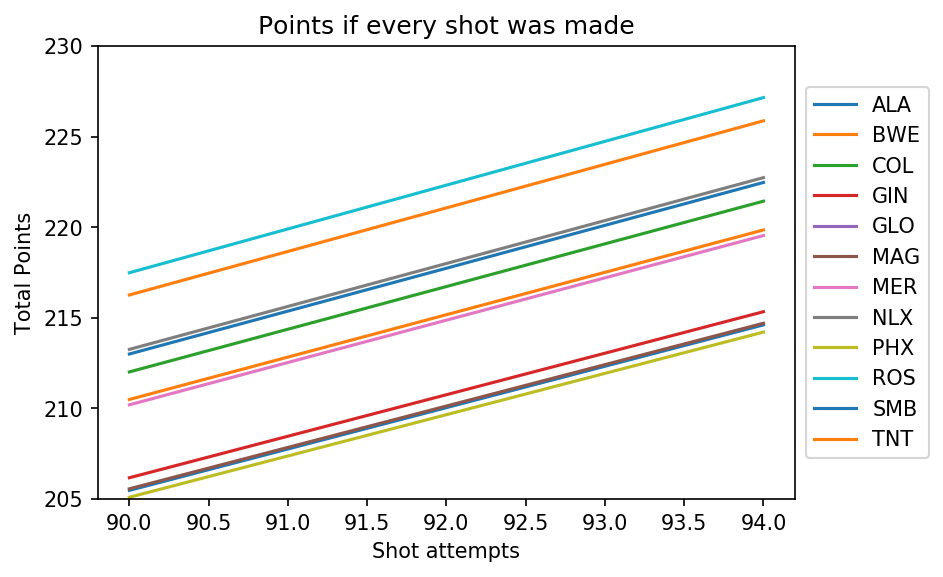

In [8]:
#If all shots were successfully made

teams = ['ALA','BWE','COL','GIN','GLO','MAG','MER','NLX','PHX','ROS','SMB'
         ,'TNT']

df_teams['3chance'] = df_teams['3Pa']/df_teams.FGa
df_teams['2chance'] = df_teams['2Pa']/df_teams.FGa

df_teams[['2chance','3chance']]

def possibility(teamA,A):
    aSum = df_teams['FGa'][df_teams['team_name']==teamA].sum()
    final = []
    for i in A:
        possA = i*(df_teams['FGa'][df_teams['team_name']==teamA]/aSum)
        threeptsA = (possA*df_teams['3chance']
                     [df_teams['team_name']==teamA]).sum()*3
        twoptsA = (possA*df_teams['2chance']
                   [df_teams['team_name']==teamA]).sum()*2
        totalA = threeptsA + twoptsA
        final.append(totalA)
    return final

def graph(form, teams, x_range):
    x = np.array(x_range)
    for i in teams:
        y = possibility(i,x)
        a = plt.plot(x,y,label=i)
        plt.legend(loc = 4)
    plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))

plt.figure(dpi=150)
plt.title('Points if every shot was made')
plt.xlabel('Shot attempts')
plt.ylabel('Total Points')
plt.ylim(205,230)

graph(possibility,teams,range(90,95))

The team generated a graph on which teams would score the highest per year on average if every shot attempt was made. Using the 3-point and 2-point averages, as well as the Field Goal stats, it can be seen that the Rain Or Shine and BlackWater Elite are the teams that have the highest scoring potential among the other teams.

### Player Statistic Distribution

#### Height per conference

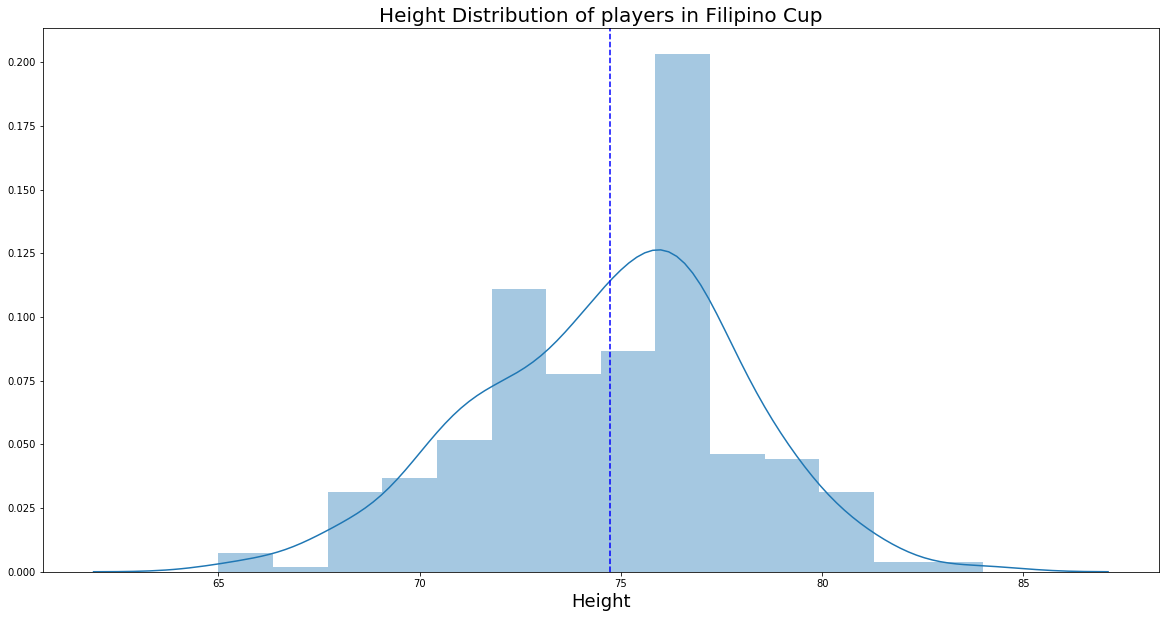

In [9]:
fig, ax = plt.subplots(figsize=(20,10))
sns.distplot(df_ph_c1['height'])
ax.set_title('Height Distribution of players in Filipino Cup', fontsize=20)

meanph = df_ph_c1['height'].mean()
ax.axvline(meanph, color='blue', linestyle='--')
ax.set_xlabel('Height', fontsize=18);

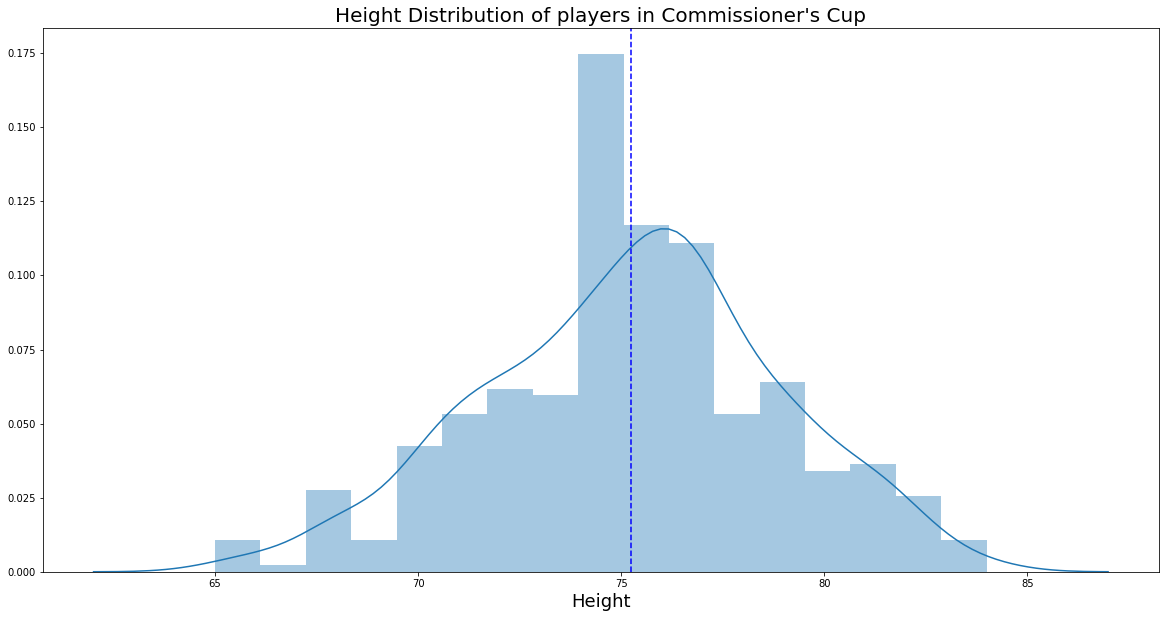

In [10]:
fig, ax = plt.subplots(figsize=(20,10))
sns.distplot(df_com_c1['height'])
ax.set_title("Height Distribution of players in Commissioner's Cup",
             fontsize=20)

meancom = df_com_c1['height'].mean()
ax.axvline(meancom, color='blue', linestyle='--')
ax.set_xlabel('Height', fontsize=18);

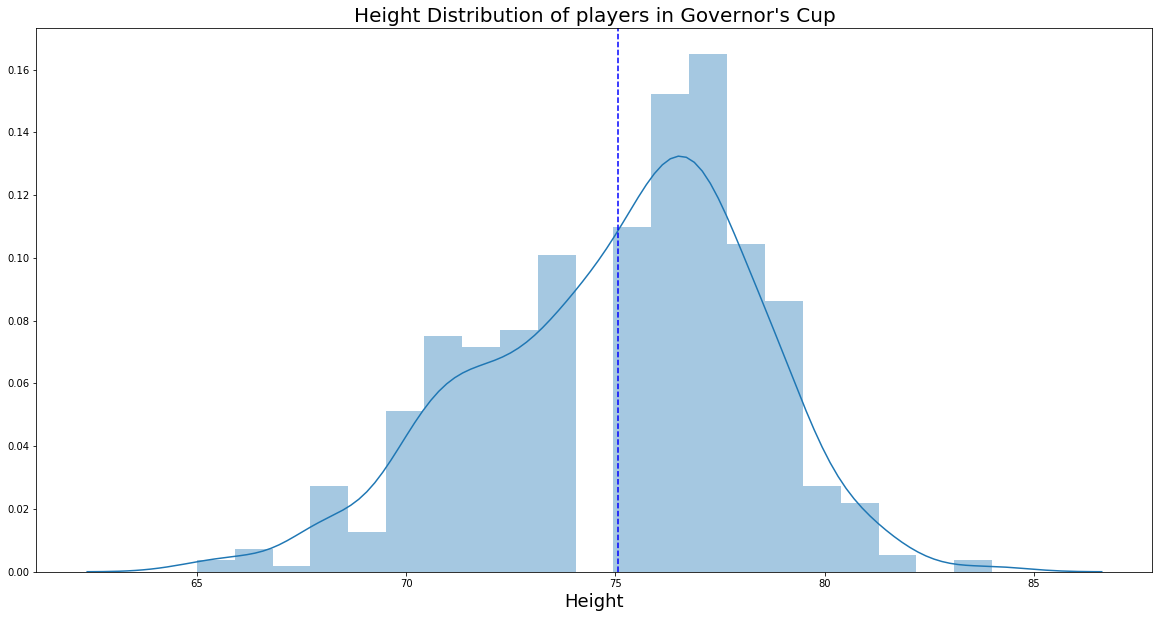

In [11]:
fig, ax = plt.subplots(figsize=(20,10))
sns.distplot(df_gov_c1['height'])
ax.set_title("Height Distribution of players in Governor's Cup",
             fontsize=20)

meangov = df_gov_c1['height'].mean()
ax.axvline(meangov, color='blue', linestyle='--')
ax.set_xlabel('Height', fontsize=18);

#### Average Rebound Distribution per conference

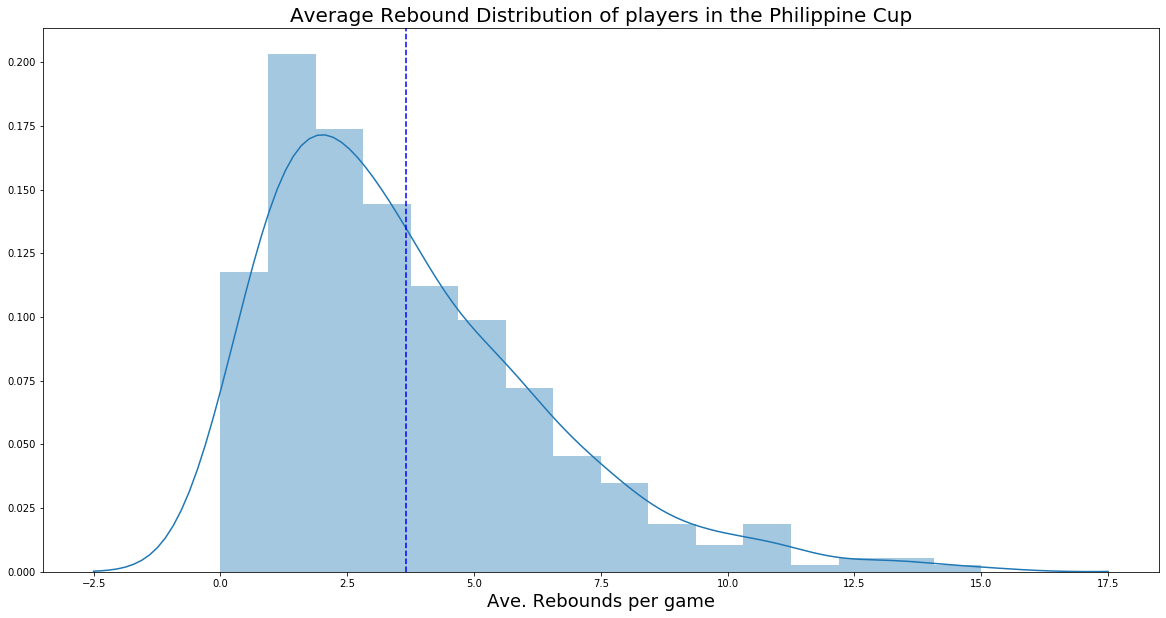

In [12]:
fig, ax = plt.subplots(figsize=(20,10))
sns.distplot(df_ph_c1['REB_avg'])
ax.set_title("Average Rebound Distribution of players in the Philippine Cup",
             fontsize=20)

meanph_r = df_ph_c1['REB_avg'].mean()
ax.axvline(meanph_r, color='blue', linestyle='--')
ax.set_xlabel('Ave. Rebounds per game', fontsize=18);

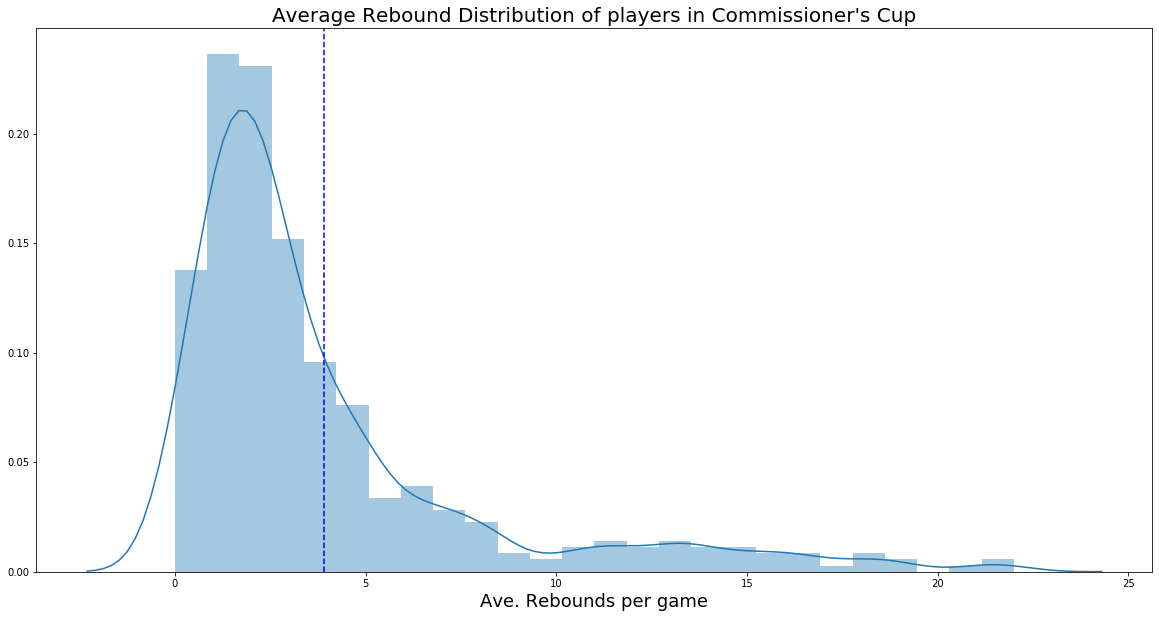

In [13]:
fig, ax = plt.subplots(figsize=(20,10))
sns.distplot(df_com_c1['REB_avg'])
ax.set_title("Average Rebound Distribution of players in Commissioner's Cup",
             fontsize=20)

meancom_r = df_com_c1['REB_avg'].mean()
ax.axvline(meancom_r, color='blue', linestyle='--')
ax.set_xlabel('Ave. Rebounds per game', fontsize=18);

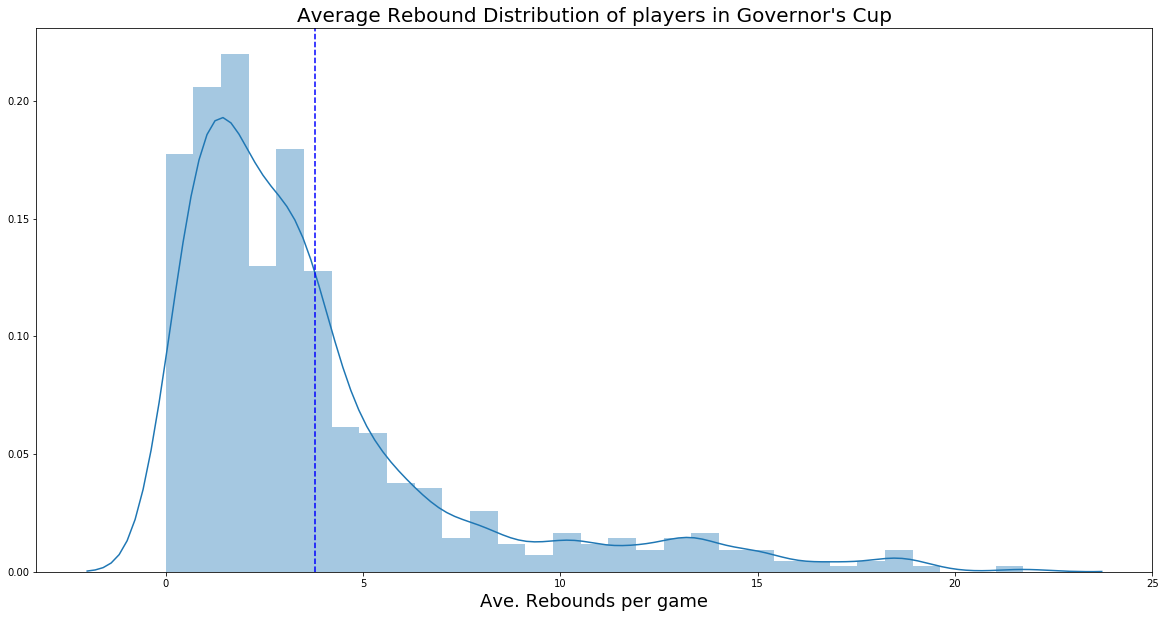

In [14]:
fig, ax = plt.subplots(figsize=(20,10))
sns.distplot(df_gov_c1['REB_avg'])
ax.set_title("Average Rebound Distribution of players in Governor's Cup",
             fontsize=20)

meangov_r = df_gov_c1['REB_avg'].mean()
ax.axvline(meangov_r, color='blue', linestyle='--')
ax.set_xlabel('Ave. Rebounds per game', fontsize=18);

#### Average points per game distribution, per conference

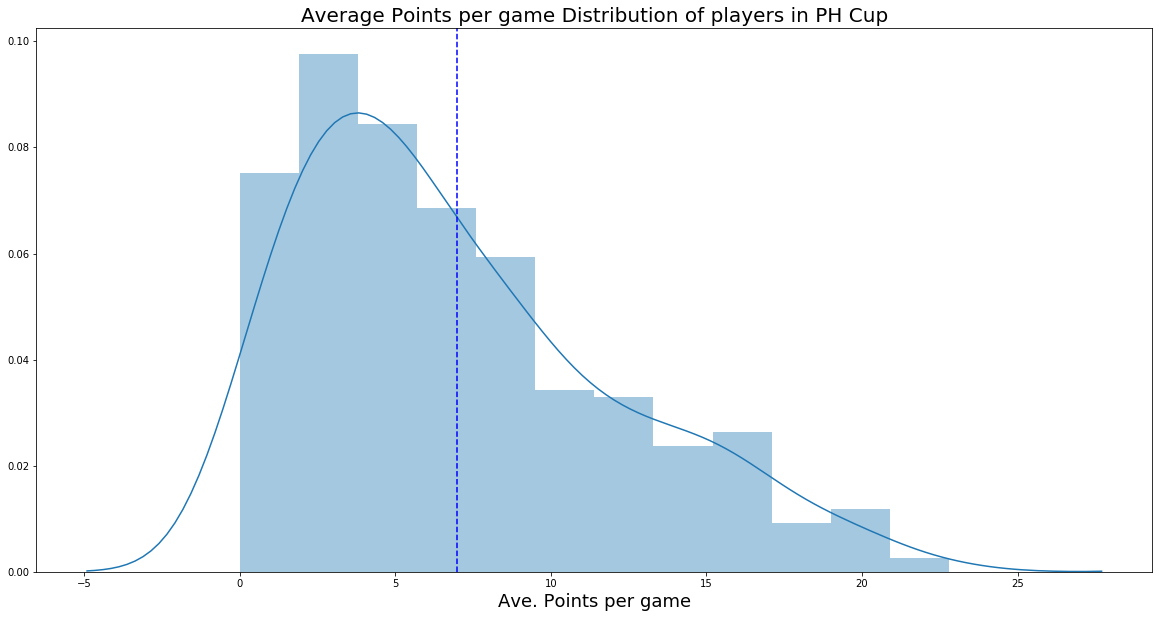

In [15]:
fig, ax = plt.subplots(figsize=(20,10))
sns.distplot(df_ph_c1['PTS_avg'])
ax.set_title("Average Points per game Distribution of players in PH Cup",
             fontsize=20)

meanph_p = df_ph_c1['PTS_avg'].mean()
ax.axvline(meanph_p, color='blue', linestyle='--')
ax.set_xlabel('Ave. Points per game', fontsize=18);

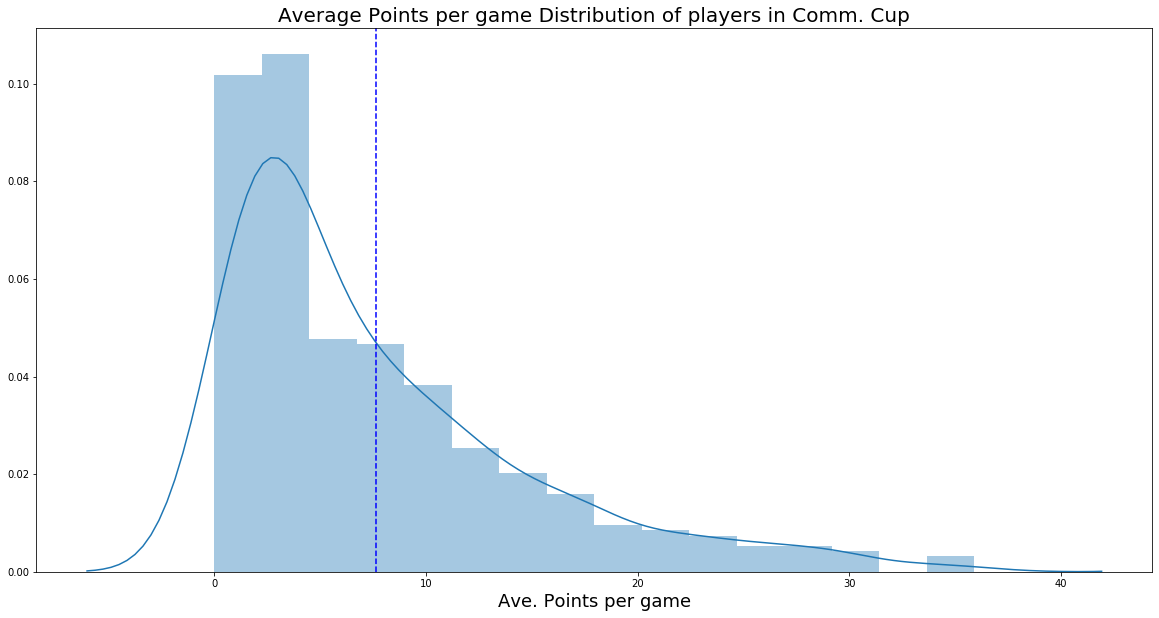

In [16]:
fig, ax = plt.subplots(figsize=(20,10))
sns.distplot(df_com_c1['PTS_avg'])
ax.set_title("Average Points per game Distribution of players in Comm. Cup",
             fontsize=20)

meancom_p = df_com_c1['PTS_avg'].mean()
ax.axvline(meancom_p, color='blue', linestyle='--')
ax.set_xlabel('Ave. Points per game', fontsize=18);

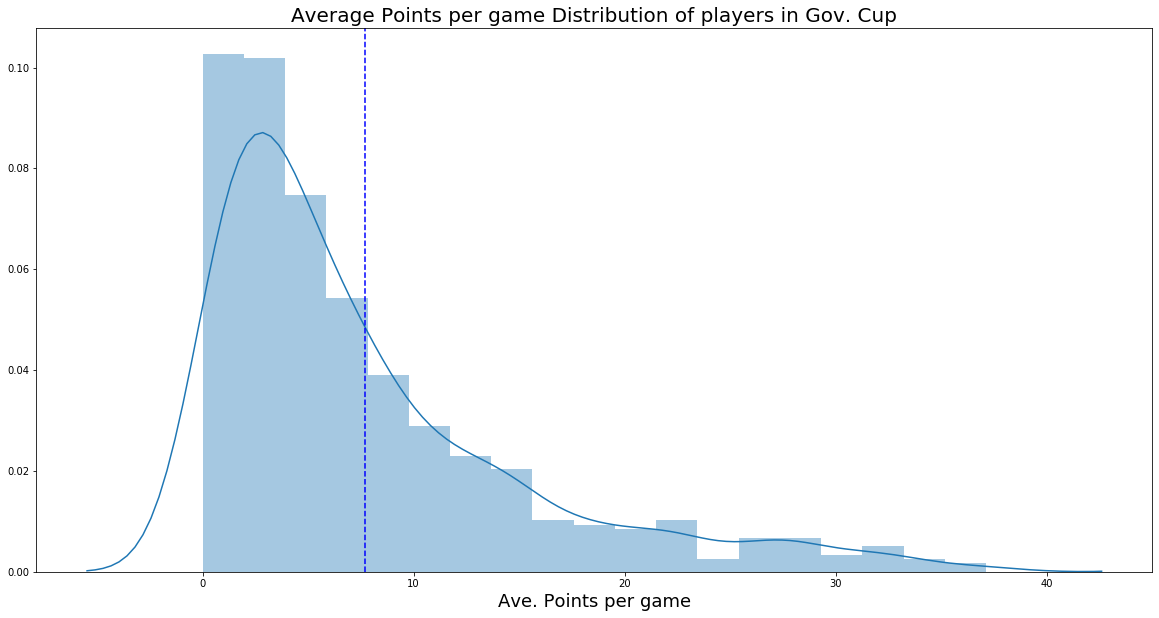

In [17]:
fig, ax = plt.subplots(figsize=(20,10))
sns.distplot(df_gov_c1['PTS_avg'])
ax.set_title("Average Points per game Distribution of players in Gov. Cup",
             fontsize=20)

meangov_p = df_gov_c1['PTS_avg'].mean()
ax.axvline(meangov_p, color='blue', linestyle='--')
ax.set_xlabel('Ave. Points per game', fontsize=18);

### Word Cloud Player Year

In [18]:
df = fetcher._get_total_stat()
df_complete = fetcher._get_allstat_with_name(df)

In [19]:
df_2017 = df_complete[df_complete['year']=='2017']
df_2018 = df_complete[df_complete['year']=='2018']
df_2019 = df_complete[df_complete['year']=='2019']

In [20]:
cols = ['team_name','player_name','pos',
        'year','j_number', 'height','weight','conference']
cluster_2017 = df_2017.drop(cols,axis=1)
cluster_2018 = df_2018.drop(cols,axis=1)
cluster_2019 = df_2019.drop(cols,axis=1)

In [21]:
standard_scaler = StandardScaler()

In [22]:
scaled_2017 = standard_scaler.fit_transform(cluster_2017)
scaled_2018 = standard_scaler.fit_transform(cluster_2018)
scaled_2019 = standard_scaler.fit_transform(cluster_2019)
X_2017 = PCA(n_components=2,random_state=1337).fit_transform(scaled_2017)
X_2018 = PCA(n_components=2,random_state=1337).fit_transform(scaled_2018)
X_2019 = PCA(n_components=2,random_state=1337).fit_transform(scaled_2019)

In [23]:
predict_2017 = KMeans(n_clusters=2,random_state=1337).fit_predict(X_2017)
predict_2018 = KMeans(n_clusters=2,random_state=1337).fit_predict(X_2018)
predict_2019 = KMeans(n_clusters=2,random_state=1337).fit_predict(X_2019)

In [32]:
df_2017['cluster'] = predict_2017
df_2018['cluster'] = predict_2018
df_2019['cluster'] = predict_2019

In [25]:
cluster_0_2017 = df_2017[df_2017['cluster']==0]
c0_2017 = " ".join(players for players in cluster_0_2017.player_name)
cluster_1_2017 = df_2017[df_2017['cluster']==1]
c1_2017 = " ".join(players for players in cluster_1_2017.player_name)

cluster_0_2018 = df_2018[df_2018['cluster']==0]
c0_2018 = " ".join(players for players in cluster_0_2018.player_name)
cluster_1_2018 = df_2018[df_2018['cluster']==1]
c1_2018 = " ".join(players for players in cluster_1_2018.player_name)

cluster_0_2019 = df_2019[df_2019['cluster']==0]
c0_2019 = " ".join(players for players in cluster_0_2019.player_name)
cluster_1_2019 = df_2019[df_2019['cluster']==1]
c1_2019 = " ".join(players for players in cluster_1_2019.player_name)

In [27]:
mask = np.array(Image.open('pba_logo_only.png'))

The group initially conducted clustering, and found that 2017 to 2019 data required 2 clusters when using all of the total stats data from the database. As a result, it can be considered as an "East vs. West All-Stars" scenario that happens in the NBA. The WordCloud of the years 2017 to 2019 is shown as follows:

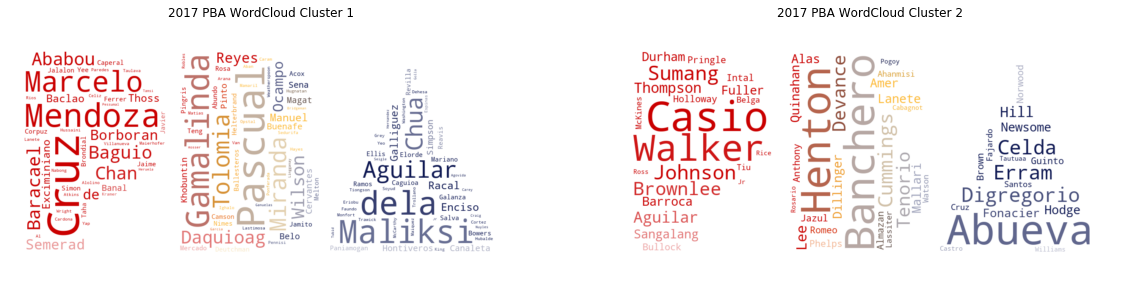

In [33]:
wordcloud = WordCloud(background_color='white',margin=10,
                      mask=mask,random_state=1337)
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
wordcloud.generate(c0_2017)
image_colors = ImageColorGenerator(mask)
ax1.set_title('2017 PBA WordCloud Cluster 1')
wordcloud.generate(c0_2017)
ax1.imshow(wordcloud.recolor(color_func=image_colors,random_state=1337),
          interpolation='bilinear')
ax1.axis('off')

ax2.set_title('2017 PBA WordCloud Cluster 2')
wordcloud.generate(c1_2017)
ax2.imshow(wordcloud.recolor(color_func=image_colors,random_state=1337),
          interpolation='bilinear')
ax2.axis('off')
fig.show()

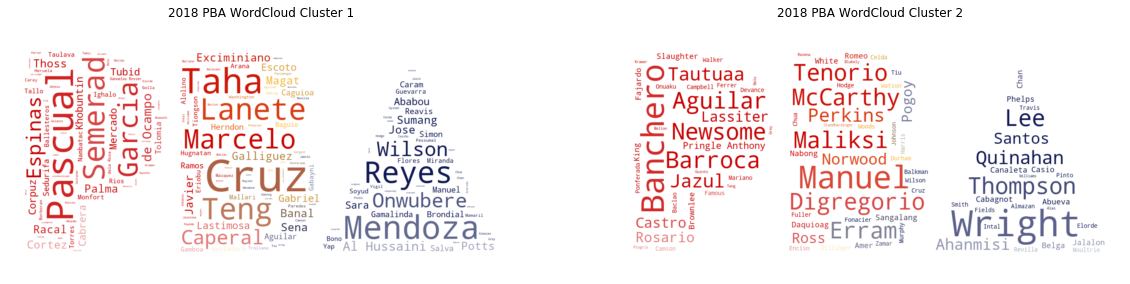

In [34]:
wordcloud = WordCloud(background_color='white',margin=10,
                      mask=mask,random_state=1337)
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
wordcloud.generate(c0_2018)
image_colors = ImageColorGenerator(mask)
ax1.set_title('2018 PBA WordCloud Cluster 1')
wordcloud.generate(c0_2018)
ax1.imshow(wordcloud.recolor(color_func=image_colors,random_state=1337),
          interpolation='bilinear')
ax1.axis('off')

ax2.set_title('2018 PBA WordCloud Cluster 2')
wordcloud.generate(c1_2018)
ax2.imshow(wordcloud.recolor(color_func=image_colors,random_state=1337),
          interpolation='bilinear')
ax2.axis('off')
fig.show()

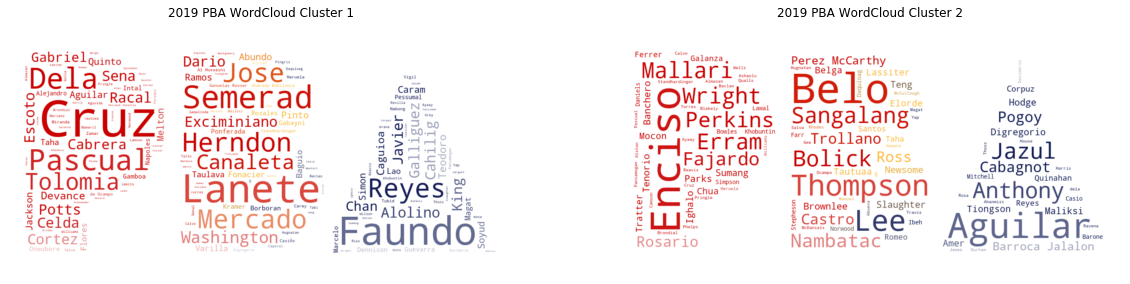

In [35]:
wordcloud = WordCloud(background_color='white',margin=10,
                      mask=mask,random_state=1337)
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
wordcloud.generate(c0_2019)
image_colors = ImageColorGenerator(mask)
ax1.set_title('2019 PBA WordCloud Cluster 1')
wordcloud.generate(c0_2019)
ax1.imshow(wordcloud.recolor(color_func=image_colors,random_state=1337),
          interpolation='bilinear')
ax1.axis('off')

ax2.set_title('2019 PBA WordCloud Cluster 2')
wordcloud.generate(c1_2019)
ax2.imshow(wordcloud.recolor(color_func=image_colors,random_state=1337),
          interpolation='bilinear')
ax2.axis('off')
fig.show()

### Word Cloud Player Minutes

In [36]:
def display_wc_player_freq_min():
    """Show playername Wordcloud based on minutes"""
    # Get player frequency
    engine = create_engine('sqlite:///pba.db')
    with engine.connect() as conn:
        df_player_total_mins = pd.read_sql("""SELECT p.player_name, ts.`MIN`
                                                FROM player p
                                                INNER JOIN total_stat ts
                                                ON p.`index` = ts.player_id
                                            """,
                                           con=conn)
    engine.dispose()
    df_player_total_mins.MIN = (df_player_total_mins.MIN
                                .apply(lambda x: round(x)))
    df_player_total_mins['last_name'] = (df_player_total_mins.player_name
                                     .apply(lambda x: x.split('. ')[1]))
    # Sum total frequency per conference
    player_freq = (df_player_total_mins.groupby('last_name')
               .sum().squeeze().to_dict())
    pba_mask = np.array(Image.open('pba_logo_wc.png'))
    # Word Cloud
    wc = WordCloud(mask=pba_mask, random_state=40, relative_scaling=0, 
                  background_color="white", regexp=r'\b[a-zA-Z]+?\b',
                   repeat=False)

    wc.generate_from_frequencies(player_freq)

    image_colors = ImageColorGenerator(pba_mask)
    wc.recolor(color_func=image_colors)
    plt.figure(figsize=(20, 10))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off');

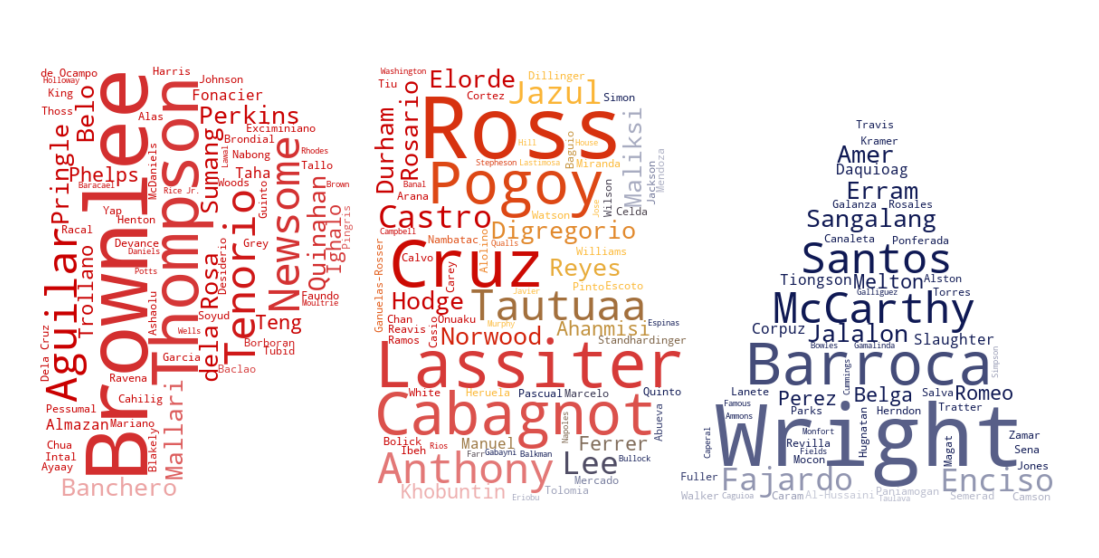

In [38]:
display_wc_player_freq_min()

### Word Cloud Player Points

In [39]:
def display_wc_player_freq_pts():
    """Show playername Wordcloud based on minutes"""
    # Get player frequency
    engine = create_engine('sqlite:///pba.db')
    with engine.connect() as conn:
        df_player_total_mins = pd.read_sql("""SELECT p.player_name, ts.`PTS`
                                                FROM player p
                                                INNER JOIN total_stat ts
                                                ON p.`index` = ts.player_id
                                            """,
                                           con=conn)
    engine.dispose()
    df_player_total_mins.PTS = (df_player_total_mins.PTS
                                .apply(lambda x: round(x)))
    df_player_total_mins['last_name'] = (df_player_total_mins.player_name
                                     .apply(lambda x: x.split('. ')[1]))
    # Sum total frequency per conference
    player_freq = (df_player_total_mins.groupby('last_name')
               .sum().squeeze().to_dict())
    pba_mask = np.array(Image.open('pba_logo_wc.png'))
    # Word Cloud
    wc = WordCloud(mask=pba_mask, random_state=40, relative_scaling=0, 
                  background_color="white", regexp=r'\b[a-zA-Z]+?\b',
                   repeat=False)

    wc.generate_from_frequencies(player_freq)

    image_colors = ImageColorGenerator(pba_mask)
    wc.recolor(color_func=image_colors)
    plt.figure(figsize=(20, 10))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off');

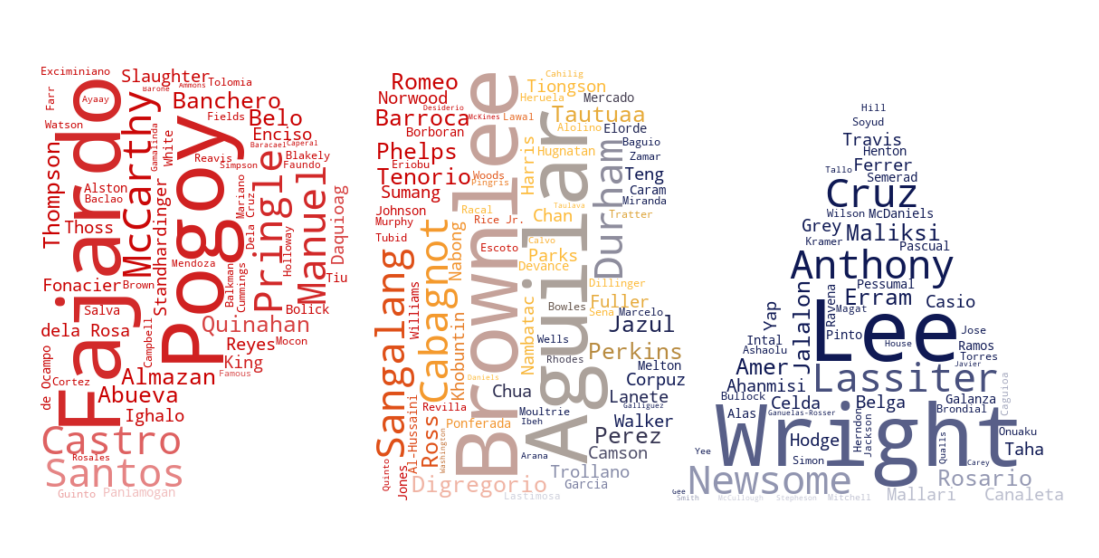

In [40]:
display_wc_player_freq_pts()

## Representative Clustering

### K-Means Clustering of Players by Conference

In [41]:
df_avgtot = fetcher.get_avg_total_player()
df_avgtot

year conference   player_name team_name pos  j_number  height  weight  \
0     2017        GOV     L. Henton       ALA   F       0.0    78.0   206.0   
1     2017        GOV     C. Abueva       ALA   F       0.0    73.0   209.0   
2     2017        GOV      J. Casio       ALA   G       0.0    70.0   175.0   
3     2017        GOV   C. Banchero       ALA   G      22.0    74.0   175.0   
4     2017        GOV     V. Manuel       ALA   F       0.0    76.0   227.0   
...    ...        ...           ...       ...  ..       ...     ...     ...   
1417  2020         PH     R. Escoto       SMB   C       0.0    78.0   185.0   
1418  2020         PH      P. Zamar       SMB   G       0.0    70.0   215.0   
1419  2020         PH  R. Gamalinda       SMB   G       0.0    76.0   184.0   
1420  2020         PH   V. Pessumal       SMB   G       0.0    74.0   215.0   
1421  2020         PH     W. Comboy       SMB   G       0.0    73.0   170.0   

      GP_avg  MIN_avg  ...  APG_total  STL_total  BLK_total  oREB_total  \
0         11    41.81  ...         26         18         23          34   
1          8    28.19  ...         18         10          8          29   
2         11    23.81  ...         40         10          2           4   
3         10    23.40  ...         31          9          2          14   
4          8    16.89  ...          2          3          2           9   
...      ...      ...  ...        ...        ...        ...         ...   
1417       1    11.52  ...          0          0          0           3   
1418       1     4.52  ...          0          0          0           0   
1419       1     5.57  ...          0          1          0           0   
1420       1     9.65  ...          0          0          0           0   
1421       1     0.43  ...          0          0          0           0   

      dREB_total  REB_total  PF_total  TOV_total  +/-_total  PTS_total  
0             95        129        20         39        -49        309  
1             56         85        19         24         -4        120  
2             30         34        25         17        -11        113  
3             24         38        25         23        -79         93  
4             29         38        13          6        -27         67  
...          ...        ...       ...        ...        ...        ...  
1417           2          5         2          2         -8          3  
1418           0          0         0          0         -4          3  
1419           0          0         0          1         -6          0  
1420           0          0         0          0         -3          0  
1421           0          0         0          0         -2          0  

[1422 rows x 50 columns]

In [42]:
df_fin00 = df_avgtot[['year','pos', 'height', 'weight', 'GP_avg', 'MIN_avg',
                      'FGm_avg', 'FGa_avg', 'FG%_avg', '3Pm_avg', '3Pa_avg',
                      '3P%_avg', 'FTm_avg', 'FTa_avg', 'FT%_avg', 'APG_avg',
                      'STL_avg', 'BLK_avg', 'oREB_avg', 'dREB_avg', 'REB_avg',
                      'PF_avg', 'TOV_avg', '+/-_avg', 'PTS_avg']]
df_fin01 = df_fin00.drop(['year', 'pos'], axis=1)
df_fin01

height  weight  GP_avg  MIN_avg  FGm_avg  FGa_avg  FG%_avg  3Pm_avg  \
0       78.0   206.0      11    41.81    10.18    24.09     0.42     2.91   
1       73.0   209.0       8    28.19     5.50    14.25     0.39     0.38   
2       70.0   175.0      11    23.81     3.82     8.00     0.48     1.27   
3       74.0   175.0      10    23.40     3.60     9.30     0.39     0.60   
4       76.0   227.0       8    16.89     3.38     8.50     0.40     0.00   
...      ...     ...     ...      ...      ...      ...      ...      ...   
1417    78.0   185.0       1    11.52     1.00     2.00     0.50     0.00   
1418    70.0   215.0       1     4.52     1.00     1.00     1.00     1.00   
1419    76.0   184.0       1     5.57     0.00     0.00     0.00     0.00   
1420    74.0   215.0       1     9.65     0.00     1.00     0.00     0.00   
1421    73.0   170.0       1     0.43     0.00     0.00     0.00     0.00   

      3Pa_avg  3P%_avg  ...  APG_avg  STL_avg  BLK_avg  oREB_avg  dREB_avg  \
0        8.82     0.33  ...     2.36     1.64     2.09      3.09      8.64   
1        2.38     0.16  ...     2.25     1.25     1.00      3.63      7.00   
2        3.73     0.34  ...     3.64     0.91     0.18      0.36      2.73   
3        1.70     0.35  ...     3.10     0.90     0.20      1.40      2.40   
4        0.00     0.00  ...     0.25     0.38     0.25      1.13      3.63   
...       ...      ...  ...      ...      ...      ...       ...       ...   
1417     0.00     0.00  ...     0.00     0.00     0.00      3.00      2.00   
1418     1.00     1.00  ...     0.00     0.00     0.00      0.00      0.00   
1419     0.00     0.00  ...     0.00     1.00     0.00      0.00      0.00   
1420     1.00     0.00  ...     0.00     0.00     0.00      0.00      0.00   
1421     0.00     0.00  ...     0.00     0.00     0.00      0.00      0.00   

      REB_avg  PF_avg  TOV_avg  +/-_avg  PTS_avg  
0       11.73    1.82     3.55    -4.45    28.09  
1       10.63    2.38     3.00    -0.50    15.00  
2        3.09    2.27     1.55    -1.00    10.27  
3        3.80    2.50     2.30    -7.90     9.30  
4        4.75    1.63     0.75    -3.38     8.38  
...       ...     ...      ...      ...      ...  
1417     5.00    2.00     2.00    -8.00     3.00  
1418     0.00    0.00     0.00    -4.00     3.00  
1419     0.00    0.00     1.00    -6.00     0.00  
1420     0.00    0.00     0.00    -3.00     0.00  
1421     0.00    0.00     0.00    -2.00     0.00  

[1422 rows x 23 columns]

#### KMeans

In [58]:
def plot_clusters(X, ys):
    """Plot clusters given the design matrix and cluster labels"""
    k_max = len(ys) + 1
    k_mid = k_max//2 + 2
    fig, ax = plt.subplots(2, k_max//2, dpi=150, sharex=True, sharey=True,
                           figsize=(7, 4), subplot_kw=dict(aspect='equal'),
                           gridspec_kw=dict(wspace=0.01))
    for k, y in zip(range(2, k_max+1), ys):
        if k < k_mid:
            ax[0][k % k_mid-2].scatter(*zip(*X), c=y, s=1, alpha=0.8)
            ax[0][k % k_mid-2].set_title('$k=%d$' % k)
        else:
            ax[1][k % k_mid].scatter(*zip(*X), c=y, s=1, alpha=0.8)
            ax[1][k % k_mid].set_title('$k=%d$' % k)
    return ax

def pooled_within_ssd(X, y, centroids, dist):
    """Compute pooled within-cluster sum of squares around the cluster mean

    Parameters
    ----------
    X : array
        Design matrix with each row corresponding to a point
    y : array
        Class label of each point
    centroids : array
        Number of pairs to sample
    dist : callable
        Distance between two points. It should accept two arrays, each 
        corresponding to the coordinates of each point

    Returns
    -------
    float
        Pooled within-cluster sum of squares around the cluster mean
    """
    # YOUR CODE HERE
    n_i = np.bincount(y.astype(int))
    return sum(dist(x_i, centroids[y_i])**2 / (2*n_i[y_i])
               for x_i, y_i in zip(X, y.astype(int)))

def gap_statistic(X, y, centroids, dist, b, clusterer):
    """Compute the gap statistic

    Parameters
    ----------
    X : array
        Design matrix with each row corresponding to a point
    y : array
        Class label of each point
    centroids : array
        Number of pairs to sample
    dist : callable
        Distance between two points. It should accept two arrays, each 
        corresponding to the coordinates of each point
    b : int
        Number of realizations for the reference distribution
    clusterer : KMeans
        Clusterer object that will be used for clustering the reference 
        realizations
    random_state : int, default=None
        Determines random number generation for realizations

    Returns
    -------
    gs : float
        Gap statistic
    gs_std : float
        Standard deviation of gap statistic
    """
    rng = np.random.default_rng(0)
    xmin = X.min(axis=0)
    xmax = X.max(axis=0)
    res = []
    for i in range(b):
        cluster = clone(clusterer)
        cluster.set_params(n_clusters=len(centroids))
        xi = rng.uniform(xmin, xmax, size=X.shape)
        yi = cluster.fit_predict(xi)
        res.append(np.log(pooled_within_ssd(
            xi, yi, cluster.cluster_centers_, dist)))
    return (np.mean(res -
                    np.log(pooled_within_ssd(X, y, centroids, dist))),
            np.std(res - np.log(pooled_within_ssd(X, y, centroids, dist))))

def cluster_range(X, clusterer, k_start, k_stop):
    """
    Return a dictionary of the cluster labels, internal validation
    values and, if actual labels is given, external validation values,
    for every  𝑘.

    Parameters
    ----------
    X : matrix
        design matrix
    clusterer : object
         clustering object
    k_start : int
        start of cluster
    k_stop : int
        stop of cluster

    Returns
    -------
    cluster_range : dictionary
        Cluster range
    """
    ys = []
    inertias = []
    chs = []
    scs = []
    gss = []
    gssds = []
    ps = []
    amis = []
    ars = []
    for k in range(k_start, k_stop+1):
        clusterer_k = clone(clusterer)
        # YOUR CODE HERE
        clusterer_k.set_params(n_clusters=k)
        y = clusterer_k.fit_predict(X)
        ys.append(y)
        inertias.append(clusterer_k.inertia_)
        chs.append(calinski_harabasz_score(X, y))
        scs.append(silhouette_score(X, y))
        gs = gap_statistic(X, y, clusterer_k.cluster_centers_,
                           euclidean, 5,
                           clone(clusterer).set_params(n_clusters=k))
        gss.append(gs[0])
        gssds.append(gs[1])
    # YOUR CODE HERE
    res = dict(
        ys=ys,
        inertias=inertias,
        chs=chs,
        scs=scs,
        gss=gss,
        gssds=gssds
    )
    return res

def plot_internal(inertias, chs, scs, gss, gssds):
    """Plot internal validation values"""
    fig, ax = plt.subplots()
    ks = np.arange(2, len(inertias)+2)
    ax.plot(ks, inertias, '-o', label='SSE')
    ax.plot(ks, chs, '-ro', label='CH')
    ax.set_xlabel('$k$')
    ax.set_ylabel('SSE/CH')
    lines, labels = ax.get_legend_handles_labels()
    ax2 = ax.twinx()
    ax2.errorbar(ks, gss, gssds, fmt='-go', label='Gap statistic')
    ax2.plot(ks, scs, '-ko', label='Silhouette coefficient')
    ax2.set_ylabel('Gap statistic/Silhouette')
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines+lines2, labels+labels2)
    return ax

standard_scaler = StandardScaler()

def plot_radar2(df_radar, ax, color):
    """PLot radar plot"""
    categories = df_radar.columns
    N = len(categories)
    
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # What will be the angle of each axis in the plot?
    # (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot

    # Draw one axe per variable + add labels labels yet
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_yticks([20, 40, 60, 80])
    ax.set_yticklabels(["20", "40", "60", "80"])

    ax.tick_params(direction='out', length=6, width=2, colors='grey',
                   grid_color='grey', grid_alpha=0.5, size=8)
    # Draw ylabels
    ax.set_rlabel_position(0)
    ax.set_ylim(0, 100)


    for i in range(len(df_radar)):
        # We are going to plot the first line of the data frame.
        # But we need to repeat the first value to close the circular graph:
        values = df_radar.iloc[i].to_list()
        values.append(values[0])
        
        # Plot data
        ax.plot(angles, values, linewidth=1, linestyle='solid',
                label=f'Group {df_radar.index[i]}', color=color[i-1])

        # Fill area
        ax.fill(angles, values, color[i-1], alpha=0.3, color=color[i-1])

    return ax

#### PHILIPPINE CUP

In [44]:
df_ph_c1 = df_avgtot[(df_avgtot['conference'] == 'PH')]
df_ph_c1 = df_ph_c1.drop('j_number', axis=1)
df_ph_c = df_ph_c1[['year','pos', 'height', 'weight', 'GP_avg', 'MIN_avg',
                      'FGm_avg', 'FGa_avg', 'FG%_avg', '3Pm_avg', '3Pa_avg',
                      '3P%_avg', 'FTm_avg', 'FTa_avg', 'FT%_avg', 'APG_avg',
                      'STL_avg', 'BLK_avg', 'oREB_avg', 'dREB_avg', 'REB_avg',
                      'PF_avg', 'TOV_avg', '+/-_avg', 'PTS_avg']]

df_ph_c = df_ph_c.drop(['year', 'pos'], axis=1)
df_ph_sc = standard_scaler.fit_transform(df_ph_c)
df_ph_re = PCA(n_components=2, random_state=0).fit_transform(df_ph_sc)
df_ph_c1

year conference   player_name team_name pos  height  weight  GP_avg  \
629   2018         PH     V. Manuel       ALA   F    76.0   227.0      11   
630   2018         PH     C. Abueva       ALA   F    73.0   209.0       9   
631   2018         PH       J. Teng       ALA   G    74.0   155.0      10   
632   2018         PH      J. Casio       ALA   G    70.0   175.0      11   
633   2018         PH   C. Banchero       ALA   G    74.0   175.0       9   
...    ...        ...           ...       ...  ..     ...     ...     ...   
1417  2020         PH     R. Escoto       SMB   C    78.0   185.0       1   
1418  2020         PH      P. Zamar       SMB   G    70.0   215.0       1   
1419  2020         PH  R. Gamalinda       SMB   G    76.0   184.0       1   
1420  2020         PH   V. Pessumal       SMB   G    74.0   215.0       1   
1421  2020         PH     W. Comboy       SMB   G    73.0   170.0       1   

      MIN_avg  FGm_avg  ...  APG_total  STL_total  BLK_total  oREB_total  \
629      0.45     5.91  ...         17         13          4          17   
630      0.32     5.33  ...         25         15         12          28   
631      0.00     5.00  ...         17         10          1          11   
632      0.45     3.64  ...         47          9          2           8   
633      0.24     4.33  ...         33         15          0          11   
...       ...      ...  ...        ...        ...        ...         ...   
1417    11.52     1.00  ...          0          0          0           3   
1418     4.52     1.00  ...          0          0          0           0   
1419     5.57     0.00  ...          0          1          0           0   
1420     9.65     0.00  ...          0          0          0           0   
1421     0.43     0.00  ...          0          0          0           0   

      dREB_total  REB_total  PF_total  TOV_total  +/-_total  PTS_total  
629           32         49        20         16         13        153  
630           65         93        31         33         36        124  
631           32         43        20         19        -21        131  
632           37         45        26         15         60        130  
633           24         35        25         16         50        104  
...          ...        ...       ...        ...        ...        ...  
1417           2          5         2          2         -8          3  
1418           0          0         0          0         -4          3  
1419           0          0         0          1         -6          0  
1420           0          0         0          0         -3          0  
1421           0          0         0          0         -2          0  

[399 rows x 49 columns]

In [52]:
kmeans_all_ph = cluster_range(df_ph_re, KMeans(random_state=0), 2, 9)

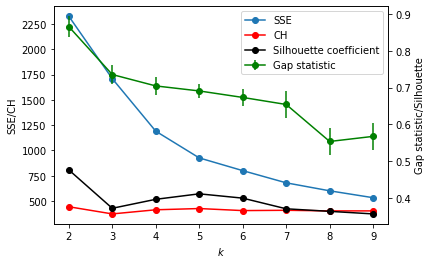

In [53]:
plot_internal(kmeans_all_ph['inertias'], kmeans_all_ph['chs'],
              kmeans_all_ph['scs'],  kmeans_all_ph['gss'],
              kmeans_all_ph['gssds']);

In [54]:
kmeans_ph = KMeans(n_clusters=4, random_state=1337)
y_predict_ph3 = kmeans_ph.fit_predict(df_ph_re)


In [55]:
df_ph_c1['cluster'] = y_predict_ph3
df_ph_c1 = df_ph_c1.replace({'cluster': 2}, "Role Players")
df_ph_c1 = df_ph_c1.replace({'cluster': 1}, "Bench Warmers")
df_ph_c1 = df_ph_c1.replace({'cluster': 3}, "Starting Frontcourt")
df_ph_c1 = df_ph_c1.replace({'cluster': 0}, "Starting Backcourt")
df_ph_c10 = df_ph_c1.groupby('cluster').mean()

df_ph_c10[['PTS_avg', '3Pm_avg', 'REB_avg', 'APG_avg', 'BLK_avg', 'height',
           'FG%_avg', '3P%_avg']]

PTS_avg   3Pm_avg   REB_avg   APG_avg   BLK_avg  \
cluster                                                                  
Bench Warmers         2.218058  0.224460  1.403022  0.501007  0.113741   
Role Players          6.535629  0.628543  3.786755  1.395894  0.257483   
Starting Backcourt   13.536933  1.818000  5.206267  3.607200  0.334533   
Starting Frontcourt  13.960294  0.332647  8.915588  2.108529  1.129118   

                        height   FG%_avg   3P%_avg  
cluster                                             
Bench Warmers        74.474820  0.348777  0.181439  
Role Players         74.933775  0.414437  0.263377  
Starting Backcourt   73.280000  0.415333  0.349867  
Starting Frontcourt  78.176471  0.484412  0.253529

Clustering into four yielded to four clusters that are different with each other, namely:

`Starting Frontcourt` which are the starting big men of the team.

`Starting Backcourt` which are the starting guards of the team. 

`Role Players` which are the players that contributes less than the starting players.

`Bench Warmers` which have the least contribution in the team.

These groups were created based on the player stats reflected by each cluster as shown in the figure below:

In [56]:
grouped_player_stats = (df_ph_c1[df_ph_c1['year'] == '2019' ]
                        .groupby('cluster')
                        .mean()[[
                            'FG%_avg', 'MIN_avg',
                            'REB_avg', 'PTS_avg', 'APG_avg' ]])

X_mins = grouped_player_stats['MIN_avg'] 
X_rebs = grouped_player_stats['REB_avg']
X_pts = grouped_player_stats['PTS_avg']
X_apg = grouped_player_stats['APG_avg']

grouped_player_stats['MIN_avg'] =( grouped_player_stats['MIN_avg']
                                  .apply(lambda x : x/48))
grouped_player_stats['REB_avg'] = (grouped_player_stats['REB_avg']
                                   .apply(lambda x : 
                                          abs(x-X_rebs.min())/
                                          (X_rebs.max()-X_rebs.min())))
grouped_player_stats['PTS_avg'] = (grouped_player_stats['PTS_avg']
                                   .apply(lambda x : 
                                          abs(x-X_pts.min())/
                                          (X_pts.max()-X_pts.min())))
grouped_player_stats['APG_avg'] = (grouped_player_stats['APG_avg']
                                   .apply(lambda x : 
                                          abs(x-X_apg.min())/(
                                              X_apg.max()-X_apg.min())))

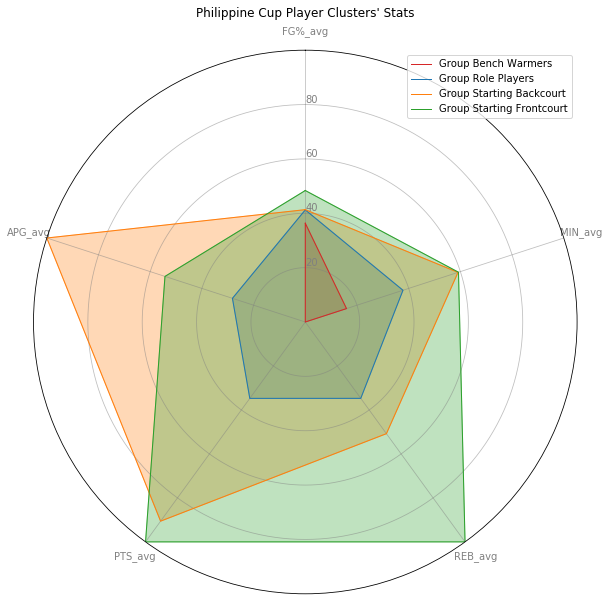

In [87]:
fig = plt.figure(figsize=(20,10))
ax = plt.gca(polar=True)
df_radar_ph = grouped_player_stats.copy()*100

plot_radar2(df_radar_ph, ax, ['tab:blue', 'tab:orange', 'tab:green', 
                              'tab:red'])
plt.title("Philippine Cup Player Clusters' Stats")
plt.legend();

In [61]:
df_10000 = df_ph_c1[df_ph_c1['player_name'].apply(lambda x: 'Pringle' in x)]
df_10000[['year', 'PTS_avg', "APG_avg", 'REB_avg', 'FG%_avg', 'cluster']]

year  PTS_avg  APG_avg  REB_avg  FG%_avg             cluster
741   2018    20.18     4.64     7.73     0.42  Starting Backcourt
1327  2019    20.50     4.60     6.10     0.47  Starting Backcourt

To demonstrate, `Pringle` was clustered as a `Starting Backcourt` which was accurate since he was one of the best backcourt for the past few years.

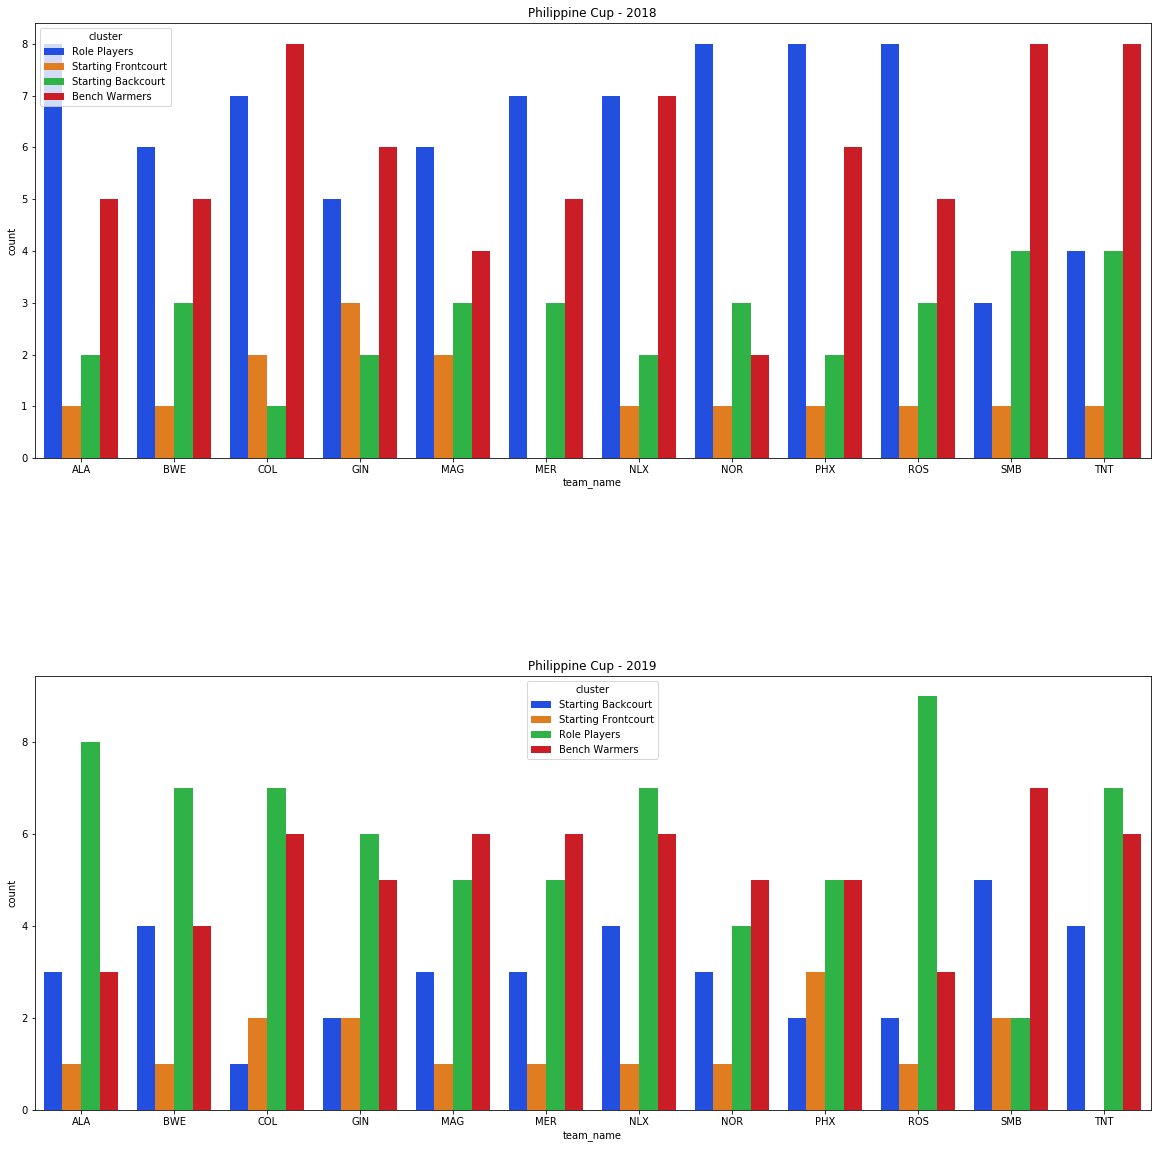

In [62]:
fig = plt.figure(figsize=(20,20))
gs2 = fig.add_gridspec(nrows=2, ncols=1, wspace=0.25, hspace=0.5)

years = ['2018','2019']
for x in range(2):
    ax = fig.add_subplot(gs2[x])
    sns.countplot(data=df_ph_c1[df_ph_c1['year'] == years[x]],
                  hue='cluster', x='team_name', palette='bright')
    ax.set_title('Philippine Cup - ' + years[x])


Based on these graphs, `San Miguel Beermen` has the highest number of Starting Frontcourt and Backcourt, which creates an imbalance to the whole league, and eventually leading them to win five straight Filipino Cup championships.

#### COMMISSIONER'S CUP CLUSTERING

Since imports are introduced on the Commissioner's Cup, it is expected that other players would be demoted from being a Starting Frontcourt to a Role Player.

In [63]:
df_com_c1 = df_avgtot[(df_avgtot['conference'] == 'COM')]
df_com_c1 = df_com_c1.drop('j_number', axis=1)
df_com_c = df_com_c1[['year','pos', 'height', 'weight', 'GP_avg', 'MIN_avg',
                      'FGm_avg', 'FGa_avg', 'FG%_avg', '3Pm_avg', '3Pa_avg',
                      '3P%_avg', 'FTm_avg', 'FTa_avg', 'FT%_avg', 'APG_avg',
                      'STL_avg', 'BLK_avg', 'oREB_avg', 'dREB_avg', 'REB_avg',
                      'PF_avg', 'TOV_avg', '+/-_avg', 'PTS_avg']]

df_com_c = df_com_c.drop(['year', 'pos'], axis=1)
df_com_sc = standard_scaler.fit_transform(df_com_c)
df_com_re = PCA(n_components=2, random_state=0).fit_transform(df_com_sc)
df_com_c1

year conference  player_name team_name pos  height  weight  GP_avg  \
217   2018        COM    V. Manuel       ALA   F    76.0   227.0      11   
218   2018        COM  A. Campbell       ALA   F    80.0   265.0      10   
219   2018        COM   D. Simpson       ALA   C    79.0   240.0       1   
220   2018        COM    C. Abueva       ALA   F    73.0   209.0       5   
221   2018        COM  C. Banchero       ALA   G    74.0   175.0      11   
...    ...        ...          ...       ...  ..     ...     ...     ...   
1022  2019        COM   D. Semerad       TNT   F    77.0   226.0      10   
1023  2019        COM    J. Casiño       TNT   G    70.0   175.0       9   
1024  2019        COM     F. Golla       TNT   F    74.0   290.0       6   
1025  2019        COM     H. Carey       TNT   F    75.0   210.0       2   
1026  2019        COM   M. Miranda       TNT   C    79.0   210.0       3   

      MIN_avg  FGm_avg  ...  APG_total  STL_total  BLK_total  oREB_total  \
217     21.96    10.36  ...         10          9          7          13   
218     31.69     8.30  ...         20         12         15          29   
219     31.68     6.00  ...          4          0          4           4   
220     19.90     3.40  ...         14         11          6          15   
221     27.34     3.91  ...         71         12          0          10   
...       ...      ...  ...        ...        ...        ...         ...   
1022     5.71     0.30  ...          2          1          1           9   
1023     3.34     0.11  ...          3          0          0           1   
1024     1.76     0.00  ...          1          0          0           1   
1025     2.81     0.00  ...          0          0          0           0   
1026     5.03     0.00  ...          1          0          0           0   

      dREB_total  REB_total  PF_total  TOV_total  +/-_total  PTS_total  
217           57         70        22         23         68        266  
218          119        148        36         30         13        226  
219           15         19         3          4         18         18  
220           32         47        11         17         43         52  
221           28         38        27         23          9        108  
...          ...        ...       ...        ...        ...        ...  
1022           8         17        16          8          2          8  
1023           2          3         4          1        -27          3  
1024           0          1         1          1        -19          0  
1025           1          1         0          0          3          0  
1026           1          1         0          0          3          0  

[420 rows x 49 columns]

In [64]:
kmeans_all_com = cluster_range(df_com_re, KMeans(random_state=0), 2, 9)

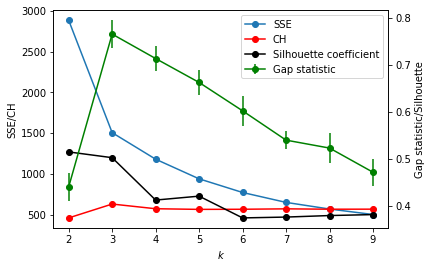

In [65]:
plot_internal(kmeans_all_com['inertias'], kmeans_all_com['chs'],
              kmeans_all_com['scs'],  kmeans_all_com['gss'],
              kmeans_all_com['gssds'])

In [66]:
kmeans_com = KMeans(n_clusters=4, random_state=0)
y_predict_com3 = kmeans_com.fit_predict(df_com_re)

In [67]:
df_com_c1['cluster'] = y_predict_com3
df_com_c1 = df_com_c1.replace({'cluster': 3}, "Role Players")
df_com_c1 = df_com_c1.replace({'cluster': 1}, "Imports + Big Men")
df_com_c1 = df_com_c1.replace({'cluster': 0}, "Bench Warmers")
df_com_c1 = df_com_c1.replace({'cluster': 2}, "Starters")
df_com_c10 = df_com_c1.groupby('cluster').mean()
df_com_c10[['PTS_avg', '3Pm_avg', 'REB_avg', 'APG_avg', 'BLK_avg', 'height']]

PTS_avg   3Pm_avg    REB_avg   APG_avg   BLK_avg  \
cluster                                                                 
Bench Warmers       2.294840  0.171809   1.534734  0.524628  0.138351   
Imports + Big Men  22.879762  0.798333  14.420476  3.079762  1.733810   
Role Players        7.060984  0.816311   3.342541  1.843525  0.238689   
Starters           14.051471  1.703676   4.978382  3.993676  0.286324   

                      height  
cluster                       
Bench Warmers      75.053191  
Imports + Big Men  80.500000  
Role Players       74.688525  
Starters           73.558824

Clustering into four yielded to four clusters that are different with each other, namely:

`Imports + Big Men` which consists of the imports and the big men who have huge statistical contribution to the team.

`Starters` which are the starting guards of the team. 

`Role Players` which are the players that contributes less than the starting players.

`Bench Warmers` which have the least contribution in the team.

In [79]:
grouped_player_stats_com = (df_com_c1[df_com_c1['year'] == '2019' ]
                        .groupby('cluster')
                        .mean()[[
                            'FG%_avg', 'MIN_avg',
                            'REB_avg', 'PTS_avg', 'APG_avg' ]])

X_mins_com = grouped_player_stats_com['MIN_avg'] 
X_rebs_com = grouped_player_stats_com['REB_avg']
X_pts_com = grouped_player_stats_com['PTS_avg']
X_apg_com = grouped_player_stats_com['APG_avg']

grouped_player_stats_com['MIN_avg'] = (grouped_player_stats_com['MIN_avg']
                                       .apply(lambda x : x/48))

grouped_player_stats_com['REB_avg'] = (grouped_player_stats_com['REB_avg']
                                       .apply(lambda x : 
                                              abs(x-X_rebs_com.min())/
                                              (X_rebs_com.max()-X_rebs_com
                                               .min())))

grouped_player_stats_com['PTS_avg'] = (grouped_player_stats_com['PTS_avg']
                                       .apply(lambda x : 
                                              abs(x-X_pts_com.min())/
                                              (X_pts_com.max()-X_pts_com
                                               .min())))

grouped_player_stats_com['APG_avg'] = (grouped_player_stats_com['APG_avg']
                                       .apply(lambda x : 
                                              abs(x-X_apg_com.min())/
                                              (X_apg_com.max()-X_apg_com
                                               .min())))

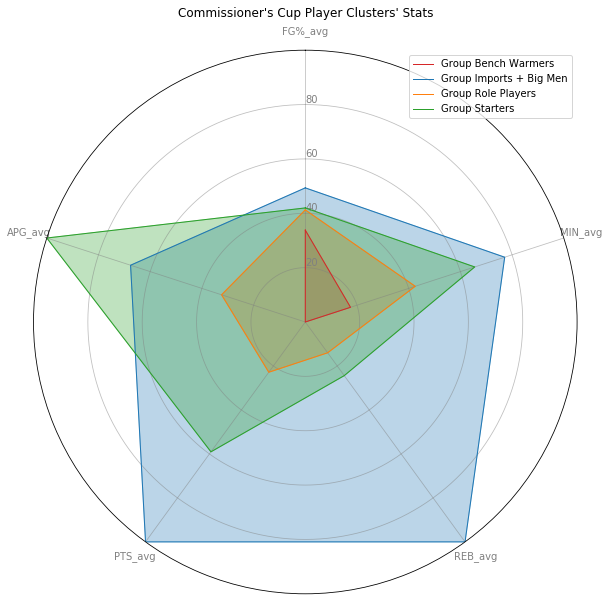

In [86]:
fig = plt.figure(figsize=(20,10))
ax = plt.gca(polar=True)
df_radar_com = grouped_player_stats_com.copy()*100

plot_radar2(df_radar_com, ax, ['tab:blue', 'tab:orange', 'tab:green', 
                               'tab:red'])
plt.title("Commissioner's Cup Player Clusters' Stats")
plt.legend();

In [68]:
df_commi_imp = df_com_c1[df_com_c1['cluster'] == "Role Players"]
df_commi_imp[['player_name', 'MIN_avg', 'PTS_avg', 'REB_avg']].sort_values(by='PTS_avg', ascending=False)[:20]

player_name  MIN_avg  PTS_avg  REB_avg
825          V. Manuel    21.58    13.50     4.63
876         J. Aguilar    26.90    13.36     4.91
293       I. Sangalang    23.30    12.50     6.83
403  C. Standhardinger    24.32    12.20     7.20
878       A. Dela Cruz    26.05    12.00     5.00
895          J. Fields    30.18    12.00     6.00
326        J. Quinahan    24.66    12.00     4.36
365         J. Perkins    20.95    11.82     6.00
418           R. Pogoy    21.29    11.18     4.09
258          E. Camson    20.04    11.10     4.40
930          K. Ighalo    27.01    10.73     2.91
240           J. Erram    28.03    10.70     8.30
310        N. Canaleta    17.86    10.45     3.45
911            B. Amer    27.48    10.42     2.92
931           J. Erram    23.84    10.36     7.45
275       G. Slaughter    25.92    10.22     8.67
241           P. Zamar    22.61    10.14     3.00
346         M. Tautuaa    22.68     9.90     8.10
879       G. Slaughter    24.30     9.73     6.64
981        R. Nambatac    25.90     9.64     3.64

Majority of the players above are clustered as starting frontcourt in the Philippine Cup. Even though they are producing above average stats, those stats are nowhere near the stats of the imports.

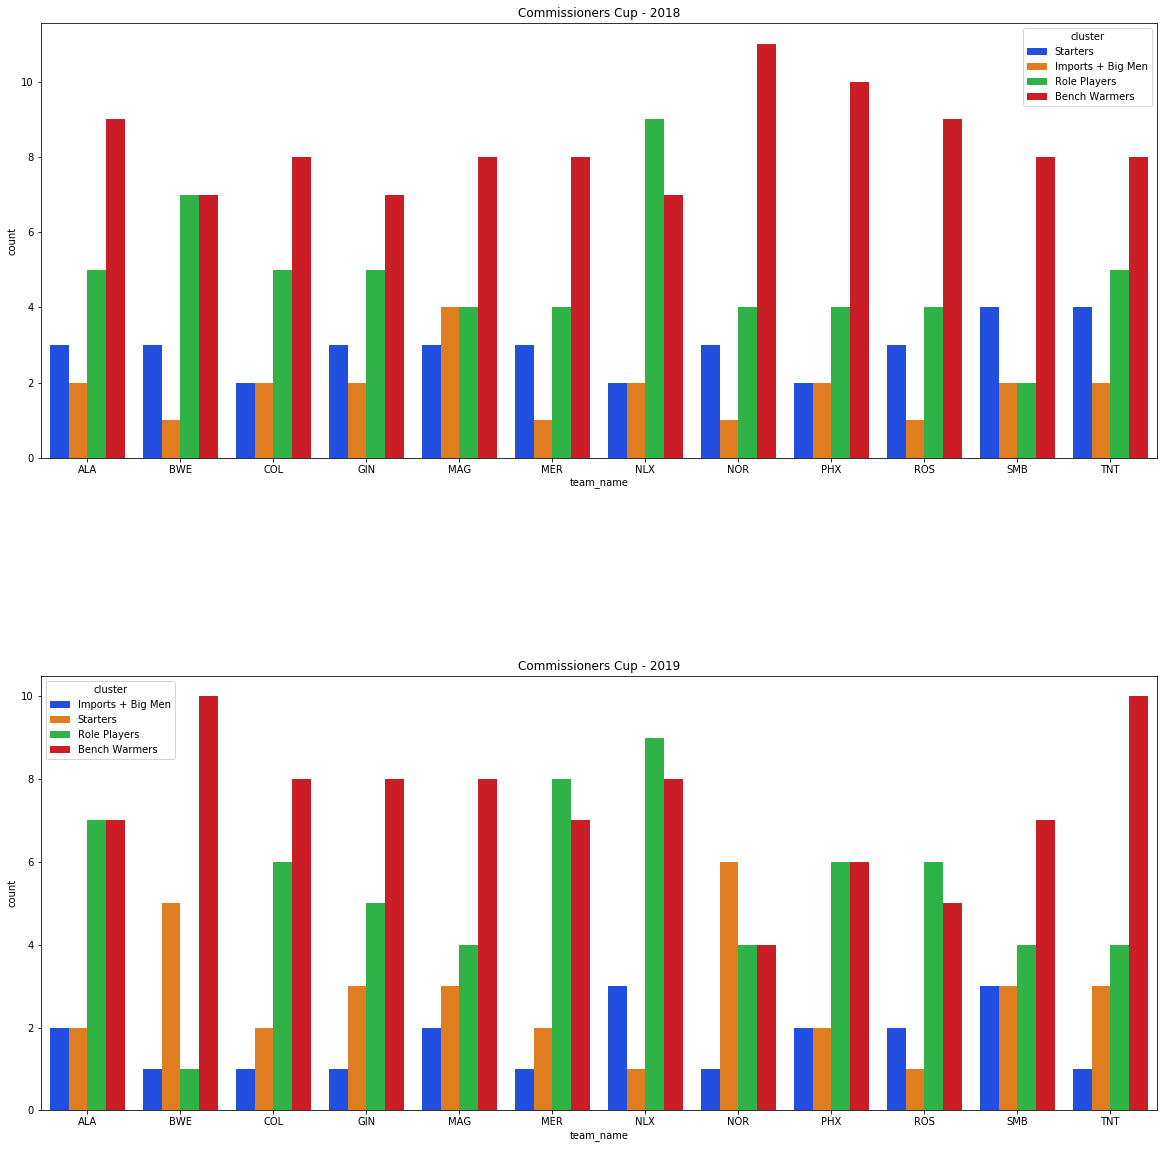

In [69]:
fig = plt.figure(figsize=(20,20))
gs2 = fig.add_gridspec(nrows=2, ncols=1, wspace=0.25, hspace=0.5)
years = ['2018','2019']
for x in range(2):
    ax = fig.add_subplot(gs2[x])
    sns.countplot(data=df_com_c1[df_com_c1['year'] == years[x]],
                  hue='cluster', x='team_name', palette='bright')
    ax.set_title('Commissioners Cup - ' + years[x])

Overall, the three SMC teams have the most number of import + starters. And this imbalance lead to Ginebra being the champion last 2018 and the San Miguel last 2019.

#### GOVERNOR'S CUP CLUSTERING

Similar to Commissioner's Cup, the Governor's Cup also allows one import per team. And the group used KMeans clustering to segment the players based on their individual statistics.

In [89]:
df_gov_c1 = df_avgtot[(df_avgtot['conference'] == 'GOV')]
df_gov_c1 = df_gov_c1.drop('j_number', axis=1)
df_gov_c = df_gov_c1[['year','pos', 'height', 'weight', 'GP_avg', 'MIN_avg',
                      'FGm_avg', 'FGa_avg', 'FG%_avg', '3Pm_avg', '3Pa_avg',
                      '3P%_avg', 'FTm_avg', 'FTa_avg', 'FT%_avg', 'APG_avg',
                      'STL_avg', 'BLK_avg', 'oREB_avg', 'dREB_avg', 'REB_avg',
                      'PF_avg', 'TOV_avg', '+/-_avg', 'PTS_avg']]

df_gov_c = df_gov_c.drop(['year', 'pos'], axis=1)
df_gov_sc = standard_scaler.fit_transform(df_gov_c)
df_gov_re = PCA(n_components=2, random_state=0).fit_transform(df_gov_sc)
df_gov_c1

year conference    player_name team_name pos  height  weight  GP_avg  \
0     2017        GOV      L. Henton       ALA   F    78.0   206.0      11   
1     2017        GOV      C. Abueva       ALA   F    73.0   209.0       8   
2     2017        GOV       J. Casio       ALA   G    70.0   175.0      11   
3     2017        GOV    C. Banchero       ALA   G    74.0   175.0      10   
4     2017        GOV      V. Manuel       ALA   F    76.0   227.0       8   
...    ...        ...            ...       ...  ..     ...     ...     ...   
1211  2019        GOV       M. Magat       TNT   F    79.0   180.0       7   
1212  2019        GOV        Y. Taha       TNT   C    81.0   240.0       4   
1213  2019        GOV  J. Washington       TNT   F    80.0   225.0       7   
1214  2019        GOV     A. Semerad       TNT   F    77.0   170.0       2   
1215  2019        GOV      J. Casiño       TNT   G    70.0   175.0       1   

      MIN_avg  FGm_avg  ...  APG_total  STL_total  BLK_total  oREB_total  \
0       41.81    10.18  ...         26         18         23          34   
1       28.19     5.50  ...         18         10          8          29   
2       23.81     3.82  ...         40         10          2           4   
3       23.40     3.60  ...         31          9          2          14   
4       16.89     3.38  ...          2          3          2           9   
...       ...      ...  ...        ...        ...        ...         ...   
1211     3.70     0.43  ...          1          0          0           2   
1212     6.98     0.25  ...          1          0          2           2   
1213     4.54     0.14  ...          1          3          1           3   
1214    10.21     0.00  ...          0          0          0           0   
1215     9.70     0.00  ...          2          0          0           0   

      dREB_total  REB_total  PF_total  TOV_total  +/-_total  PTS_total  
0             95        129        20         39        -49        309  
1             56         85        19         24         -4        120  
2             30         34        25         17        -11        113  
3             24         38        25         23        -79         93  
4             29         38        13          6        -27         67  
...          ...        ...       ...        ...        ...        ...  
1211           3          5         5          0         -5          6  
1212           4          6         3          4        -25          3  
1213           5          8         5          1         -9          4  
1214           3          3         2          2         -6          0  
1215           0          0         0          1          0          0  

[603 rows x 49 columns]

In [90]:
kmeans_all_gov = cluster_range(df_gov_re, KMeans(random_state=0), 2, 9)

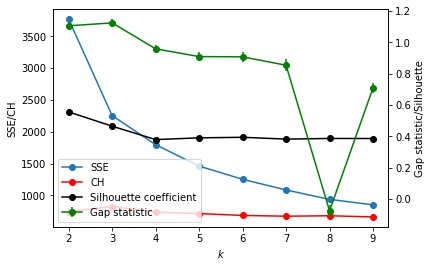

In [91]:
plot_internal(kmeans_all_gov['inertias'], kmeans_all_gov['chs'],
              kmeans_all_gov['scs'],  kmeans_all_gov['gss'],
              kmeans_all_gov['gssds'])

In [92]:
kmeans_gov = KMeans(n_clusters=4)
y_predict_gov3 = kmeans_gov.fit_predict(df_gov_re)

In [103]:
df_gov_c1['cluster'] = y_predict_gov3
df_gov_c1 = df_gov_c1.replace({'cluster': 0}, "Role Players")
df_gov_c1 = df_gov_c1.replace({'cluster': 3}, "Imports + Big Men")
df_gov_c1 = df_gov_c1.replace({'cluster': 2}, "Bench Warmers")
df_gov_c1 = df_gov_c1.replace({'cluster': 1}, "Starters")
df_gov_c10 = df_gov_c1.groupby('cluster').mean()
df_gov_c10[['PTS_avg', '3Pm_avg', 'REB_avg', 'APG_avg', 'BLK_avg', 'height',
            'MIN_avg']]

PTS_avg   3Pm_avg    REB_avg   APG_avg   BLK_avg  \
cluster                                                                 
Bench Warmers       1.901266  0.139476   1.457729  0.442926  0.128035   
Imports + Big Men  25.114754  1.297377  13.209508  3.945246  1.286885   
Role Players        5.953384  0.738081   2.715808  1.356667  0.226010   
Starters           13.021217  1.375304   5.269652  3.110870  0.406261   

                      height    MIN_avg  
cluster                                  
Bench Warmers      75.248908   7.558646  
Imports + Big Men  77.950820  38.892787  
Role Players       74.101010  17.192020  
Starters           74.808696  29.145217

Similar to the Commissioner's Cup, clustering the players into four yielded to four clusters that are different with each other, namely:

`Imports + Big Men` which consists of the imports and the big men who have huge statistical contribution to the team.

`Starters` which are the starting guards of the team. 

`Role Players` which are the players that contributes less than the starting players.

`Bench Warmers` which have the least contribution in the team.

In [106]:
grouped_player_stats_gov = (df_gov_c1[df_gov_c1['year'] == '2019' ]
                        .groupby('cluster')
                        .mean()[[
                            'FG%_avg', 'MIN_avg',
                            'REB_avg', 'PTS_avg', 'APG_avg' ]])

X_mins_gov = grouped_player_stats_gov['MIN_avg'] 
X_rebs_gov = grouped_player_stats_gov['REB_avg']
X_pts_gov = grouped_player_stats_gov['PTS_avg']
X_apg_gov = grouped_player_stats_gov['APG_avg']

grouped_player_stats_gov['MIN_avg'] = (grouped_player_stats_gov['MIN_avg']
                                       .apply(lambda x : x/48))

grouped_player_stats_gov['REB_avg'] = (grouped_player_stats_gov['REB_avg']
                                       .apply(lambda x : 
                                              abs(x-X_rebs_gov.min())
                                              /(X_rebs_gov.max()-
                                                X_rebs_gov.min())))

grouped_player_stats_gov['PTS_avg'] = (grouped_player_stats_gov['PTS_avg']
                                       .apply(lambda x : 
                                              abs(x-X_pts_gov.min())
                                              /(X_pts_gov.max()-
                                                X_pts_gov.min())))

grouped_player_stats_gov['APG_avg'] = (grouped_player_stats_gov['APG_avg']
                                       .apply(lambda x : 
                                              abs(x-X_apg_gov.min())
                                              /(X_apg_gov.max()-
                                                X_apg_gov.min())))

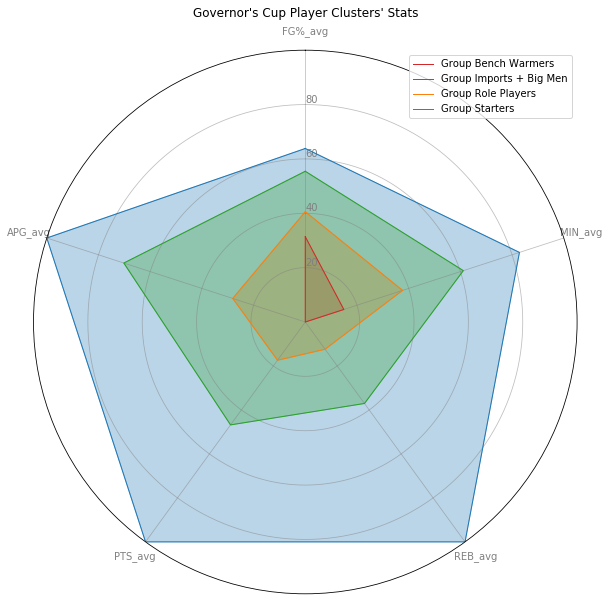

In [107]:
fig = plt.figure(figsize=(20,10))
ax = plt.gca(polar=True)
df_radar_gov = grouped_player_stats_gov.copy()*100

plot_radar2(df_radar_gov, ax, ['tab:blue', 'tab:orange', 'tab:green', 
                               'tab:red'])
plt.title("Governor's Cup Player Clusters' Stats")
plt.legend();

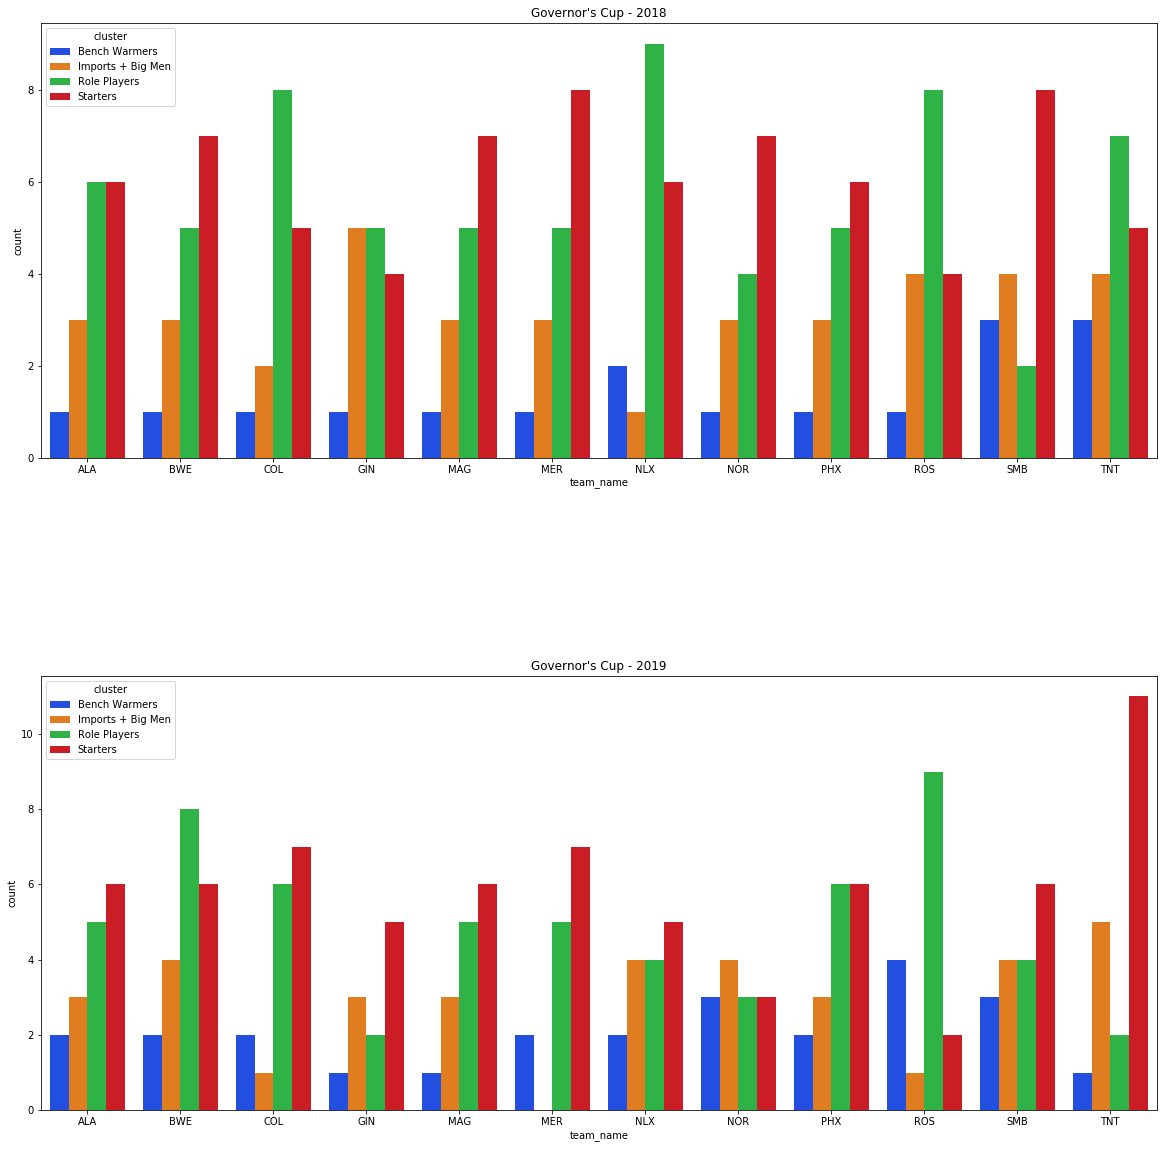

In [94]:
fig = plt.figure(figsize=(20,20))
gs2 = fig.add_gridspec(nrows=2, ncols=1, wspace=0.25, hspace=0.5)
years = ['2018','2019']
for x in range(2):
    ax = fig.add_subplot(gs2[x])
    sns.countplot(data=df_gov_c1[df_gov_c1['year'] == years[x]],
                  hue='cluster', x='team_name', palette='bright')
    ax.set_title("Governor's Cup - " + years[x])

Again, the three major SMC teams have the most number of players that are in the `Imports` and `Starters` cluster. Two of those teams (Magnolia and Ginebra) eventually won the titles in 2018 and 2019, respectively.

## Hierarchical Clustering

In [14]:
def plot_variance(decomposition, title, ax, xlabel='SV'):
    """Plot latend"""
    var_exp = decomposition.explained_variance_ratio_
    ax.plot(range(1, len(var_exp)+1), var_exp, 'o-', label='individual')

    ax.set_xlim(0, len(var_exp)+1)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('variance explained')
    ax = ax.twinx()
    ax.plot(range(1, len(var_exp)+1),
            var_exp.cumsum(), 'ro-', label='cumulative')
    ax.set_ylabel('cumulative variance explained')
    ax.set_xlim(1)
    ax.axhline(0.9, c='g', linestyle='dashed')
    ax.set_title(title)
    return ax


def plot_dendrogram(Z, ax):
    """Accepts output of linkage and plot dendogram"""
    res = dendrogram(Z, ax=ax, truncate_mode='level', p=5)
    ax.set_ylabel(r'$\Delta$')
    return ax


def plot_cluster(x, z, t, ax):
    """Accept linkage and plot clusters"""
    y_predict_ng = fcluster(z, t=t, criterion='distance')
    ax.scatter(x[:, 0], x[:, 1], c=y_predict_ng)
    ax.set_title(f'k={max(y_predict_ng)}, t={np.around(t, 3)}')
    return ax


def plot_pca(columns, weights, ax):
    """Plot SVD"""
    for col, vec in zip(columns, weights):
        ax.arrow(0, 0, 2*vec[0], 2*vec[1], width=0.01, ec='none', fc='r')
        ax.text(2*vec[0], 2*vec[1], col, ha='center', color='r', fontsize=18)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    return ax


def plot_svd_bar(columns, weights, ax):
    """Plot top SVD dominant features"""
    order = np.argsort(np.abs(weights))[-10:]
    ax.barh([columns[i] for i in order], weights[order])
    return ax


def purity(y_true, y_pred):
    """Compute the class purity

    Parameters
    ----------
    y_true : array
        List of ground-truth labels
    y_pred : array
        Cluster labels

    Returns
    -------
    purity : float
        Class purity
    """
    # YOUR CODE HERE
    confmat = confusion_matrix(y_true=y_true, y_pred=y_pred)
    res = confmat.max(axis=0).sum() / np.sum(confmat)
    return res


def agglo_cluster_range(X, method, t_start, t_stop, actual):
    """
    Return a dictionary of the cluster labels, internal validation
    values and, if actual labels is given, external validation values,
    for every  𝑘.

    Parameters
    ----------
    X : matrix
        design matrix
    method : str
         linkage method
    t_start : int
        start of threshold
    t_stop : int
        stop of threshold
    actual : array
        actual labels

    Returns
    -------
    cluster_range : dictionary
        Cluster range
    """
    ys = []
    inertias = []
    chs = []
    scs = []
    gss = []
    gssds = []
    ps = []
    amis = []
    ars = []
    last_k = 0
    for t in np.linspace(t_start, t_stop, 12):
        z = linkage(X, method=method, optimal_ordering=True)
        y = fcluster(z, t, criterion='distance')
        new_k = len(set(y))
        if last_k == new_k:
            continue

        last_k = new_k
        ps.append(purity(actual, y))
        amis.append(adjusted_mutual_info_score(actual, y))
        ars.append(adjusted_rand_score(actual, y))
    res = dict(
        ps=ps,
        amis=amis,
        ars=ars
    )
    return res


def plot_external(ps, amis, ars, ax):
    """Plot external validation values"""
    ks = np.arange(len(ps) + 1, 1, -1)
    ax.plot(ks, ps[::-1], '-o', label='PS')
    ax.plot(ks, amis[::-1], '-ro', label='AMI')
    ax.plot(ks, ars[::-1], '-go', label='AR')
    ax.set_xlabel('$k$')
    ax.set_ylabel('PS/AMI/AR')
    ax.legend()
    return ax


def plot_radar(df_radar, ax, color):
    """PLot radar plot"""
    df_radar.iloc[:, 1:] -= df_radar.iloc[:, 1:].min()
    df_radar.iloc[:, 1:] /= df_radar.iloc[:, 1:].max()
    df_radar.iloc[:, 1:] *= 100
    # number of variable
    categories = list(df_radar)[1:]
    N = len(categories)
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # What will be the angle of each axis in the plot?
    # (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot

    # Draw one axe per variable + add labels labels yet
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories,
                       fontdict={'fontsize': 16, 'fontweight': 'bold'})
    ax.set_yticks([20, 40, 60, 80])
    ax.set_yticklabels(["20", "40", "60", "80"])

    ax.tick_params(direction='out', length=6, width=2, colors='grey',
                   grid_color='grey', grid_alpha=0.5, size=8)
    # Draw ylabels
    ax.set_rlabel_position(0)
    ax.set_ylim(0, 100)

    for i, df in df_radar.groupby('cluster'):
        # We are going to plot the first line of the data frame.
        # But we need to repeat the first value to close the circular graph:
        values = df.mean(0).drop('cluster').values.flatten().tolist()
        values += values[:1]

        # Plot data
        ax.plot(angles, values, linewidth=2, linestyle='solid',
                color=color[i-1], label=f'Group {i}')

        # Fill area
        ax.fill(angles, values, color[i-1],
                alpha=0.3, color=color[i-1])

    return ax

### Hierarchical Clustering of Teams By Conference using Ward's method

#### All average team statistics

In [16]:
df_avg_team = fetcher.get_avg_team()
df_avg_team = df_avg_team.loc[df_avg_team.year.astype(int) < 2020]
feature_raw = df_avg_team.drop(['year', 'conference', 'team_name'], axis=1)
feature = StandardScaler().fit_transform(feature_raw)

##### Explore Dimensionality Reduction

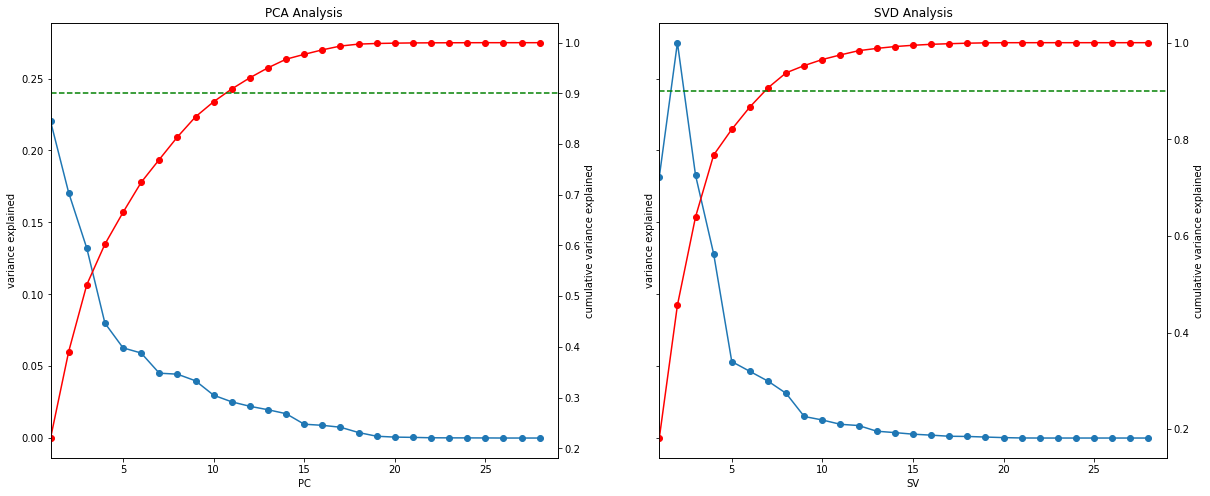

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
plot_variance(PCA(feature.shape[1] - 1).fit(feature),
              'PCA Analysis', ax1, xlabel='PC')
plot_variance(TruncatedSVD(feature_raw.shape[1] - 1).fit(feature_raw),
              'SVD Analysis', ax2, xlabel='SV');

In this report, we have performed a dimensional reduction analysis for the team statistics to reduce the number of dimensions. Comparing two-dimensionality reduction methods, PCA and Truncated SVD, we determined using PCA is better than using Truncated SVD even though SVD achieved an estimated 90% cumulative explained variance with just 7 components where using PCA needed 11 components. Since the height and weight have a high value compared to the other features, using SVD transforms the data biased to height and weight.

In [18]:
pca_avg = PCA(2).fit(feature)
feature_new = pca_avg.transform(feature)

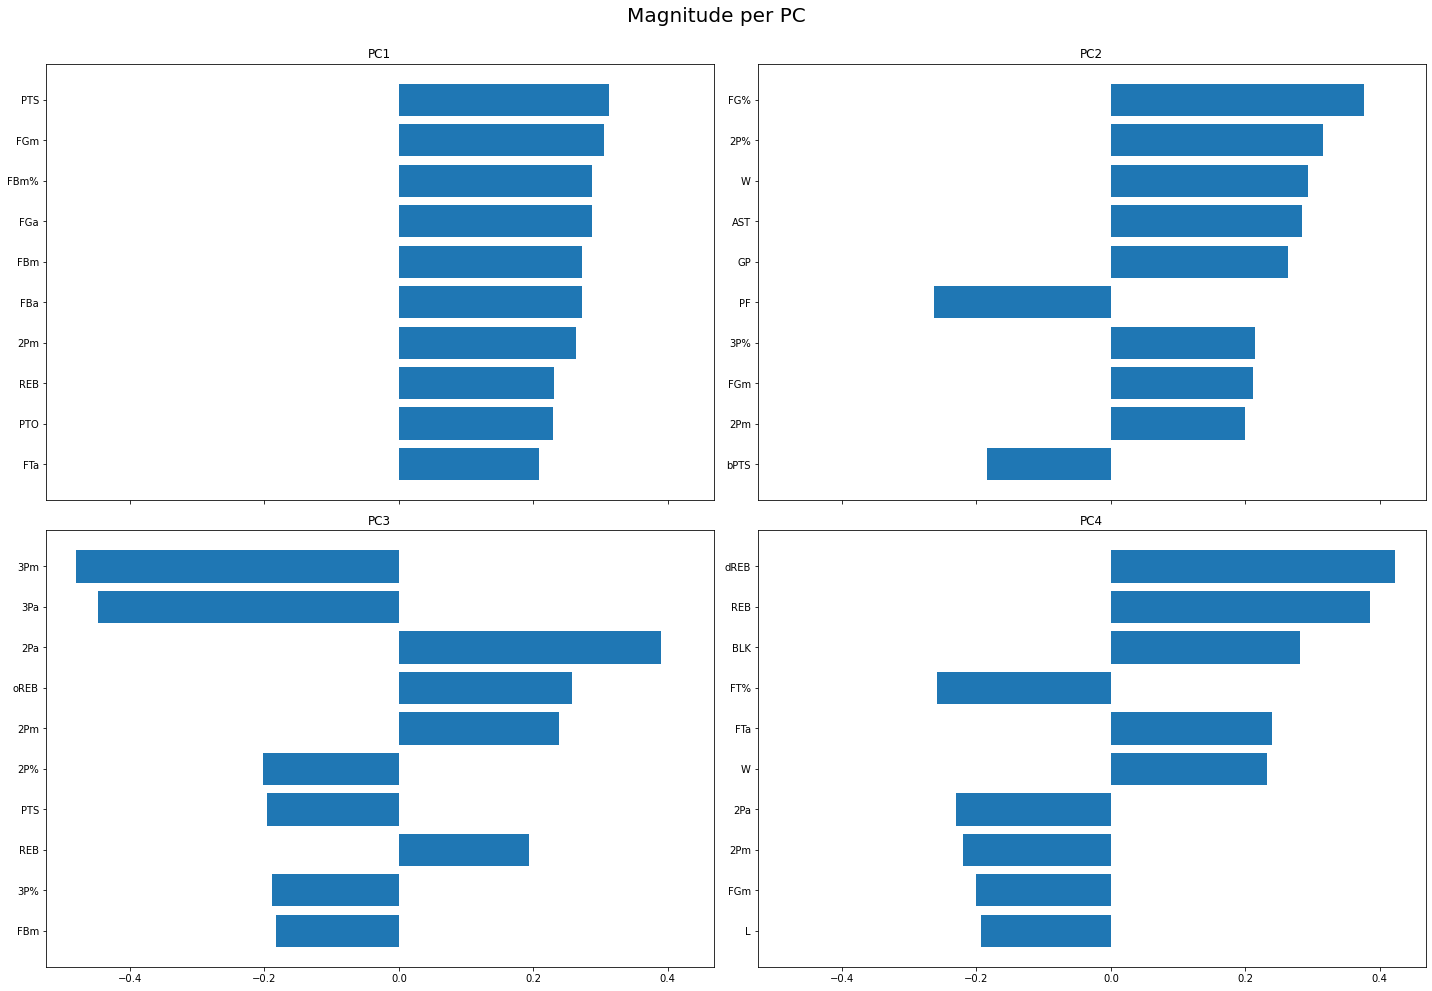

In [19]:
pca_all = PCA(4).fit(feature)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 14),
                                             sharex=True)

ax1.set_title('PC1')
plot_svd_bar(feature_raw.columns, pca_all.components_[0], ax1)

ax2.set_title('PC2')
plot_svd_bar(feature_raw.columns, pca_all.components_[1], ax2)

ax3.set_title('PC3')
plot_svd_bar(feature_raw.columns, pca_all.components_[2], ax3)

ax4.set_title('PC4')
plot_svd_bar(feature_raw.columns, pca_all.components_[3], ax4)

plt.suptitle('Magnitude per PC', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])

Plotting each feature's magnitude in the principal components above, we can observe that average points, field goals made and percentage are among the top features of Principal components 1 and 2.

##### Complete Linkage Method

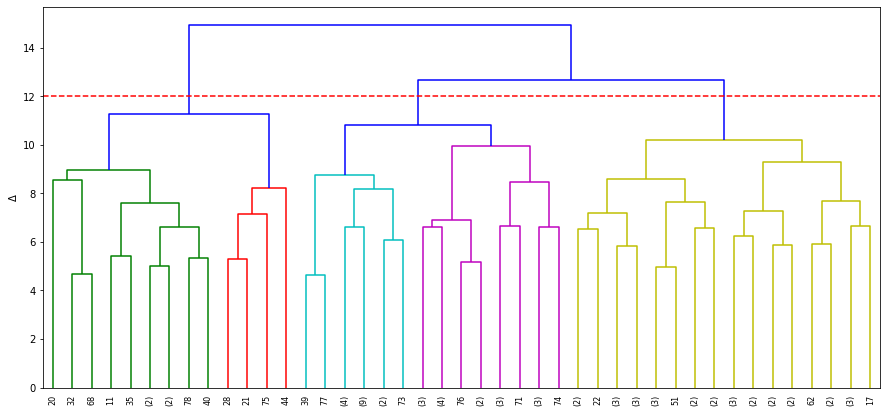

In [20]:
fig, ax = plt.subplots(figsize=(15, 7))
Z_complete = linkage(feature, method='complete', optimal_ordering=True)
ax = plot_dendrogram(Z_complete, ax)
ax.axhline(12, c='r', linestyle='dashed');

##### Result

Comparing different hierarchical clustering methods, we conclude that using Complete Linkage method is the most suitable. The complete linkage method outperforms single and average linkage methods. Plotting the dendrogram of each method shows that Ward's method separated the dataset into 2 groups with the highest distance for every cluster, whereas complete linkage formed 3 groups which is more balanced.

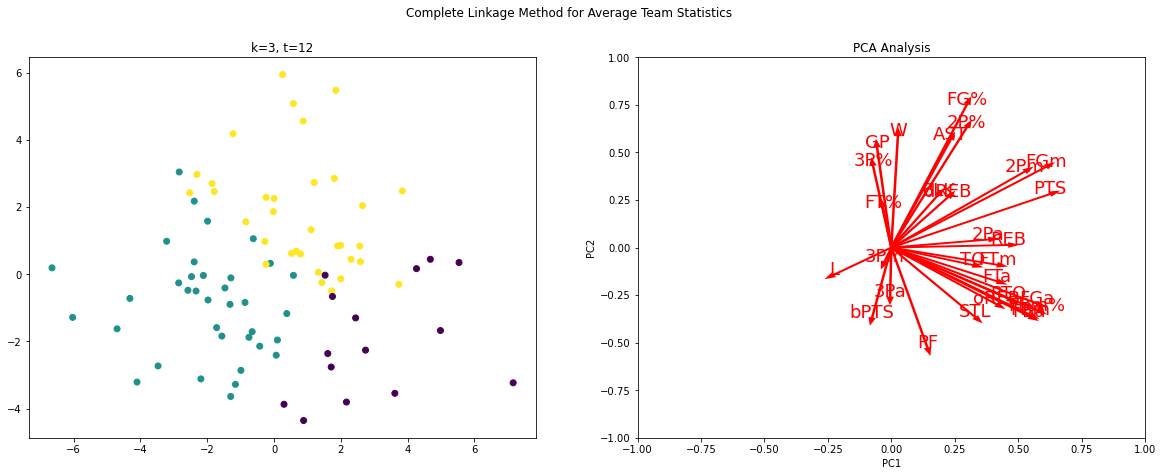

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
ax1 = plot_cluster(feature_new, Z_complete, 12, ax1)
ax2= plot_pca(feature_raw.columns, pca_avg.components_.T, ax2)
ax2.set_title('PCA Analysis')
ax

plt.suptitle("Complete Linkage Method for Average Team Statistics");

Observing the PC1 and PC2 of the decomposed dataset, we can find that the most dominant feature in PC2 is the three-point blocks, rebound and percentage, attempted, made and height. While the most dominant feature in PC1 is the average points, field goals attempted and made. Upon further examining the plot above, we infer that offensive teams that excel with three-point shots most probably does not excel in height or defense attributes like block and rebounds. Since the the assist per game and steals is orthogonal to blocks and rebounds, we can infer that there is no correlation between the pair.

In [22]:
y_cluster = fcluster(Z_complete, t=12, criterion='distance')
df_avg_team_cluster = df_avg_team.copy()
df_avg_team_cluster['cluster'] = y_cluster

##### Radar plot

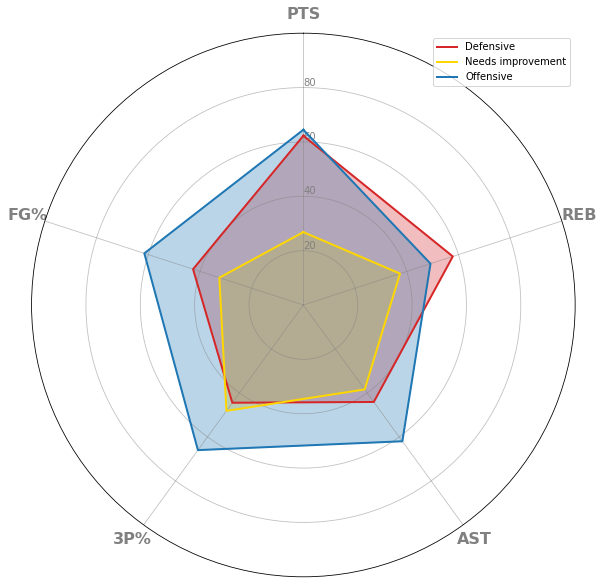

In [24]:
fig = plt.figure(figsize=(20, 10))
ax = plt.gca(polar=True)
df_radar = df_avg_team_cluster[['cluster', 'PTS',
                                'REB', 'AST', '3P%',
                                'FG%']].copy()
plot_radar(df_radar, ax, ['tab:red', 'gold', 'tab:blue'])
plt.legend(['Defensive', 'Needs improvement', 'Offensive'])

The radar plot above exhibits the clustered groups' average statistics for points, rebounds, assist per game, 3-points%, and field goal percentage of each clustered team. We have identified group 2 as teams that need improvement as they have the lowest skillset. However, these teams have a higher 3-points % than group 1, which are identified as defensive teams. Compared to the other clusters, the last group excels significantly on 3-points %, Field Goal %, and assist per game. This group relies heavily relies on teamwork, where 60% of their plays come with an assist.

#### Average team statistics Governor's Cup

In [37]:
m1 = df_avg_team.conference == 'GOV'
m2 = df_avg_team.year.astype(int) < 2020
df_avg_team_gov = df_avg_team.loc[m1 & m2].copy()
feature_raw = df_avg_team_gov.drop(['year', 'conference', 'team_name'],
                                   axis=1)
feature = StandardScaler().fit_transform(feature_raw)

##### Explore Dimensionality Reduction

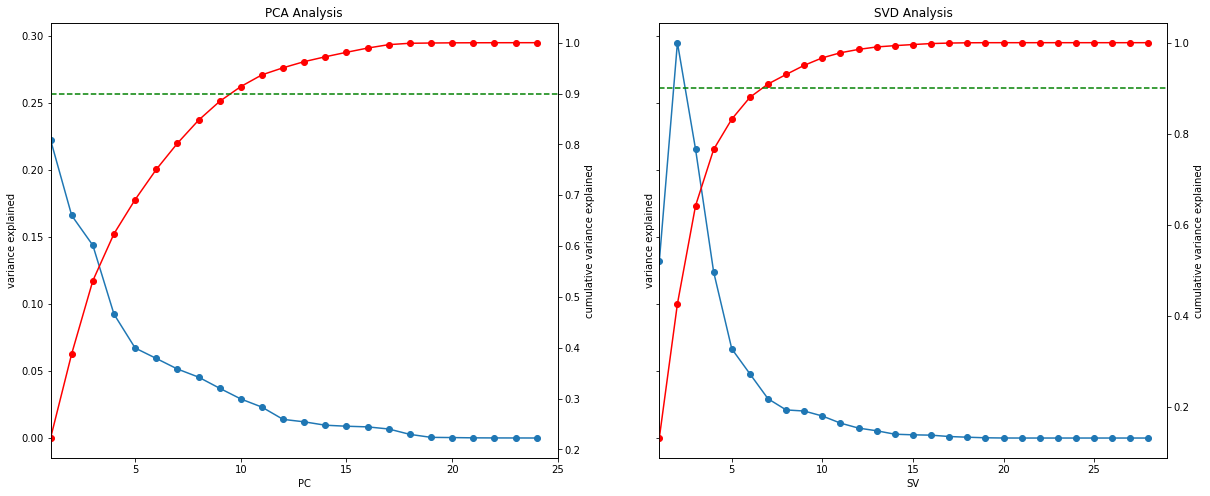

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
plot_variance(PCA(24).fit(feature),
              'PCA Analysis', ax1, xlabel='PC')
plot_variance(TruncatedSVD(feature_raw.shape[1] - 1).fit(feature_raw),
              'SVD Analysis', ax2, xlabel='SV');

In this report, we have performed a dimensional reduction analysis for the team statistics to reduce the number of dimensions. Comparing two-dimensionality reduction methods, PCA and Truncated SVD, we determined using PCA is better than using Truncated SVD even though SVD achieved an estimated 90% cumulative explained variance with just 7 components where using PCA needed 11 components. Since the height and weight have a high value compared to the other features, using SVD transforms the data biased to height and weight.

In [39]:
pca_avg = PCA(2).fit(feature)
feature_new = pca_avg.transform(feature)

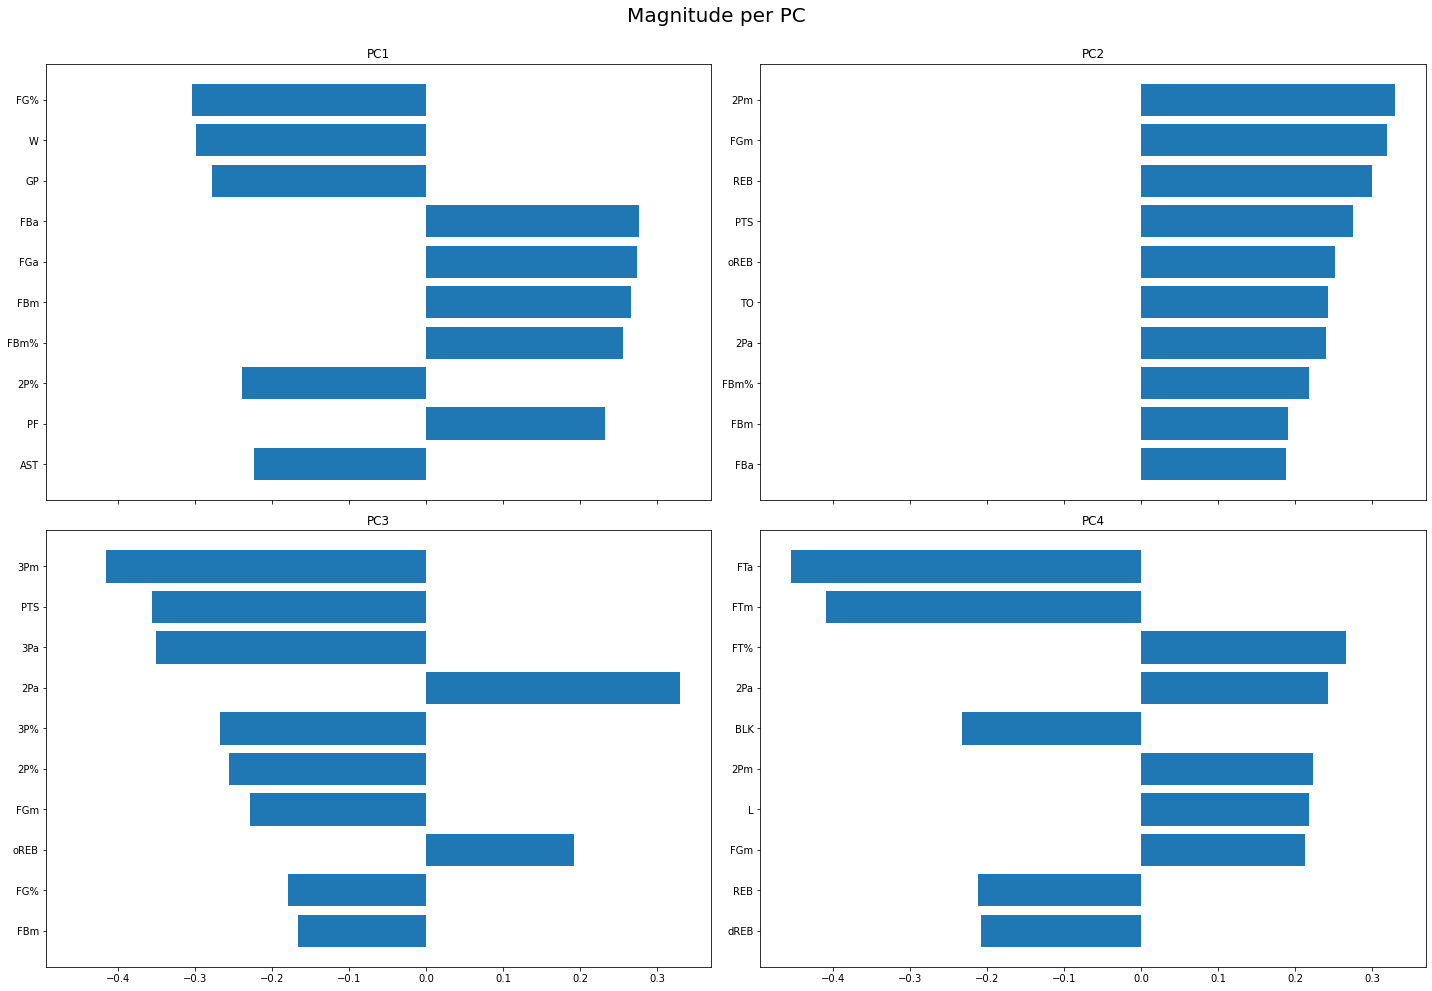

In [40]:
pca_all = PCA(4).fit(feature)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 14),
                                             sharex=True)

ax1.set_title('PC1')
plot_svd_bar(feature_raw.columns, pca_all.components_[0], ax1)

ax2.set_title('PC2')
plot_svd_bar(feature_raw.columns, pca_all.components_[1], ax2)

ax3.set_title('PC3')
plot_svd_bar(feature_raw.columns, pca_all.components_[2], ax3)

ax4.set_title('PC4')
plot_svd_bar(feature_raw.columns, pca_all.components_[3], ax4)

plt.suptitle('Magnitude per PC', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])

Plotting each feature's magnitude in the principal components above, we can observe that 2 points made, field goals made and percentage, and average team wins are among the top features of Principal components 1 and 2.

##### Ward's Method

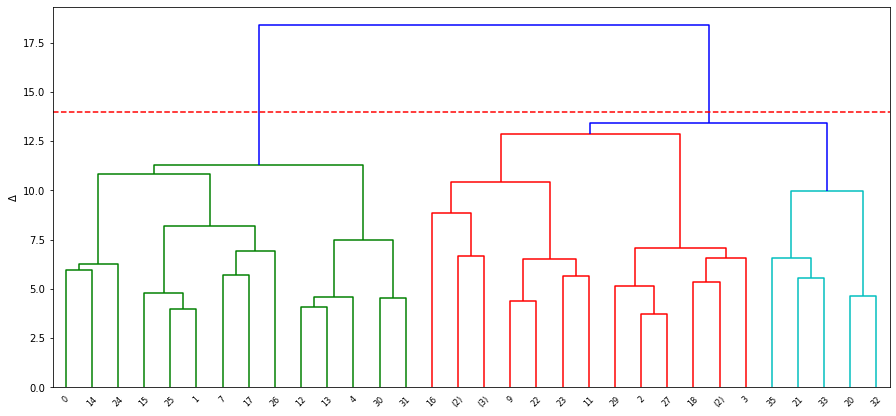

In [41]:
fig, ax = plt.subplots(figsize=(15, 7))
Z_ward = linkage(feature, method='ward', optimal_ordering=True)
ax = plot_dendrogram(Z_ward, ax)
ax.axhline(14, c='r', linestyle='dashed');

##### Result

Comparing different hierarchical clustering methods, we conclude that using Complete Linkage method is the most suitable. The complete linkage method outperforms single and average linkage methods. Plotting the dendrogram of each method shows that Ward's method separated the dataset into 2 groups with the highest distance for every cluster, whereas complete linkage formed 3 groups which is more balanced and lower delta between clusters.

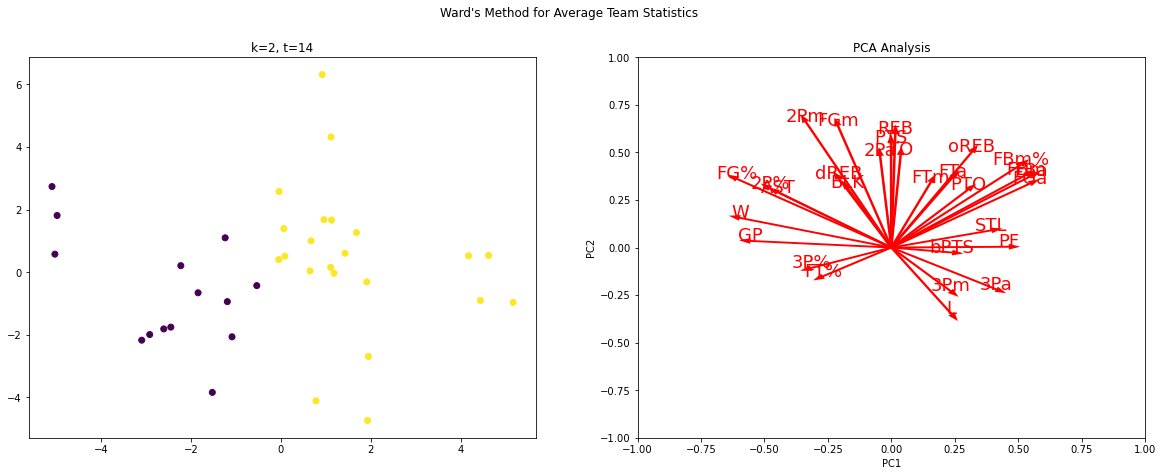

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
ax1 = plot_cluster(feature_new, Z_ward, 14, ax1)
ax2= plot_pca(feature_raw.columns, pca_avg.components_.T, ax2)
ax2.set_title('PCA Analysis')

plt.suptitle("Ward's Method for Average Team Statistics");

Observing the PC1 and PC2 of the decomposed dataset, we find the average games the team has played and win, personal foul, and steals are the most dominant feature in principal component 1. In comparison, the most dominant feature of PC2 is the average number of rebounds, turnovers, and 2 points made by the player. Upon further investigation, the vector GP and W is heading towards the left direction while the PF head towards the right. We can infer that these two features are negatively correlated where if a team has a high number of a personal foul, those teams would most likely have fewer wins and games played. Observing other vectors that have this kind of relationship is the 2-points made and the number of losses of the team. We can also see that 2-Pm is also negatively correlated with 3-Pm. Teams that excel at earning scores at a score range mostly do not have good 3 point shooters.

In [43]:
y_cluster = fcluster(Z_ward, t=14, criterion='distance')
df_avg_team_gov['cluster'] = y_cluster

##### Radar plot

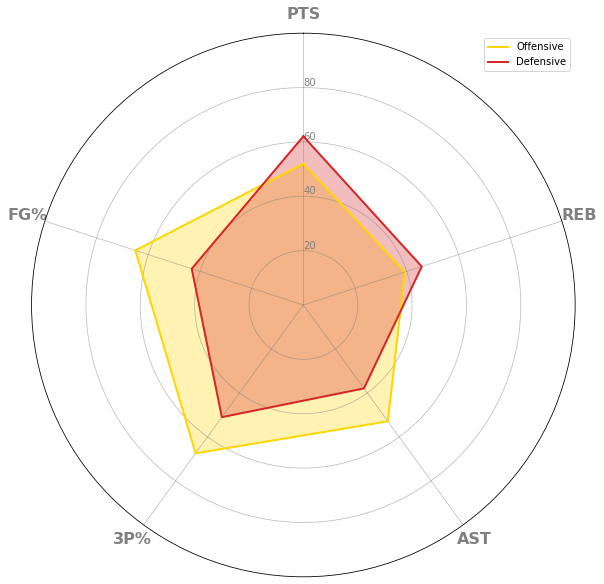

In [45]:
fig = plt.figure(figsize=(20, 10))
ax = plt.gca(polar=True)
df_radar = df_avg_team_gov[['cluster', 'PTS',
                            'REB', 'AST', '3P%',
                            'FG%']].copy()
plot_radar(df_radar, ax, ['gold', 'tab:red'])
plt.legend(['Offensive', 'Defensive']);

The radar plot above exhibits the clustered groups' average statistics for points, rebounds, assist per game, 3-points%, and field goal percentage of each clustered team. We have identified cluster 2 as defensive teams as they have a higher  number of rebounds. In comparison, the last group we have identified are offensive teams that has the highest field goal, assist, and 3-points percentage.

#### Average team statistics Commisioner's Cup

In [104]:
m1 = df_avg_team.conference == 'COM'
m2 = df_avg_team.year.astype(int) < 2020
df_avg_team_com = df_avg_team.loc[m1 & m2].copy()
feature_raw = df_avg_team_com.drop(['year', 'conference', 'team_name'],
                                   axis=1)
feature = StandardScaler().fit_transform(feature_raw)

##### Explore Dimensionality Reduction

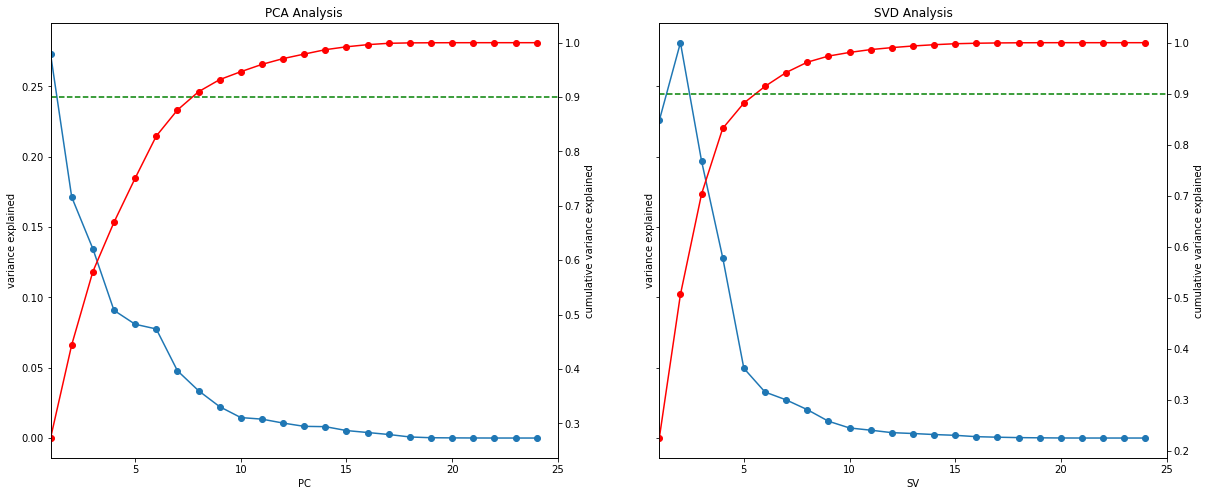

In [105]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
plot_variance(PCA(24).fit(feature),
              'PCA Analysis', ax1, xlabel='PC')
plot_variance(TruncatedSVD(feature_raw.shape[1] - 1).fit(feature_raw),
              'SVD Analysis', ax2, xlabel='SV');

In this report, we have performed a dimensional reduction analysis for the team statistics to reduce the number of dimensions. Comparing two-dimensionality reduction methods, PCA and Truncated SVD, we determined using PCA is better than using Truncated SVD even though SVD achieved an estimated 90% cumulative explained variance with just 7 components where using PCA needed 11 components. Since the height and weight have a high value compared to the other features, using SVD transforms the data biased to height and weight.

In [106]:
pca_avg = PCA(2).fit(feature)
feature_new = pca_avg.transform(feature)

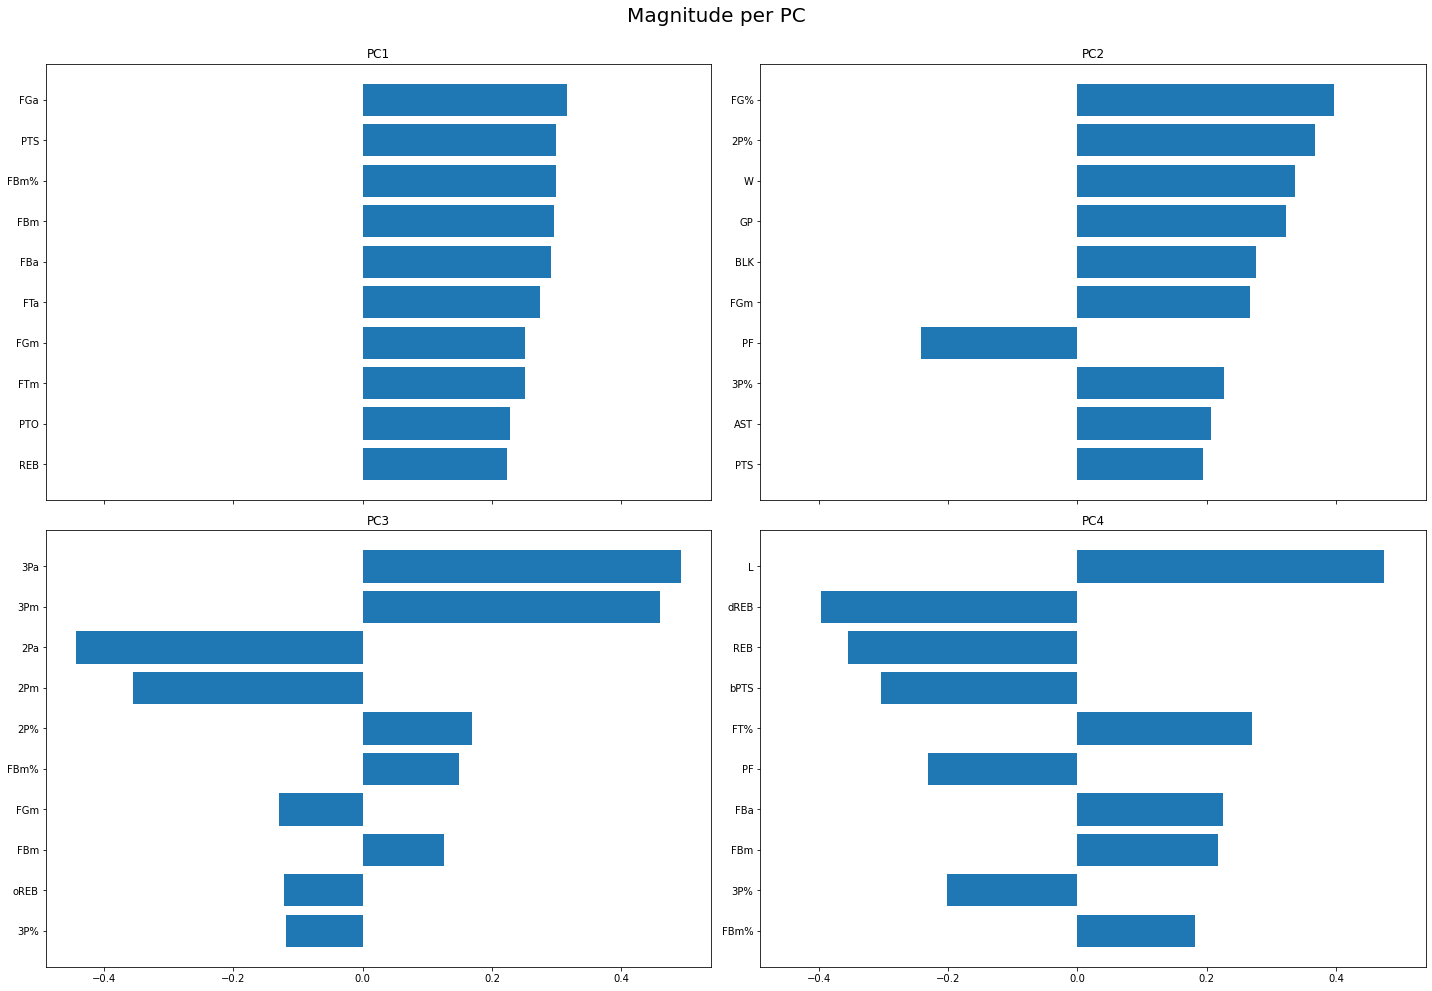

In [107]:
pca_all = PCA(4).fit(feature)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 14),
                                             sharex=True)

ax1.set_title('PC1')
plot_svd_bar(feature_raw.columns, pca_all.components_[0], ax1)

ax2.set_title('PC2')
plot_svd_bar(feature_raw.columns, pca_all.components_[1], ax2)

ax3.set_title('PC3')
plot_svd_bar(feature_raw.columns, pca_all.components_[2], ax3)

ax4.set_title('PC4')
plot_svd_bar(feature_raw.columns, pca_all.components_[3], ax4)

plt.suptitle('Magnitude per PC', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])

Plotting each feature's magnitude in the principal components above, we can observe that 2 points made, field goals made and percentage, and average team wins are among the top features of Principal components 1 and 2.

##### Ward's Method

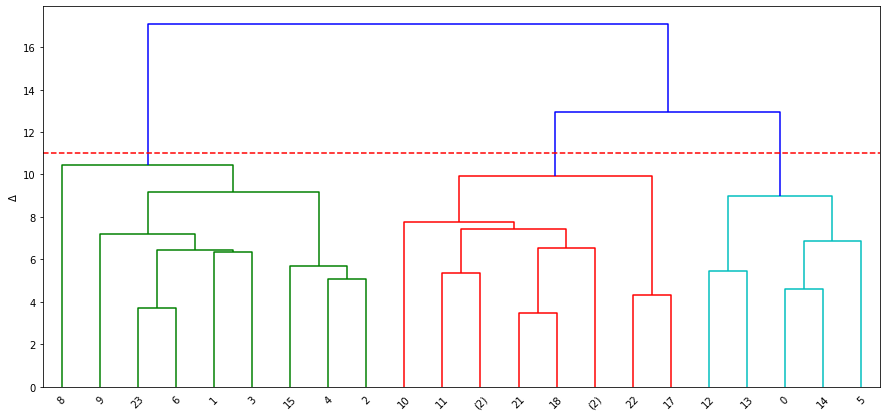

In [108]:
fig, ax = plt.subplots(figsize=(15, 7))
Z_ward = linkage(feature, method='ward', optimal_ordering=True)
ax = plot_dendrogram(Z_ward, ax)
ax.axhline(11, c='r', linestyle='dashed');

##### Result

Comparing different hierarchical clustering methods, we conclude that using Ward's method is the most suitable. Ward's method outperforms single, complete, and average linkage methods. Although the Completed Linkage method came close to Ward's method, it failed to separate the cluster into balanced groups. Plotting the dendrogram of each method shows that Ward's method divided the dataset into three groups with the highest distance for every cluster, whereas other methods failed to do so.

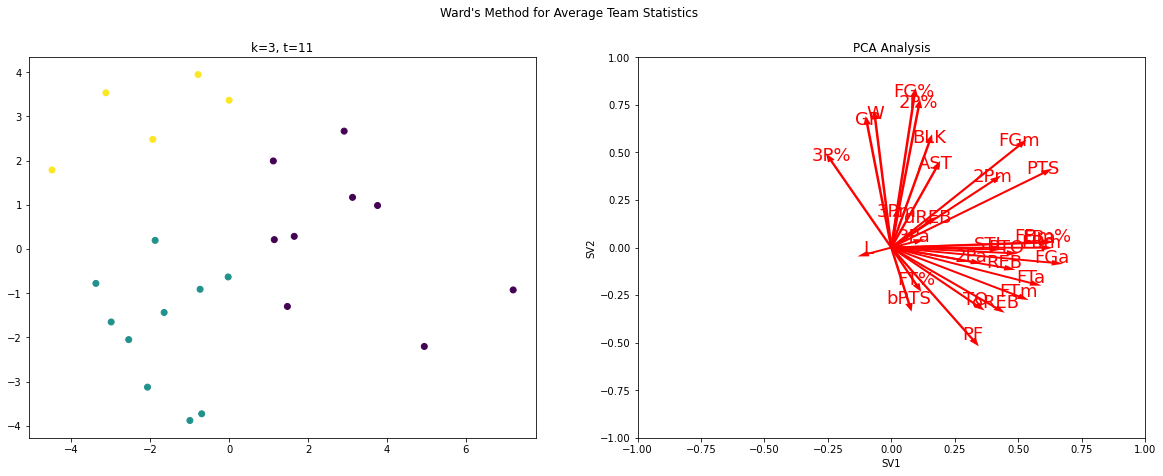

In [111]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
ax1 = plot_cluster(feature_new, Z_ward, 11, ax1)
ax2= plot_svd(feature_raw.columns, pca_avg.components_.T, ax2)
ax2.set_title('PCA Analysis')

plt.suptitle("Ward's Method for Average Team Statistics");

Observing the PC1 and PC2 of the decomposed dataset, we find the average games the team win, field goal, and 2-points percentage are the most dominant feature in principal component 2.  In comparison, the most dominant feature of principal component 1 is the average points earned per team and field goal attempted, made, and percentage. From the plot above, we infer that the 3-points percentage and personal foul are negatively correlated with each other as the two vectors have opposite directions. Teams with a higher number of 3-point shooters tend to have lesser fouls as plays inside the three-point line are more intense.

In [112]:
y_cluster = fcluster(Z_ward, t=11, criterion='distance')
df_avg_team_com['cluster'] = y_cluster

##### Radar plot

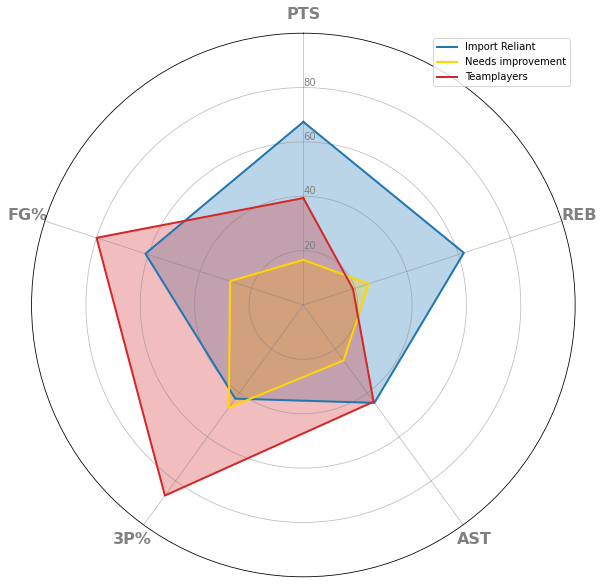

In [115]:
fig = plt.figure(figsize=(20, 10))
ax = plt.gca(polar=True)
df_radar = df_avg_team_com[['cluster', 'PTS',
                            'REB', 'AST', '3P%',
                            'FG%']].copy()
plot_radar(df_radar, ax, ['tab:blue', 'gold', 'tab:red'])
plt.legend(['Import Reliant', 'Needs improvement', 'Teamplayers']);

The radar plot above exhibits the clustered groups' average statistics for points, rebounds, assist per game, 3-points%, and field goal percentage of each clustered team. We have identified cluster 2 as teams that need improvement as they have the lowest skillset. However, these teams have a higher 3-points % than group 1, which are identified as import reliant teams. Import reliant teams have the highest percentage of rebounds with a huge gap of 40% from other groups, and average points per game of 60%. In comparison, the last group we have identified are team players since they have the highest field goal and 3-points percentage.

#### Average team statistics Philippine Cup

In [116]:
m1 = df_avg_team.conference == 'PH'
m2 = df_avg_team.year.astype(int) < 2020
df_avg_team_ph = df_avg_team.loc[m1 & m2].copy()
feature_raw = df_avg_team_ph.drop(['year', 'conference', 'team_name'],
                                   axis=1)
feature = StandardScaler().fit_transform(feature_raw)

##### Explore Dimensionality Reduction

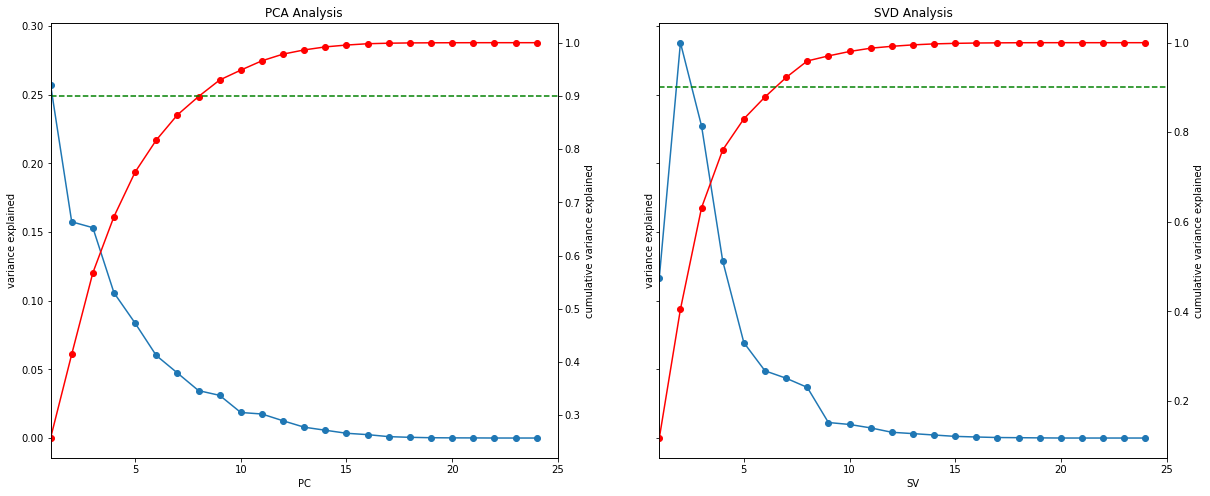

In [117]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
plot_variance(PCA(24).fit(feature),
              'PCA Analysis', ax1, xlabel='PC')
plot_variance(TruncatedSVD(feature_raw.shape[1] - 1).fit(feature_raw),
              'SVD Analysis', ax2, xlabel='SV');

In this report, we have performed a dimensional reduction analysis for the team statistics to reduce the number of dimensions. Comparing two-dimensionality reduction methods, PCA and Truncated SVD, we determined using PCA is better than using Truncated SVD even though SVD achieved an estimated 90% cumulative explained variance with just 6 components where using PCA needed 8 components. Since the height and weight have a high value compared to the other features, using SVD transforms the data biased to height and weight.

In [118]:
pca_avg = PCA(2).fit(feature)
feature_new = pca_avg.transform(feature)

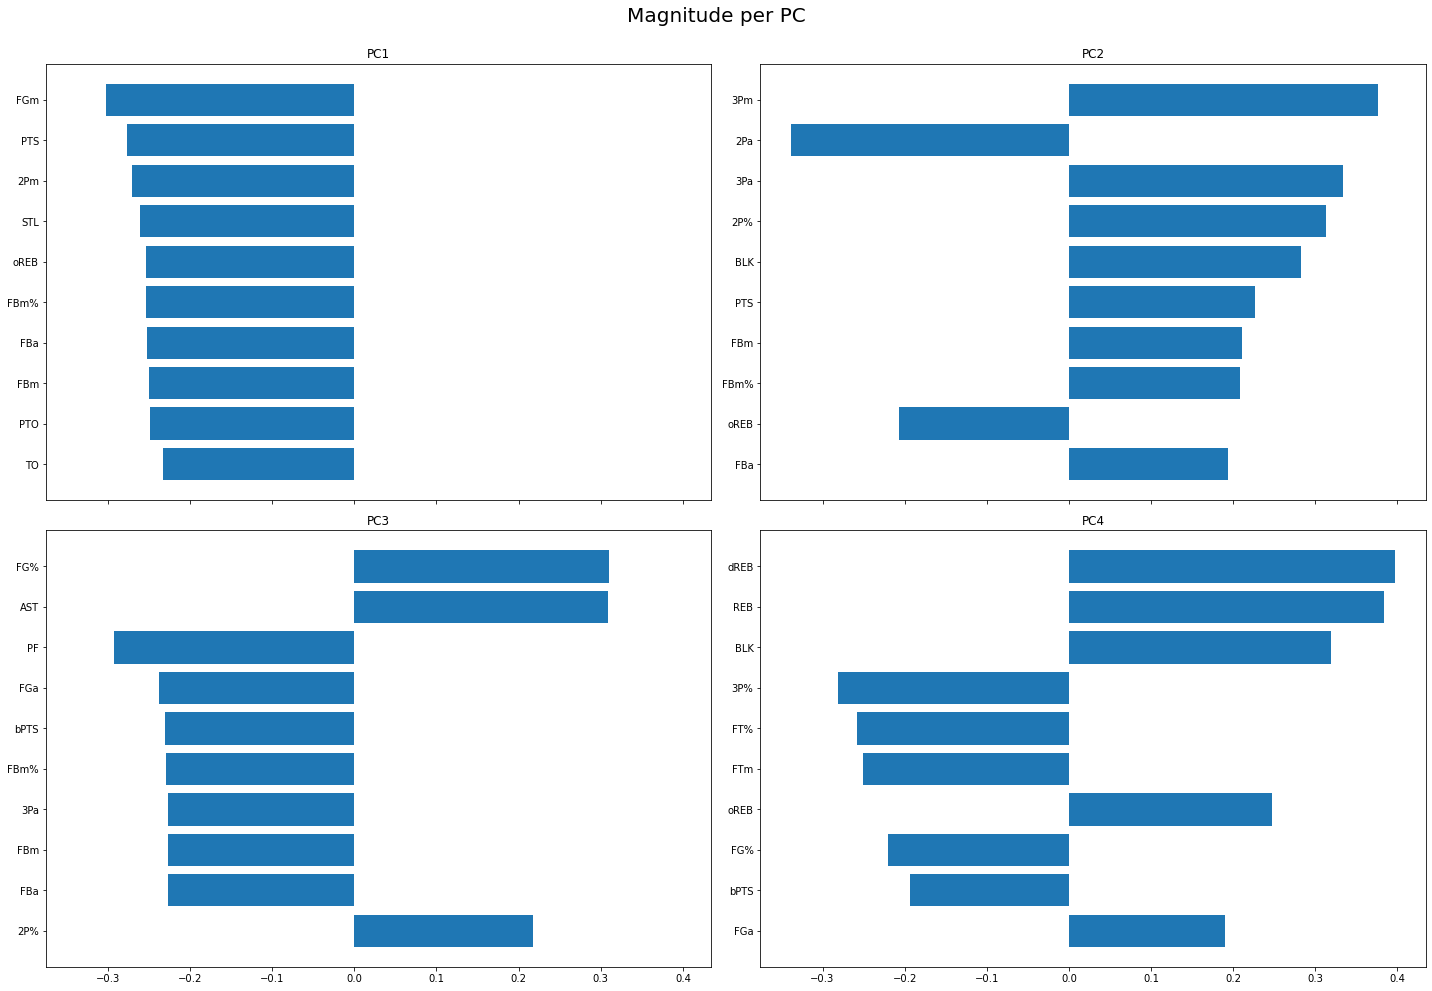

In [119]:
pca_all = PCA(4).fit(feature)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 14),
                                             sharex=True)

ax1.set_title('PC1')
plot_svd_bar(feature_raw.columns, pca_all.components_[0], ax1)

ax2.set_title('PC2')
plot_svd_bar(feature_raw.columns, pca_all.components_[1], ax2)

ax3.set_title('PC3')
plot_svd_bar(feature_raw.columns, pca_all.components_[2], ax3)

ax4.set_title('PC4')
plot_svd_bar(feature_raw.columns, pca_all.components_[3], ax4)

plt.suptitle('Magnitude per PC', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])

Plotting each feature's magnitude in the principal components above, we can observe that 3-points made and attempted, 2 points made and attempted, field goals made, and average points per team are among the top features of Principal components 1 and 2. Further investigating the magnitudes in PC2, the 2-points vector has a negative magnitude heading towards a different direction of 3-points made.

##### Ward's Method

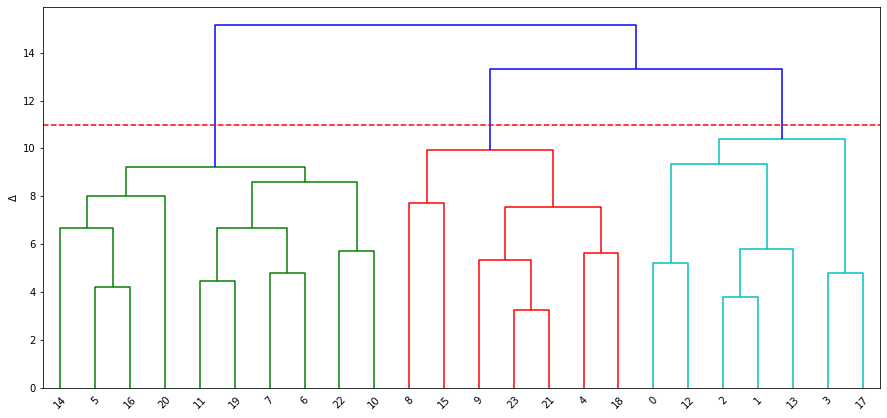

In [120]:
fig, ax = plt.subplots(figsize=(15, 7))
Z_ward = linkage(feature, method='ward', optimal_ordering=True)
ax = plot_dendrogram(Z_ward, ax)
ax.axhline(11, c='r', linestyle='dashed');

##### Result

Comparing different hierarchical clustering methods, we conclude that using Ward's method is the most suitable. Ward's method outperforms single, complete, and average linkage methods. Although the Completed Linkage method came close to Ward's method, it failed to separate the cluster into balanced groups. Plotting the dendrogram of each method shows that Ward's method divided the dataset into three groups with the highest distance for every cluster, whereas other methods failed to do so.

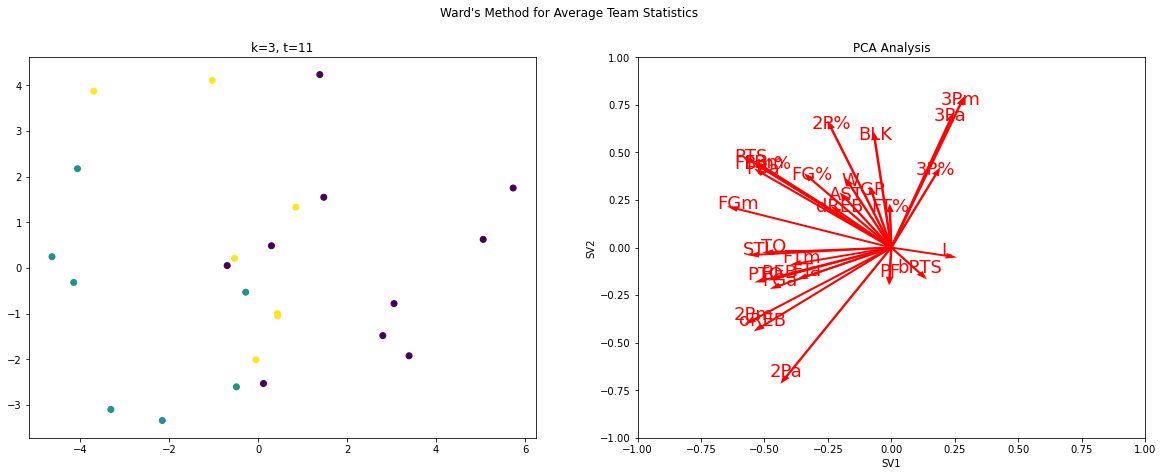

In [102]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
ax1 = plot_cluster(feature_new, Z_ward, 11, ax1)
ax2= plot_svd(feature_raw.columns, pca_avg.components_.T, ax2)
ax2.set_title('PCA Analysis')

plt.suptitle("Ward's Method for Average Team Statistics");

Observing the PC1 and PC2 of the decomposed dataset, we find the 3-points made, attempted,  and the percentage is the most dominant feature in principal component 2.  In comparison, the most dominant feature of principal component 2 is the steals and turnovers the team has committed. From the plot above, we infer that the 3-points percentage and 2-points attempted are negatively correlated with each other as the two vectors have opposite directions. Teams with a higher number of 3-point shooters tend to have lesser players who excel inside the 3-point line.

In [124]:
y_cluster = fcluster(Z_ward, t=11, criterion='distance')
df_avg_team_ph['cluster'] = y_cluster

##### Radar plot

In [125]:
m1 = df_avg_team_ph.cluster == 1
m2 = df_avg_team_ph.year == '2019'
df_avg_team_ph.loc[m1 & m2, ['team_name', 'cluster', 'PTS',
                            'REB', 'AST', '3P%',
                            'FG%']]

team_name  cluster    PTS    REB    AST   3P%   FG%
74       ROS        1  87.95  45.58  18.84  0.32  0.39
76       TNT        1  90.64  49.14  20.00  0.28  0.39
79       ALA        1  86.38  46.69  18.15  0.31  0.40
80       NLX        1  92.25  48.67  24.67  0.34  0.42
82       MER        1  90.00  47.91  21.18  0.29  0.40

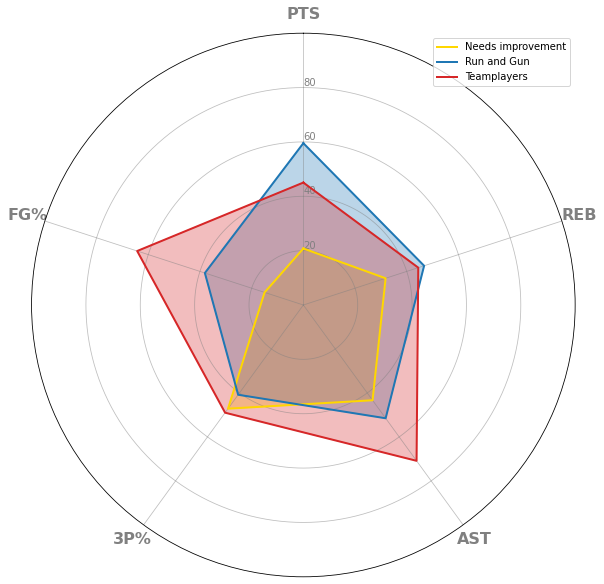

In [128]:
fig = plt.figure(figsize=(20, 10))
ax = plt.gca(polar=True)
df_radar = df_avg_team_ph[['cluster', 'PTS',
                           'REB', 'AST', '3P%',
                           'FG%']].copy()
plot_radar(df_radar, ax, ['gold', 'tab:blue', 'tab:red'])
plt.legend(['Needs improvement', 'Run and Gun', 'Teamplayers']);

The radar plot above exhibits the clustered groups' average statistics for points, rebounds, assist per game, 3-points%, and field goal percentage of each clustered team. We have identified cluster 2 as teams that need improvement as they have the lowest skillset. However, these teams have a higher 3-points % than group 1, which are identified as run and gun teams. Run and gun teams have the highest percentage of rebounds, and average points per game of 60%. In comparison, the last group we have identified as team players has the highest assist, field goal and 3-points percentage. Teams who exercise teamplays has an assist and field goal percentage higher than 60%

### Hierarchical Clustering of Players By Conference using Ward's method

In [25]:
df_avg_player = fetcher.get_avg_player()
df_avg_player = df_avg_player.loc[df_avg_player.year.astype(int) < 2020]

#### All average player statistics

In [27]:
feature_raw = df_avg_player.drop(['year', 'conference', 'player_name',
                                  'team_name', 'pos', 'j_number'], axis=1)
feature = StandardScaler().fit_transform(feature_raw)
lbl_enc = LabelEncoder().fit(df_avg_player.pos)
target = lbl_enc.transform(df_avg_player.pos)

##### Explore Dimensionality Reduction

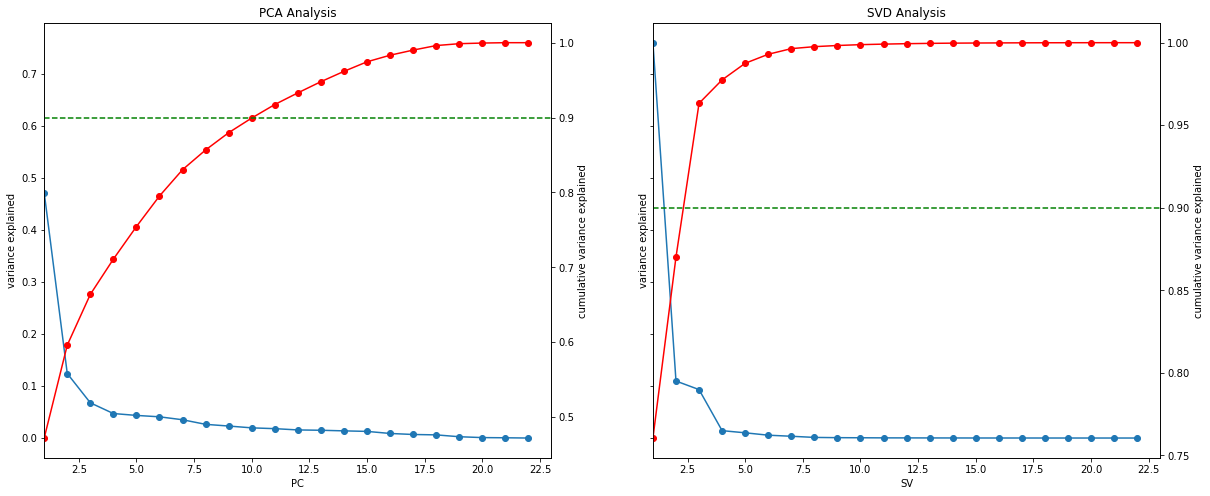

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), sharey=True,
                               sharex=True)
plot_variance(PCA(feature.shape[1] - 1).fit(feature),
              'PCA Analysis', ax1, xlabel='PC')
svd_all = TruncatedSVD(feature_raw.shape[1] - 1).fit(feature_raw)
plot_variance(svd_all, 'SVD Analysis', ax2, xlabel='SV');

In this report, we have performed a dimensional reduction analysis for the team statistics to reduce the number of dimensions. Comparing two-dimensionality reduction methods, PCA and Truncated SVD, we determined using PCA is better than using Truncated SVD even though SVD achieved an estimated 97% cumulative explained variance with just four components where using PCA needed nine components. Since the height and weight have a high value compared to the other features, using SVD transforms the data biased to height and weight.

In [29]:
svd_avg = TruncatedSVD(2).fit(feature)
feature_new = svd_avg.transform(feature)

In [30]:
pca_avg = PCA(2).fit(feature)
feature_new = pca_avg.transform(feature)

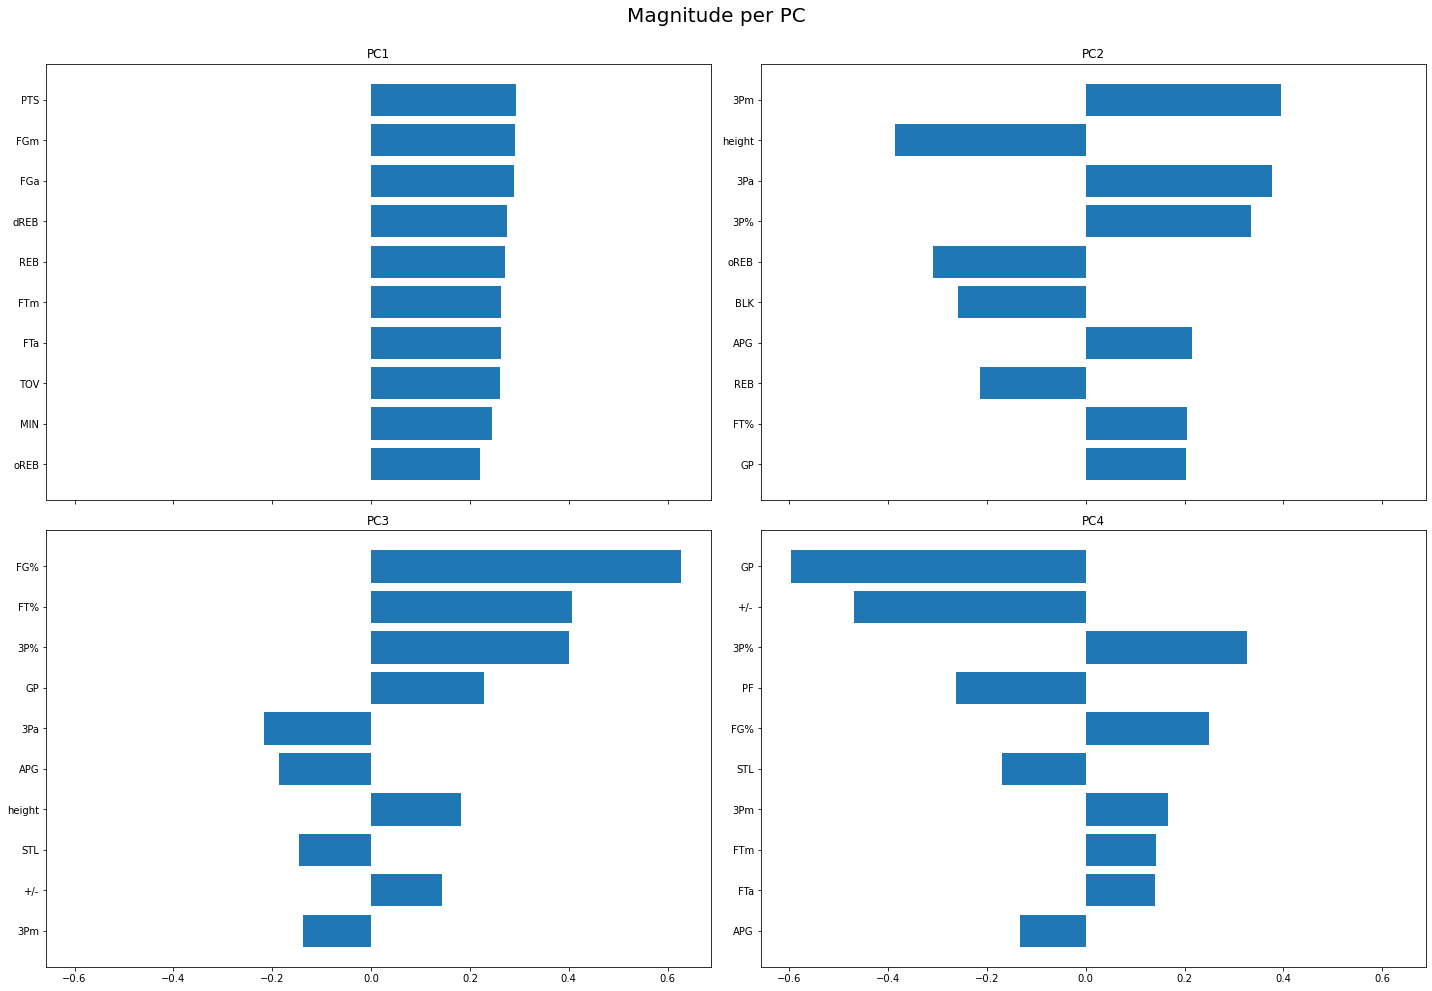

In [31]:
pca_all = PCA(4).fit(feature)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 14),
                                             sharex=True)

ax1.set_title('PC1')
plot_svd_bar(feature_raw.columns, pca_all.components_[0], ax1)

ax2.set_title('PC2')
plot_svd_bar(feature_raw.columns, pca_all.components_[1], ax2)

ax3.set_title('PC3')
plot_svd_bar(feature_raw.columns, pca_all.components_[2], ax3)

ax4.set_title('PC4')
plot_svd_bar(feature_raw.columns, pca_all.components_[3], ax4)

plt.suptitle('Magnitude per PC', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])

Plotting each feature's magnitude in the principal components above, we can observe that average points, field goals made, three-points made, and height are among the top features of Principal components 1 and 2. We can infer that most of the features dominant in PC1 are offensive attributes, while the majority dominant features in PC2 relates to defense.

##### Ward's Method

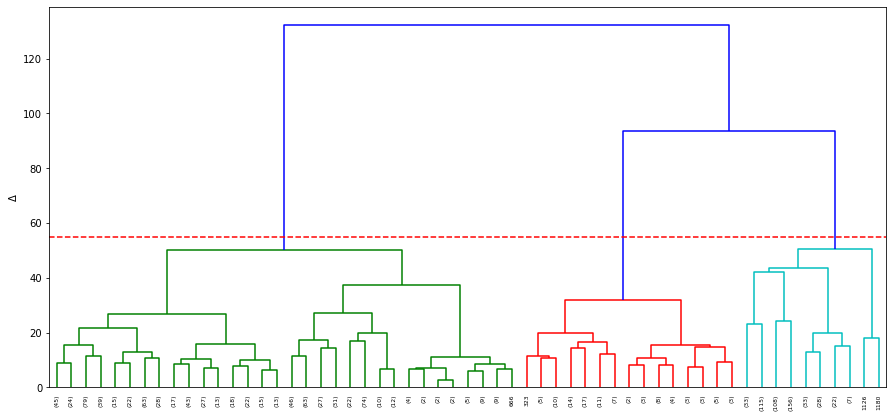

In [32]:
fig, ax = plt.subplots(figsize=(15, 7))
Z_ward = linkage(feature, method='ward', optimal_ordering=True)
ax = plot_dendrogram(Z_ward, ax)
ax.axhline(55, c='r', linestyle='dashed');

##### Result

##### Choosing the right threshold

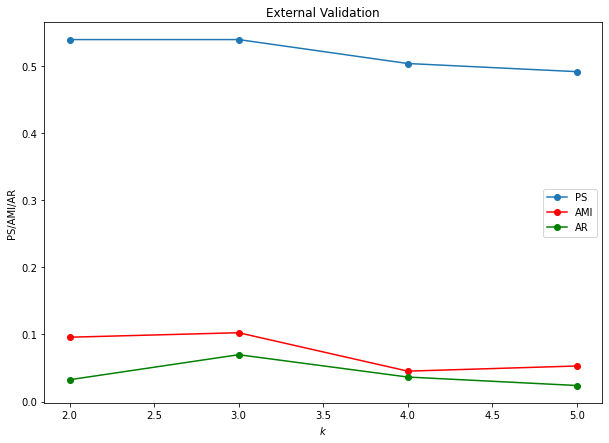

In [36]:
fig, ax = plt.subplots(figsize=(10, 7))
res = agglo_cluster_range(feature, 'ward',
                          t_start=40, t_stop=55, actual=target)
plot_external(res['ps'], res['amis'], res['ars'], ax)
ax.set_title('External Validation')
plt.show()

Comparing different hierarchical clustering methods, we conclude that using Ward's method is the most suitable. Ward's method outperforms single, complete, and average linkage methods. Plotting the dendrogram of each method shows that Ward's method separated the dataset into three groups with the highest distance for every cluster, whereas other methods failed to do so. In validating the clusters with position of each player, we can infer that 3 cluster is the ideal number of groups since it has the highest adjusted mutual information and adjusted rand index.

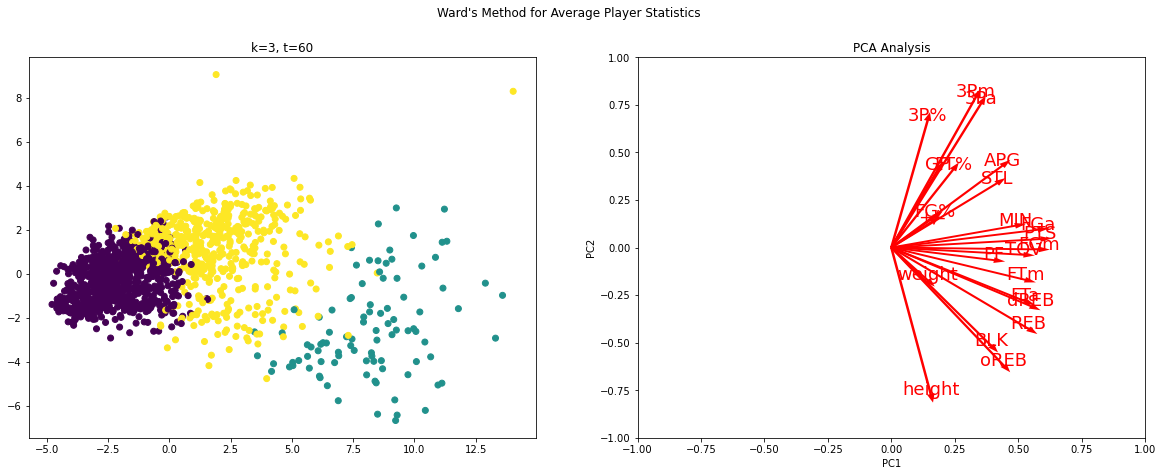

In [73]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
ax1 = plot_cluster(feature_new, Z_ward, 60, ax1)
ax2= plot_svd(feature_raw.columns, pca_avg.components_.T, ax2)
ax2.set_title('PCA Analysis')

plt.suptitle("Ward's Method for Average Player Statistics");

Observing the PC1 and PC2 of the decomposed dataset, we can find that the most dominant feature in PC2 is the three-point percentage, attempted, made, and height. While the most dominant feature in PC1 is the average points, field goals attempted and made. Upon further examining the plot above, we infer that offensive players that excel with three-point shots most probably not excel in height or defense attributes like block and rebounds.

In [74]:
y_cluster = fcluster(Z_ward, t=60, criterion='distance')
df_avg_player_cluster = df_avg_player.copy()
df_avg_player_cluster['cluster'] = y_cluster

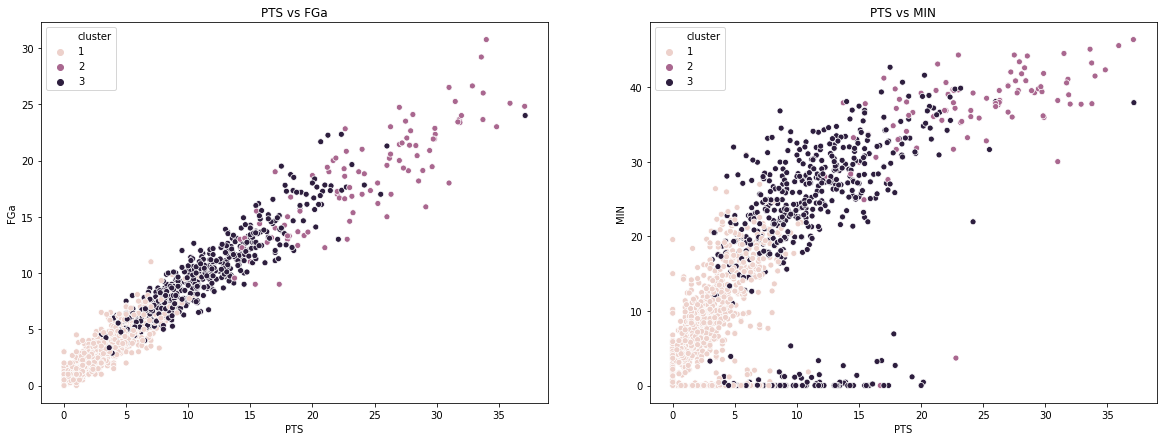

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

ax1.set_title('PTS vs FGa')
sns.scatterplot(x='PTS', y='FGa', hue='cluster', legend='full',
                data=df_avg_player_cluster, ax=ax1)

ax2.set_title('PTS vs MIN')
sns.scatterplot(x='PTS', y='MIN', hue='cluster', legend='full',
                data=df_avg_player_cluster, ax=ax2)
plt.show()

From the plot above, as the average of points and FGa attempted increases, the predicted group of the cluster change as well. Most of the players who have been clustered in group 1 have minimal attempts to make a score and earn points. We can infer that players that have been clustered in this group are benchwarmers or defensive players. While players who belong in group 2 have high field goal attempts and points made are a imports and offensive players.  Upon further investigation, we can see that the identified imports in cluster 2 have the longest playing time in the court. In contrast, players who are identified benchwarmers have the shortest time in the court.

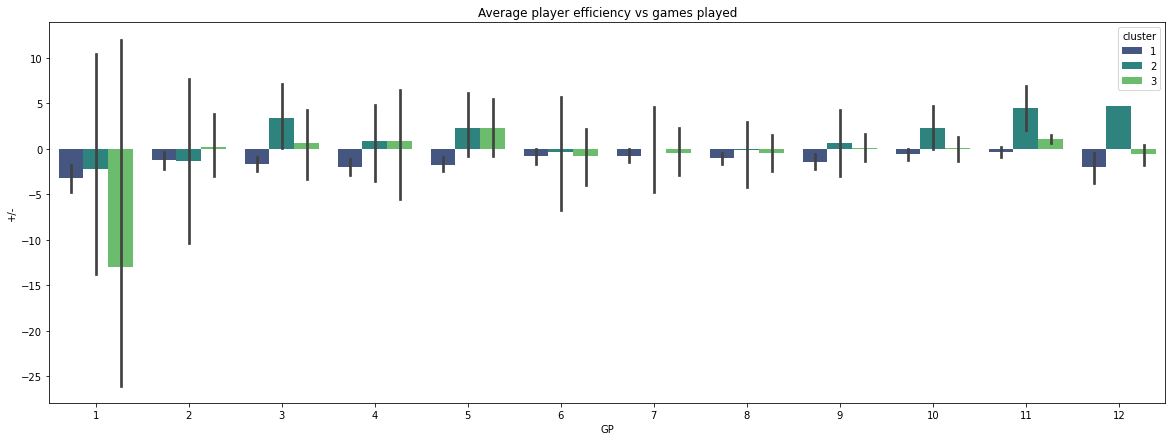

In [22]:
plt.subplots(figsize=(20, 7))
sns.barplot(x='GP', y='+/-', hue='cluster',
            estimator=np.mean, palette='viridis',
            data=df_avg_player_cluster)
plt.title('Average player efficiency vs games played')
plt.show()

Based on the plot above, we can see that players who have a few numbers of games played have low-performance efficiency. Although the number of games played by the player increases, we can see an improvement in player efficiency from 3 to 5, although with a sudden decrease for 6 to 9 games. The player efficiency increases again for those who have played 10 to 12 games. Based on these results, we can infer that teams with great players having high offensive and defensive attributes have the highest number of games. Teams with such players are not eliminated in the early round, thus a higher chance of becoming champions. In contrast, teams with players with negative player efficiency (High number of missed field goals and free throws, and turnover) tend to be eliminated at the start of the season. We can also see that players with the highest player efficiency belong in group 2 identified as imports.

##### Radar plot

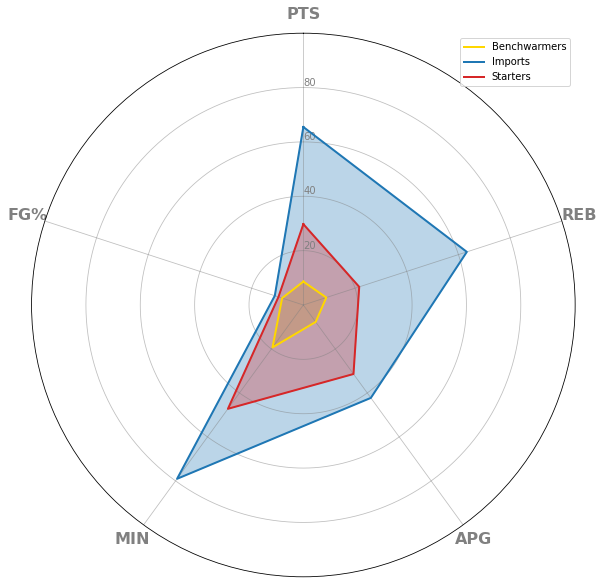

In [24]:
fig = plt.figure(figsize=(20,10))
ax = plt.gca(polar=True)
df_radar = df_avg_player_cluster[['cluster','PTS',
                                  'REB', 'APG', 'MIN',
                                  'FG%']].copy()
plot_radar(df_radar, ax, ['gold', 'tab:blue', 'tab:red'])
plt.legend(['Benchwarmers', 'Imports', 'Starters']);

The radar plot above exhibits the clustered groups' average statistics for points, rebounds, assist per game, minutes player, and field goal percentage of each player. Players that have been identified as benchwarmers can bee seen with the lowest attributes. Benchwarmer players' highest attribute is the MIN, 20% average minutes per game, compared to other clusters, points are still quite small. The second clustered group we have identified are starter players. These players have a higher skill set than benchwarmers, thus having a longer time is spent in the court. Although imports have the highest skillset over all the other groups, the change in the field goal percentage of starters and imports is not significant. There is a 40% gap in rebounds between imports and starters, which is a huge jump. We can tell that import players dominate other players in terms of rebounding. Since these players have the highest skill set, they play 80% of the time, which is considered the longest.

#### Average Player Statistics Governor's Cup

In [26]:
m1 = df_avg_player.conference == 'GOV'
m2 = df_avg_player.year.astype(int) < 2020
df_avg_player_gov = df_avg_player.loc[m1 & m2].copy()

feature_raw = df_avg_player_gov.drop(['year', 'conference', 'player_name',
                                      'team_name', 'pos', 'j_number',
                                      'height', 'weight'], axis=1)
feature = StandardScaler().fit_transform(feature_raw)
lbl_enc = LabelEncoder().fit(df_avg_player_gov.pos)
target = lbl_enc.transform(df_avg_player_gov.pos)

##### Explore Dimensionality Reduction

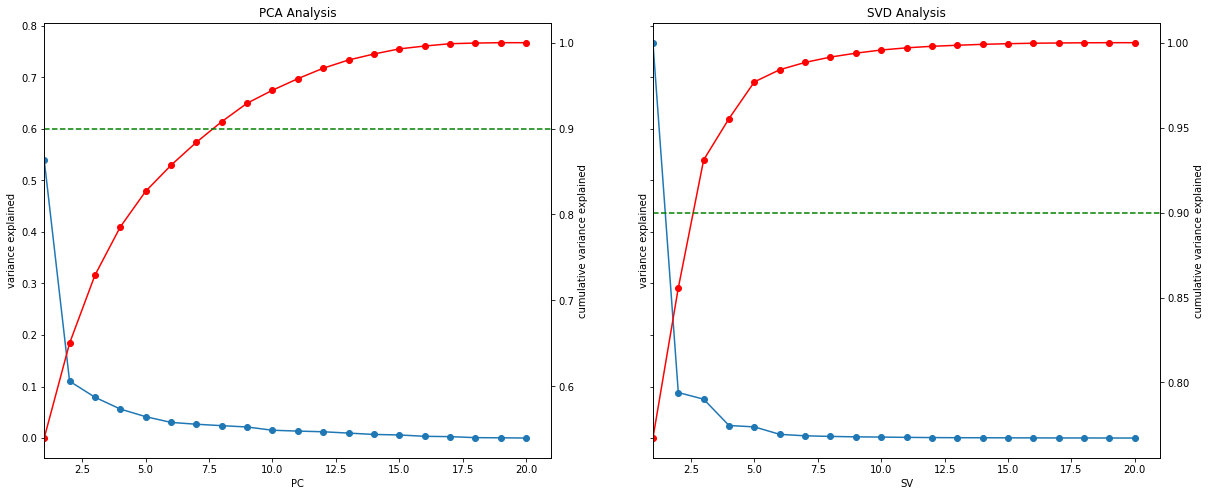

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), sharey=True,
                               sharex=True)
plot_variance(PCA(feature.shape[1] - 1).fit(feature),
              'PCA Analysis', ax1, xlabel='PC')
svd_all = TruncatedSVD(feature_raw.shape[1] - 1).fit(feature_raw)
plot_variance(svd_all, 'SVD Analysis', ax2, xlabel='SV');

In this report, we have performed a dimensional reduction analysis for the team statistics to reduce the number of dimensions. Comparing two-dimensionality reduction methods, PCA and Truncated SVD, we determined using PCA is better than using Truncated SVD even though SVD achieved an estimated 93% cumulative explained variance with just three components where using PCA needed seven components. Since the height and weight have a high value compared to the other features, using SVD transforms the data biased to height and weight.

In [28]:
pca_avg = PCA(2).fit(feature)
feature_new = pca_avg.transform(feature)

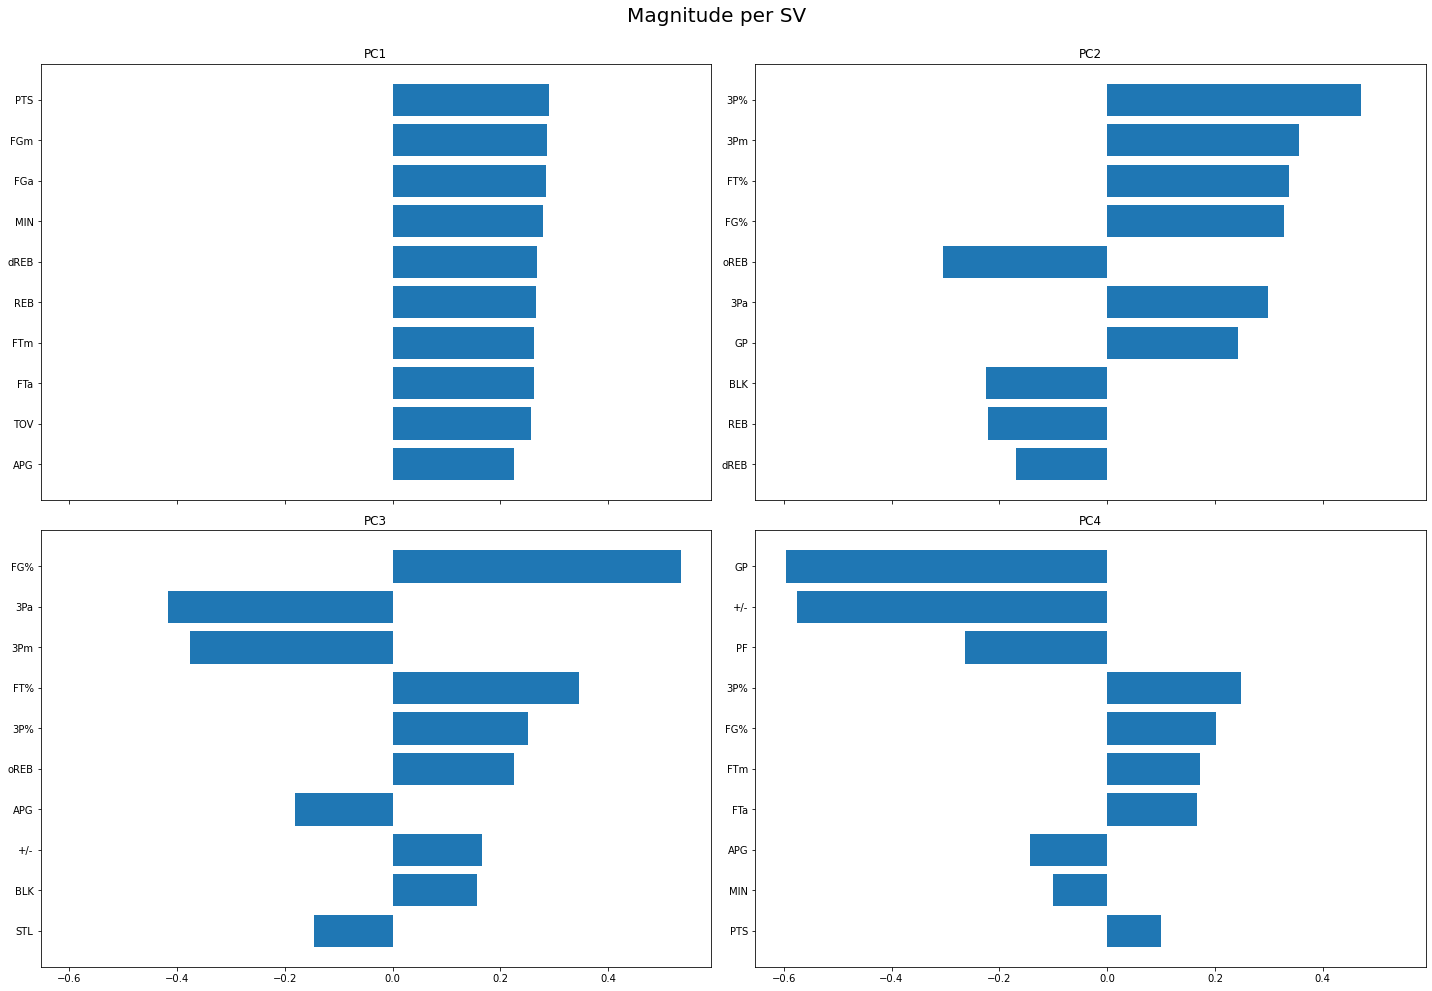

In [40]:
pca_all = PCA(4).fit(feature)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 14),
                                             sharex=True)

ax1.set_title('PC1')
plot_svd_bar(feature_raw.columns, pca_all.components_[0], ax1)

ax2.set_title('PC2')
plot_svd_bar(feature_raw.columns, pca_all.components_[1], ax2)

ax3.set_title('PC3')
plot_svd_bar(feature_raw.columns, pca_all.components_[2], ax3)

ax4.set_title('PC4')
plot_svd_bar(feature_raw.columns, pca_all.components_[3], ax4)

plt.suptitle('Magnitude per SV', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])

Plotting each feature's magnitude in the principal components above, we can observe that average points, field goals made, 3-points made, and 3-point% are among the top features of Principal components 1 and 2.

##### Ward's Method

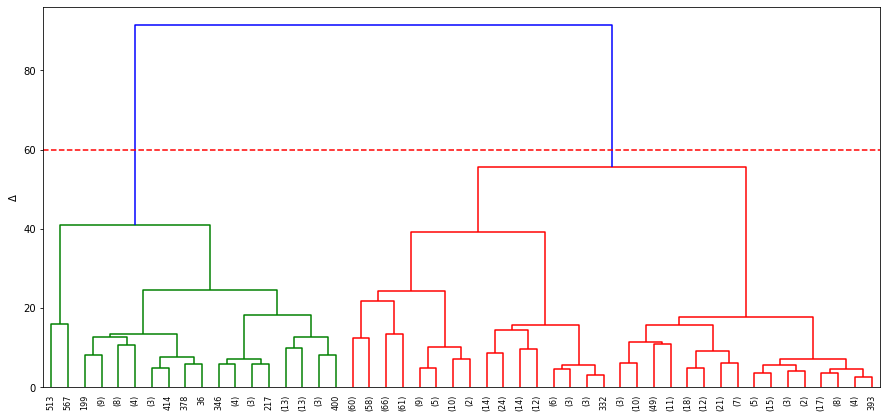

In [31]:
fig, ax = plt.subplots(figsize=(15, 7))
Z_ward = linkage(feature, method='ward', optimal_ordering=True)
ax = plot_dendrogram(Z_ward, ax)
ax.axhline(60, c='r', linestyle='dashed');

##### Result

##### Choosing the right threshold

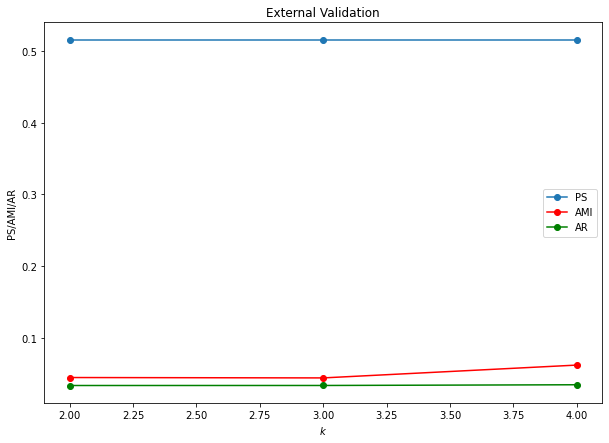

In [45]:
fig, ax = plt.subplots(figsize=(10, 7))
res = agglo_cluster_range(feature, 'ward',
                          t_start=40, t_stop=60, actual=target)
plot_external(res['ps'], res['amis'], res['ars'], ax)
ax.set_title('External Validation')
plt.show()

Comparing different hierarchical clustering methods, we conclude that using Ward's method is the most suitable. Ward's method outperforms single, complete, and average linkage methods. Plotting the dendrogram of each method shows that Ward's method separated the dataset into 2 groups with the highest distance for every cluster, whereas other methods failed to do so. In validating the clusters with position of each player, we can infer that 2 cluster is the ideal number of groups since it has the highest adjusted mutual information and adjusted rand index.

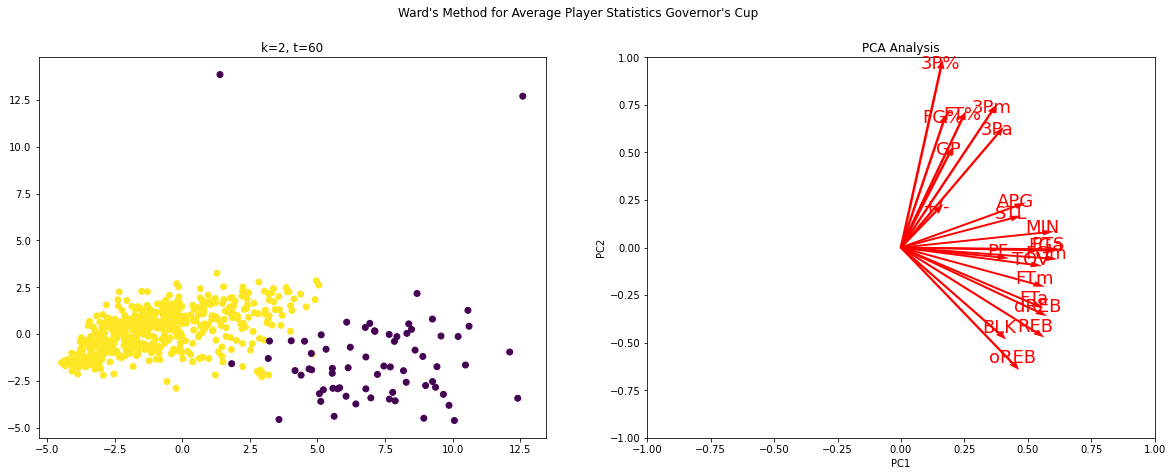

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
ax1 = plot_cluster(feature_new, Z_ward, 60, ax1)
ax2= plot_pca(feature_raw.columns, pca_avg.components_.T, ax2)
ax2.set_title('PCA Analysis')

plt.suptitle("Ward's Method for Average Player Statistics Governor's Cup");

Observing the PC1 and PC2 of the decomposed dataset, we can find that the most dominant feature in PC2 is the field goal and three-point percentage, attempted and made. While the most dominant feature in PC1 is the average points, minutes per game. Upon further examination of the data, we can see that free throws are orthogonal to three points and field goals, thus inferring they have no correlation. We can also see that the three points vectors also have no correlation to blocks and rebounds. Thus inferring that most three point shooters are smaller than people who excel in rebounds and blocks but compensates in shooting.

In [33]:
y_cluster = fcluster(Z_ward, t=60, criterion='distance')
df_avg_player_gov['cluster'] = y_cluster

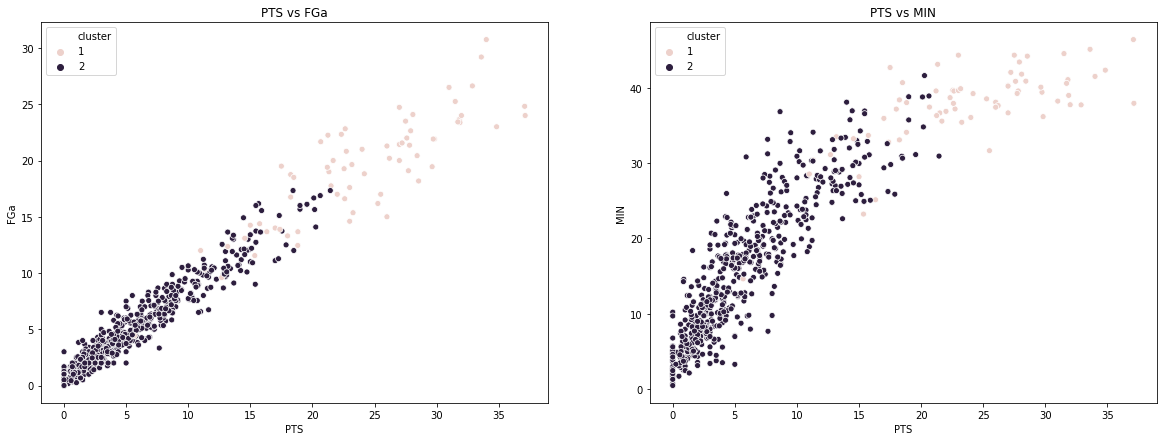

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

sns.scatterplot(x='PTS', y='FGa', hue='cluster', legend='full',
                data=df_avg_player_gov, ax=ax1)
ax1.set_title('PTS vs FGa')

ax2.set_title('PTS vs MIN')
sns.scatterplot(x='PTS', y='MIN', hue='cluster', legend='full',
                data=df_avg_player_gov, ax=ax2)
plt.show()

From the plot above, as the average of points and FGa attempted increases, the predicted group of the cluster change as well. Most of the players who have been clustered in group 2 have minimal attempts to make a score and earn points. We can infer that players that have been clustered in this group are benchwarmers or defensive players. While players who belong in group 1 have high field goal attempts and points made are a starters and offensive players.  Upon further investigation, we can see that the identified starters in cluster 1 have the longest playing time in the court. In contrast, players who are identified benchwarmers have the shortest time in the court.

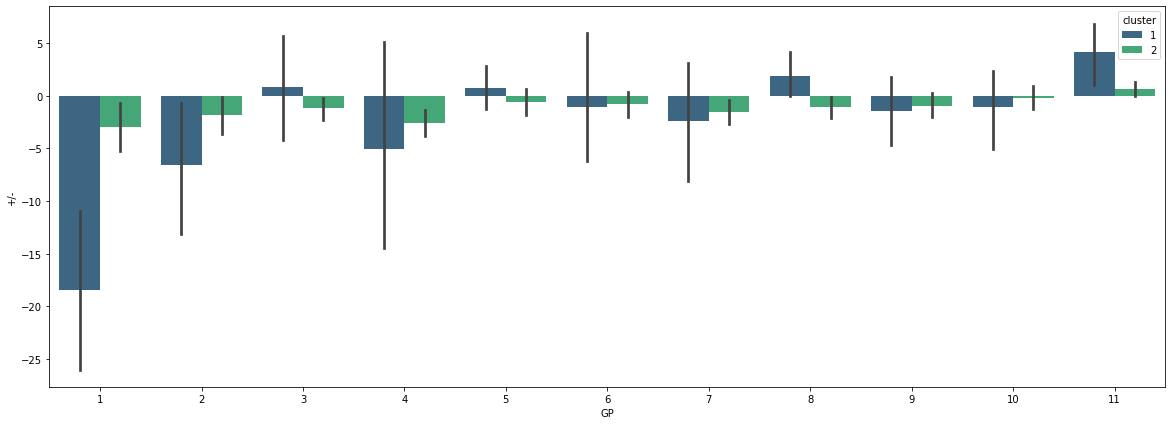

In [158]:
plt.subplots(figsize=(20, 7))
sns.barplot(x='GP', y='+/-', hue='cluster',
            estimator=np.mean, palette='viridis',
            data=df_avg_player_gov)
plt.show()

Based on the plot above, we can see that players who have a few numbers of games played have low-performance efficiency. Although the number of games played by the player increases, we can see an improvement in player efficiency. Based on these results, we can infer that teams with great players having high offensive and defensive attributes have the highest number of games. Teams with such players are not eliminated in the early round, thus a higher chance of becoming champions. In contrast, teams with players with negative player efficiency (High number of missed field goals and free throws, and turnover) tend to be eliminated at the start of the season. We can also see that players with the highest player efficiency belong in group 1 identified as starters.

##### Radar plot

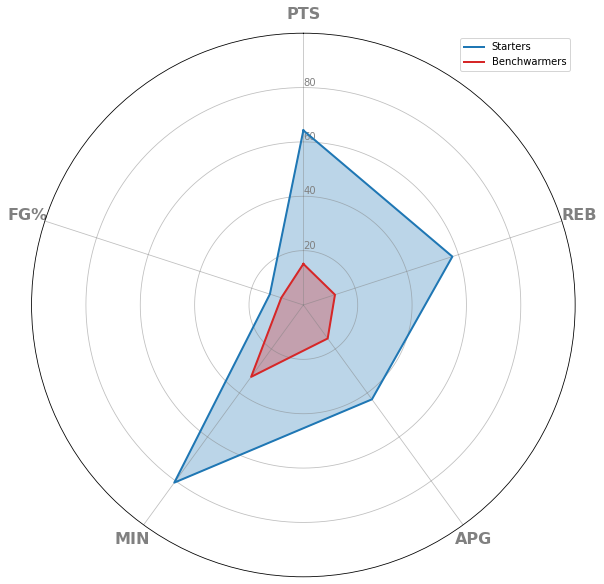

In [35]:
fig = plt.figure(figsize=(20,10))
ax = plt.gca(polar=True)
df_radar = df_avg_player_gov[['cluster','PTS',
                                  'REB', 'APG', 'MIN',
                                  'FG%']].copy()
plot_radar(df_radar, ax, ['tab:blue', 'tab:red'])
plt.legend(['Starters', 'Benchwarmers']);

The radar plot above exhibits the clustered groups' average statistics for points, rebounds, assist per game, minutes player, and field goal percentage of each player. Players that have been identified as benchwarmers can bee seen with the lowest attributes. Benchwarmer players' highest attribute is the MIN, 30% average minutes per game, compared to other clusters, points are still quite small. The second clustered group we have identified are starter players. These players have a higher skill set than benchwarmers, thus having a longer time is spent in the court. We can tell that starter players dominate other players in terms of rebounding, assist, and average points per game. Since these players have the highest skill set, they play 80% of the time, which is considered the longest.

#### Average Player Statistics Commisioner's Cup

In [75]:
m1 = df_avg_player.conference == 'COM'
m2 = df_avg_player.year.astype(int) < 2020
df_avg_player_com = df_avg_player.loc[m1 & m2].copy()

feature_raw = df_avg_player_com.drop(['year', 'conference', 'player_name',
                                      'team_name', 'pos', 'j_number',
                                      'height', 'weight'], axis=1)
feature = StandardScaler().fit_transform(feature_raw)
lbl_enc = LabelEncoder().fit(df_avg_player_com.pos)
target = lbl_enc.transform(df_avg_player_com.pos)

##### Explore Dimensionality Reduction

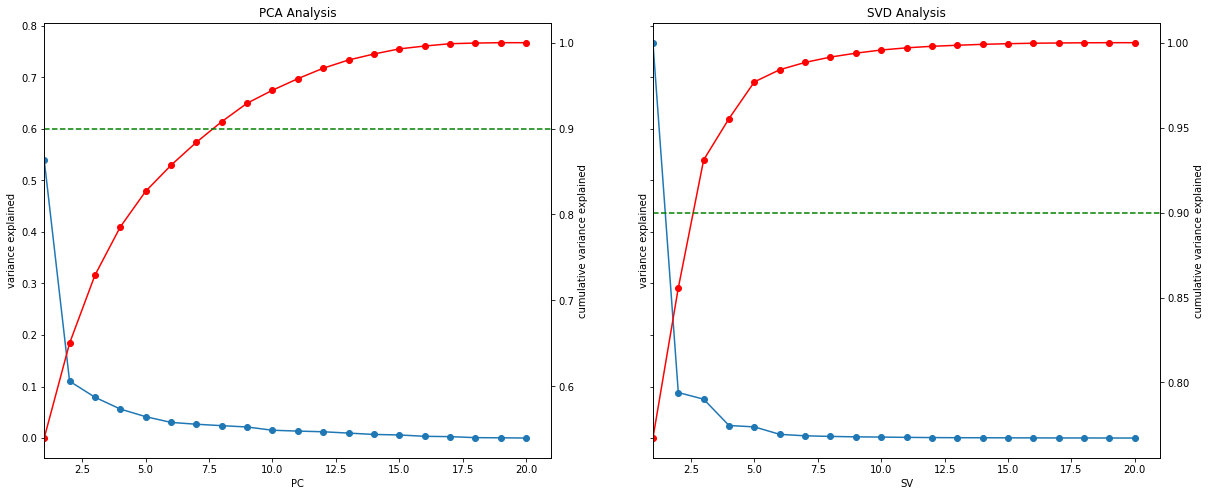

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), sharey=True,
                               sharex=True)
plot_variance(PCA(feature.shape[1] - 1).fit(feature),
              'PCA Analysis', ax1, xlabel='PC')
plot_variance(TruncatedSVD(feature_raw.shape[1] - 1).fit(feature_raw),
              'SVD Analysis', ax2, xlabel='SV');

In this report, we have performed a dimensional reduction analysis for the team statistics to reduce the number of dimensions. Comparing two-dimensionality reduction methods, PCA and Truncated SVD, we determined using PCA is better than using Truncated SVD even though SVD achieved an estimated 93% cumulative explained variance with just 3 components where using PCA needed 8 components. Since the height and weight have a high value compared to the other features, using SVD transforms the data biased to height and weight.

In [48]:
pca_avg = PCA(2).fit(feature)
feature_new = pca_avg.transform(feature)

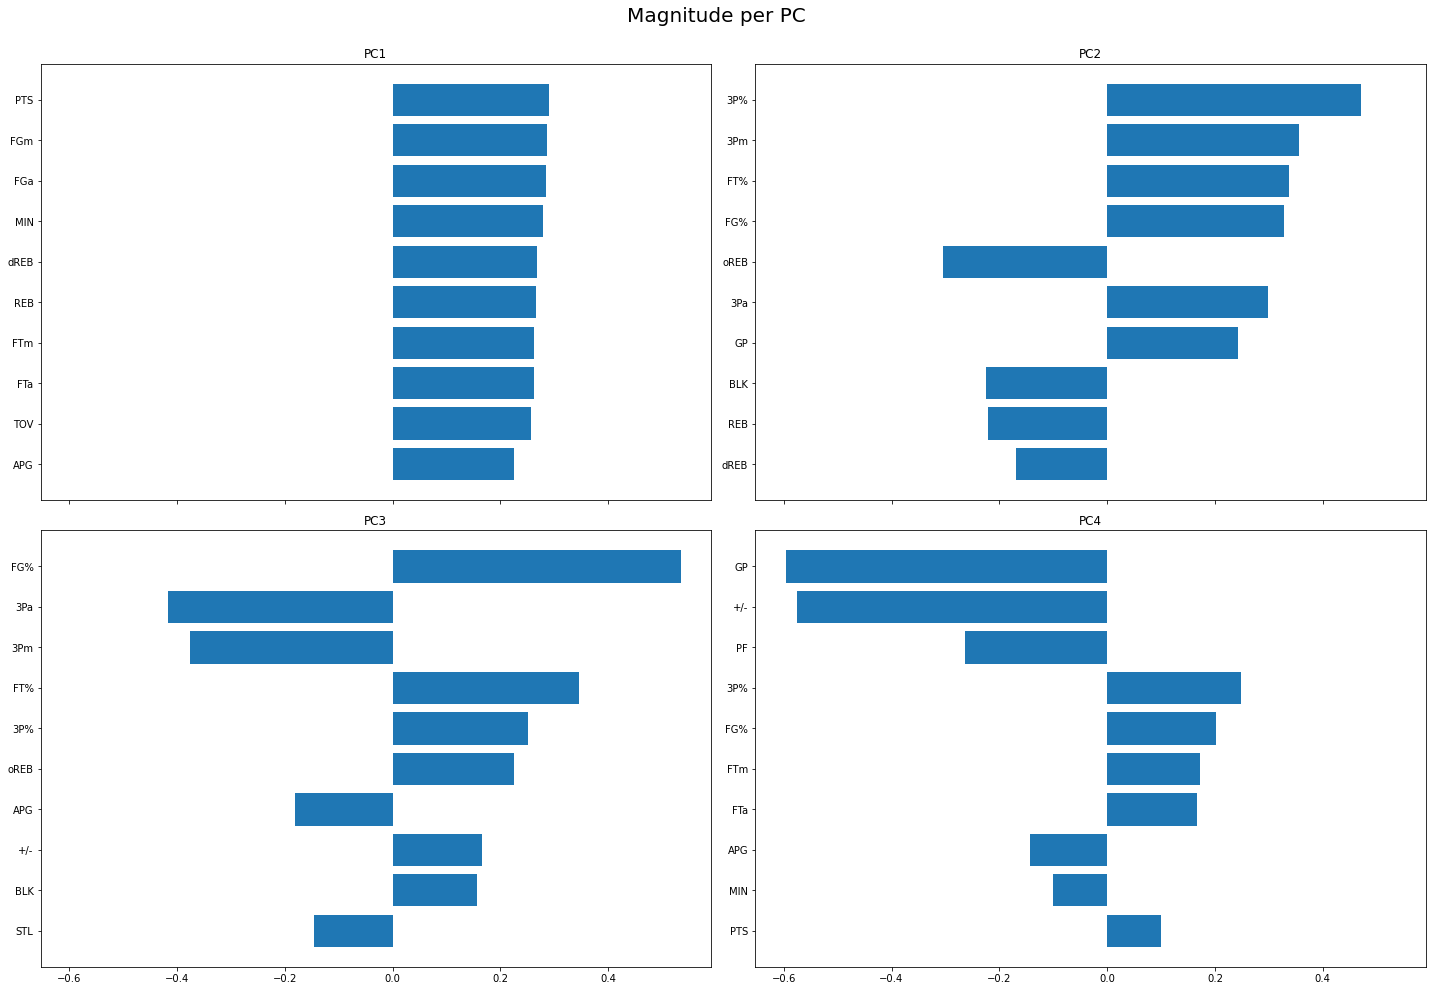

In [49]:
pca_all = PCA(4).fit(feature)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 14),
                                             sharex=True)

ax1.set_title('PC1')
plot_svd_bar(feature_raw.columns, pca_all.components_[0], ax1)

ax2.set_title('PC2')
plot_svd_bar(feature_raw.columns, pca_all.components_[1], ax2)

ax3.set_title('PC3')
plot_svd_bar(feature_raw.columns, pca_all.components_[2], ax3)

ax4.set_title('PC4')
plot_svd_bar(feature_raw.columns, pca_all.components_[3], ax4)

plt.suptitle('Magnitude per PC', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])

Plotting each feature's magnitude in the principal components above, we can observe that average points, field goals made, 3-points made, attempted, and percentage are among the top features of Principal components 1 and 2.

##### Ward's Method

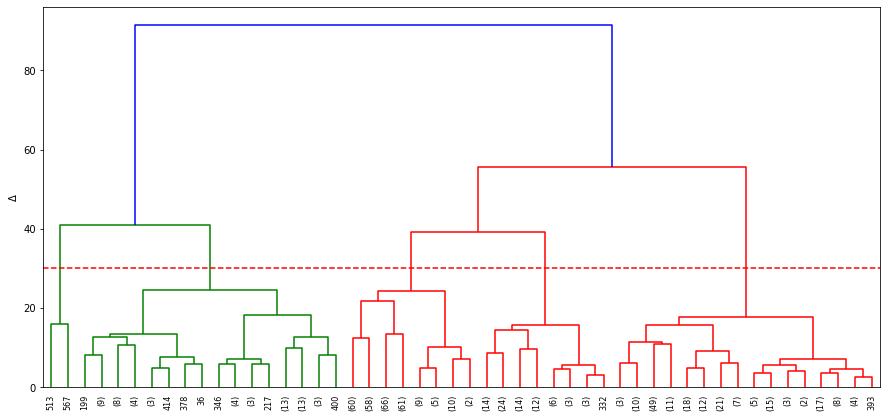

In [50]:
fig, ax = plt.subplots(figsize=(15, 7))
Z_ward = linkage(feature, method='ward', optimal_ordering=True)
ax = plot_dendrogram(Z_ward, ax)
ax.axhline(30, c='r', linestyle='dashed');

##### Result

##### Choosing the right threshold

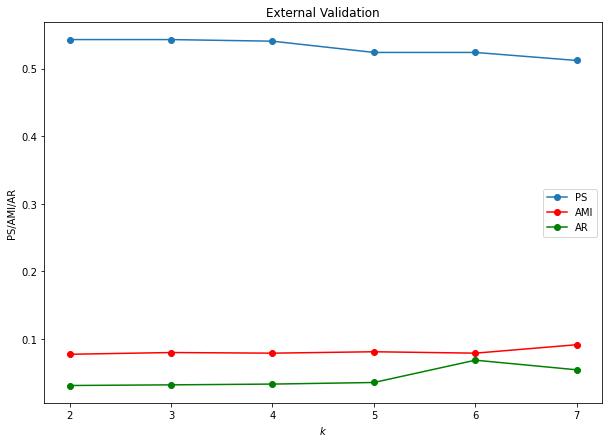

In [33]:
fig, ax = plt.subplots(figsize=(10, 7))
res = agglo_cluster_range(feature, 'ward',
                          t_start=15, t_stop=30, actual=target)
plot_external(res['ps'], res['amis'], res['ars'], ax)
ax.set_title('External Validation')
plt.show()

Comparing different hierarchical clustering methods, we conclude that using Ward's method is the most suitable. Ward's method outperforms single, complete, and average linkage methods. Plotting the dendrogram of each method shows that Ward's method separated the dataset into 3 groups with the highest distance for every cluster, whereas other methods failed to do so. Validating the clusters with each player's position, we can infer that 3 clusters are the ideal number of groups since it has the highest adjusted mutual information and adjusted rand index. Even though increasing the clusters also increases adjusted mutual and rand index, we prioritize a higher purity.

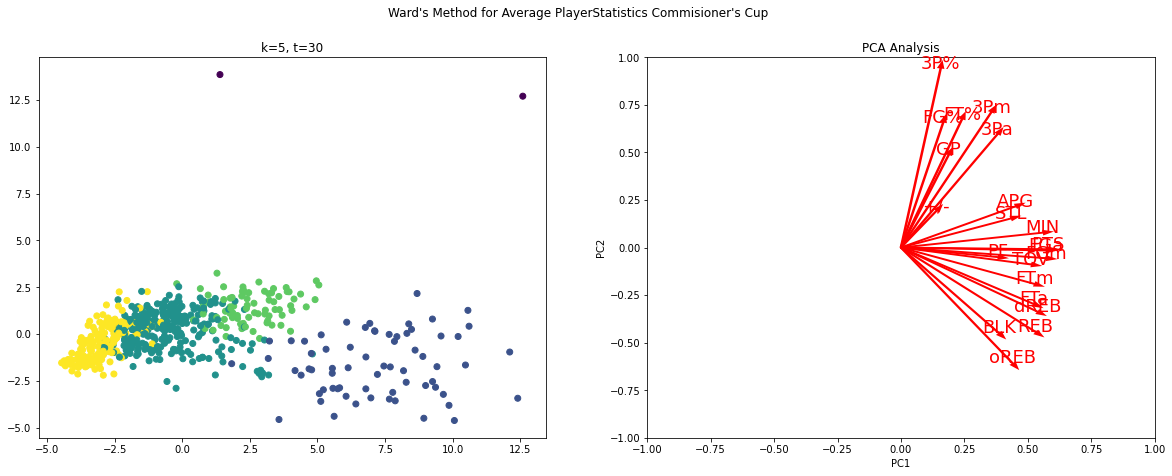

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
ax1 = plot_cluster(feature_new, Z_ward, 30, ax1)
ax2= plot_pca(feature_raw.columns, pca_avg.components_.T, ax2)
ax2.set_title('PCA Analysis')


plt.suptitle("Ward's Method for Average Player"
             "Statistics Commisioner's Cup");

Observing the PC1 and PC2 of the decomposed dataset, we can find that the most dominant feature in PC2 is three points percentage, attempted and made, rebounds, blocks and free throws. While the most dominant feature in PC1 is the average points, minutes per game. Upon further examination of the data, we can see that three points vectors also have no correlation to blocks and rebounds since they are orthogonal to each other. Thus inferring that most three point shooters are smaller than people who excel in rebounds and blocks but compensates in shooting.

In [82]:
y_cluster = fcluster(Z_ward, t=30, criterion='distance')
df_avg_player_com['cluster'] = y_cluster

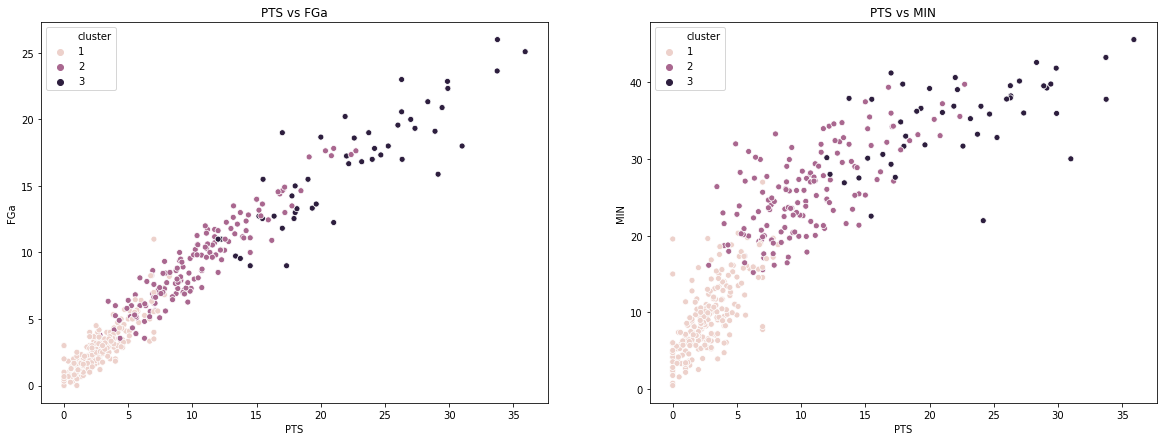

In [83]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

ax1.set_title('PTS vs FGa')
sns.scatterplot(x='PTS', y='FGa', hue='cluster', legend='full',
                data=df_avg_player_com, ax=ax1)

ax2.set_title('PTS vs MIN')
sns.scatterplot(x='PTS', y='MIN', hue='cluster', legend='full',
                data=df_avg_player_com, ax=ax2);

From the plot above, as the average of points and FGa attempted increases, the predicted group of the cluster change as well. Most of the players who have been clustered in group 1 have minimal attempts to make a score and earn points. We can infer that players that have been clustered in this group are benchwarmers or defensive players. While players who belong in group 3 have high field goal attempts and points made are a imports and offensive players.  Upon further investigation, we can see that the identified imports in cluster 3 have the longest playing time in the court. In contrast, players who are identified benchwarmers have the shortest time in the court.

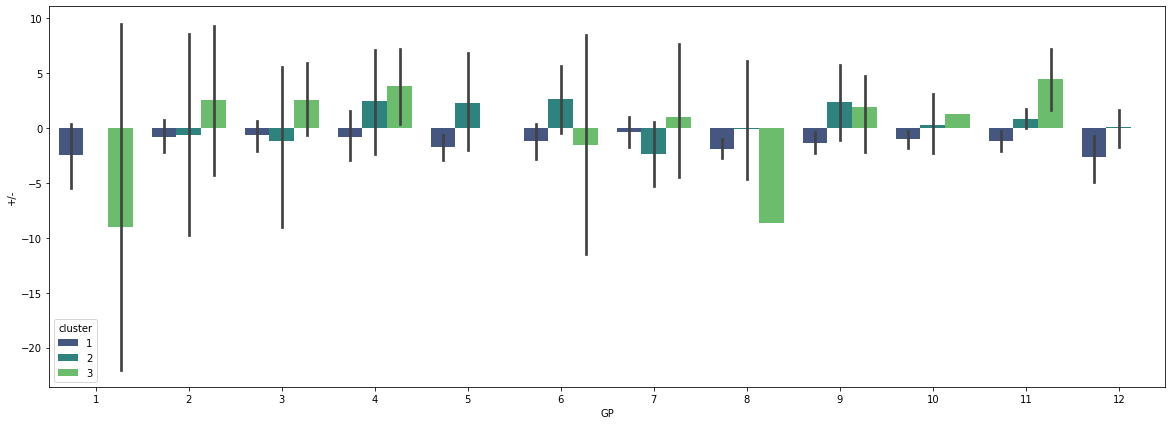

In [84]:
plt.subplots(figsize=(20, 7))
sns.barplot(x='GP', y='+/-', hue='cluster',
            estimator=np.mean, palette='viridis',
            data=df_avg_player_com)
plt.show()

Based on the plot above, we can see that players who have a few numbers of games played have low-performance efficiency. Although the number of games played by the player increases, we can see an improvement in player efficiency. However, we could see a sudden drop on player efficiency on players who played 7 or 8 games but increases again on players with 9 games onwards. Based on these results, we can infer that teams with great players having high offensive and defensive attributes have the highest number of games. Teams with such players are not eliminated in the early round, thus a higher chance of becoming champions. In contrast, teams with players with negative player efficiency (High number of missed field goals and free throws, and turnover) tend to be eliminated at the start of the season. We can also see that players with the highest player efficiency belong in group 1 identified as starters.

##### Radar plot

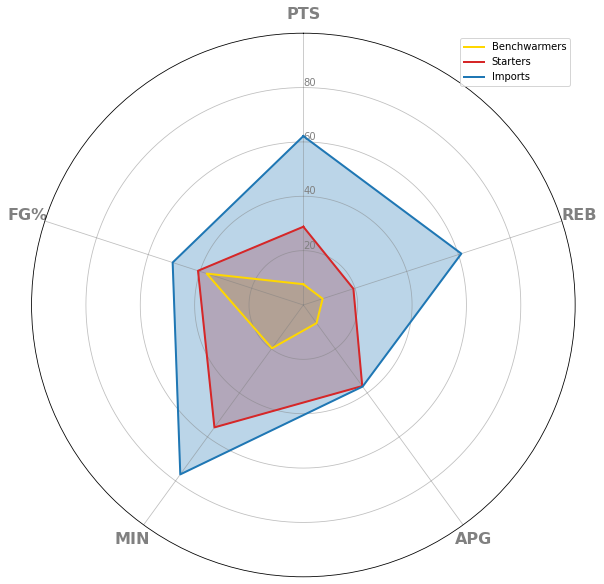

In [85]:
fig = plt.figure(figsize=(20, 10))
ax = plt.gca(polar=True)
df_radar = df_avg_player_com[['cluster', 'PTS',
                              'REB', 'APG', 'MIN',
                              'FG%']].copy()
plot_radar(df_radar, ax, ['gold', 'tab:red', 'tab:blue'])
plt.legend(['Benchwarmers', 'Starters', 'Imports'])

The radar plot above exhibits the clustered groups' average statistics for points, rebounds, assist per game, minutes player, and field goal percentage of each player. Players that have been identified as benchwarmers can bee seen with the lowest attributes. Benchwarmer players' highest attribute is the FG%, almost 40% field goal percentage, compared to other clusters, points are still quite small. The second clustered group we have identified are starter players. These players have a higher skill set than benchwarmers, thus having a longer time is spent in the court. Although imports have the highest skillset over all the other groups, the assist per game of starters and imports are 40% which is almost identical. Thus, we infer that local starting players' often rely on teamwork. There is a 40% gap in rebounds between imports and starters, which is a huge jump. We can tell that import players dominate other players in terms of rebounding. Since these players have the highest skill set, they play 80% of the time, which is considered the longest.

#### Average Player Statistics Philippine Cup

In [59]:
m1 = df_avg_player.conference == 'PH'
m2 = df_avg_player.year.astype(int) < 2020
df_avg_player_ph = df_avg_player.loc[m1 & m2].copy()

feature_raw = df_avg_player_ph.drop(['year', 'conference', 'player_name',
                                      'team_name', 'pos', 'j_number',
                                      'height', 'weight'], axis=1)
feature = StandardScaler().fit_transform(feature_raw)
lbl_enc = LabelEncoder().fit(df_avg_player_ph.pos)
target = lbl_enc.transform(df_avg_player_ph.pos)

##### Explore Dimensionality Reduction

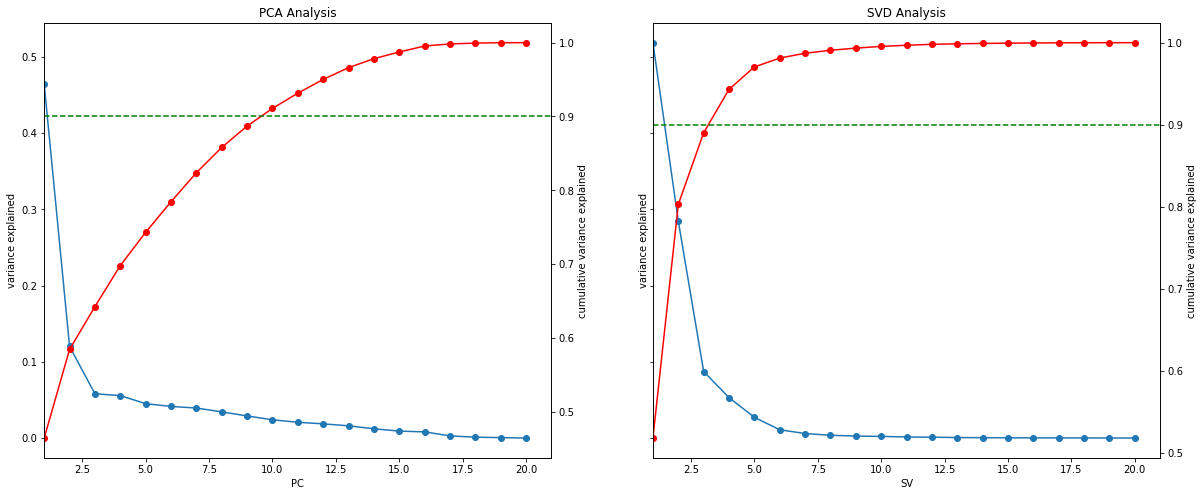

In [60]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), sharey=True,
                               sharex=True)
plot_variance(PCA(feature.shape[1] - 1).fit(feature),
              'PCA Analysis', ax1, xlabel='PC')
plot_variance(TruncatedSVD(feature_raw.shape[1] - 1).fit(feature_raw),
              'SVD Analysis', ax2, xlabel='SV');

In this report, we have performed a dimensional reduction analysis for the team statistics to reduce the number of dimensions. Comparing two-dimensionality reduction methods, PCA and Truncated SVD, we determined using PCA is better than using Truncated SVD even though SVD achieved an estimated 90% cumulative explained variance with just 3 components where using PCA needed 8 components. Since the height and weight have a high value compared to the other features, using SVD transforms the data biased to height and weight.

In [61]:
pca_avg = PCA(2).fit(feature)
feature_new = pca_avg.transform(feature)

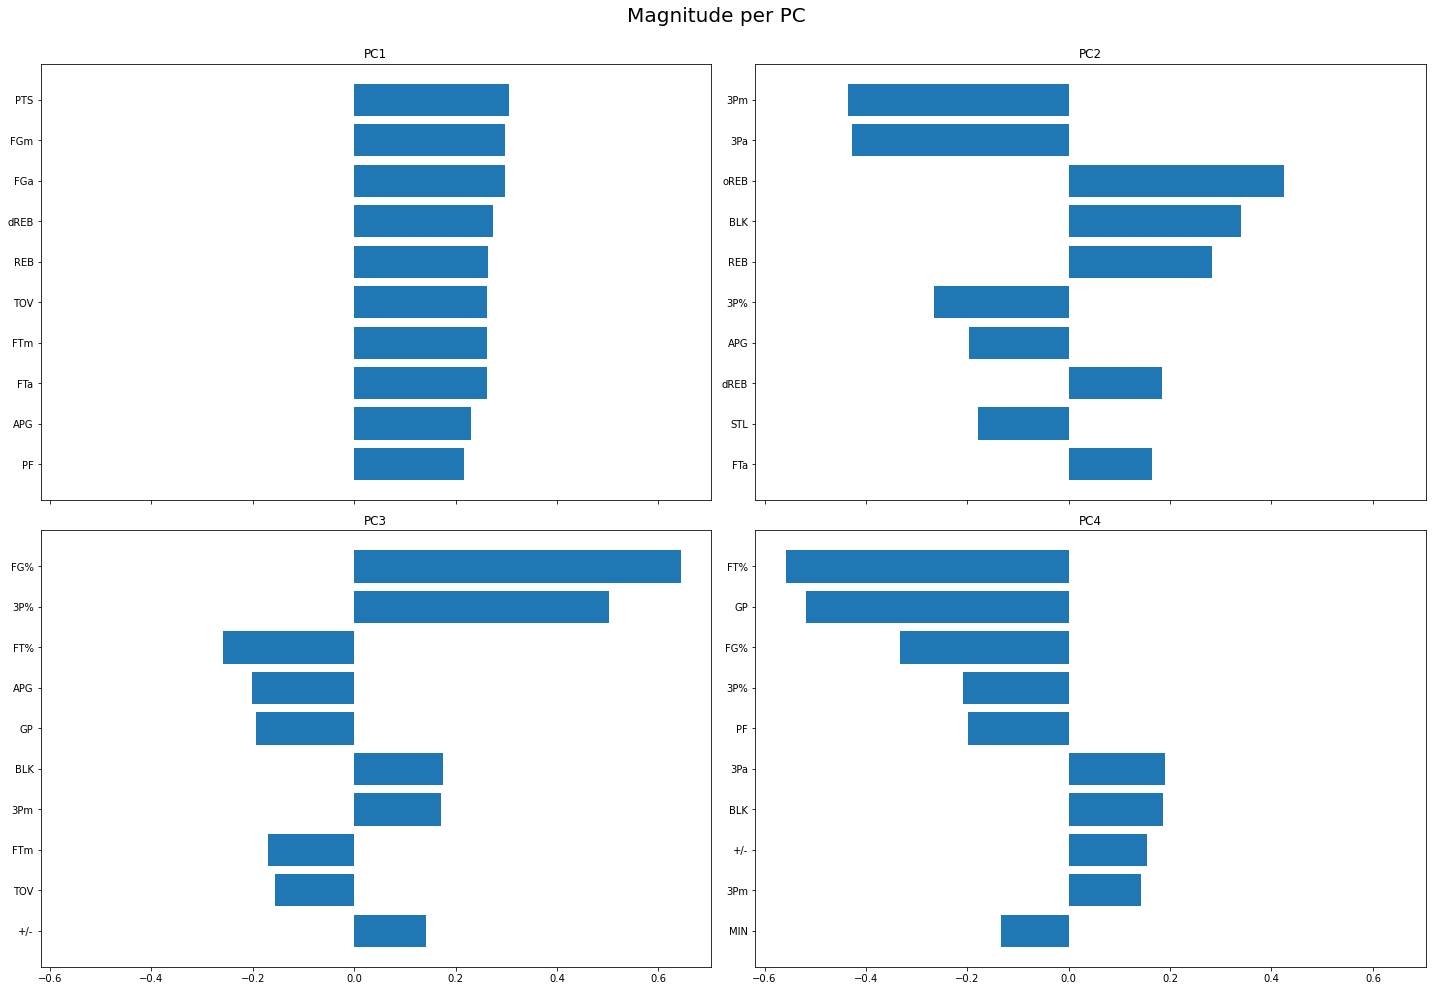

In [62]:
pca_all = PCA(4).fit(feature)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 14),
                                             sharex=True)

ax1.set_title('PC1')
plot_svd_bar(feature_raw.columns, pca_all.components_[0], ax1)

ax2.set_title('PC2')
plot_svd_bar(feature_raw.columns, pca_all.components_[1], ax2)

ax3.set_title('PC3')
plot_svd_bar(feature_raw.columns, pca_all.components_[2], ax3)

ax4.set_title('PC4')
plot_svd_bar(feature_raw.columns, pca_all.components_[3], ax4)

plt.suptitle('Magnitude per PC', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])

Plotting each feature's magnitude in the principal components above, we can observe that average points, field goals and 3-points made, attempted, and percentage are among the top features of Principal components 1 and 2. Upon further investigation, we can see that the magnitude 3-points made, attempted and percentage have a negative magnitude in PC2. In contrast, rebounds and blocks have a positive magnitude in PC2

##### Ward's Method

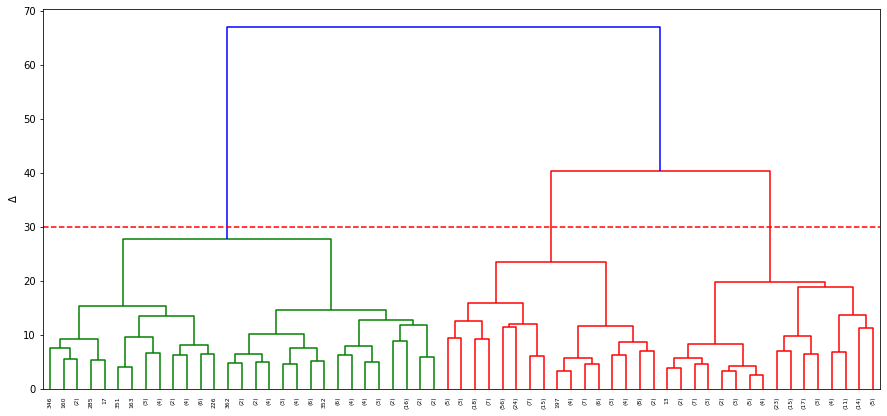

In [63]:
fig, ax = plt.subplots(figsize=(15, 7))
Z_ward = linkage(feature, method='ward', optimal_ordering=True)
ax = plot_dendrogram(Z_ward, ax)
ax.axhline(30, c='r', linestyle='dashed');

##### Result

##### Choosing the right threshold

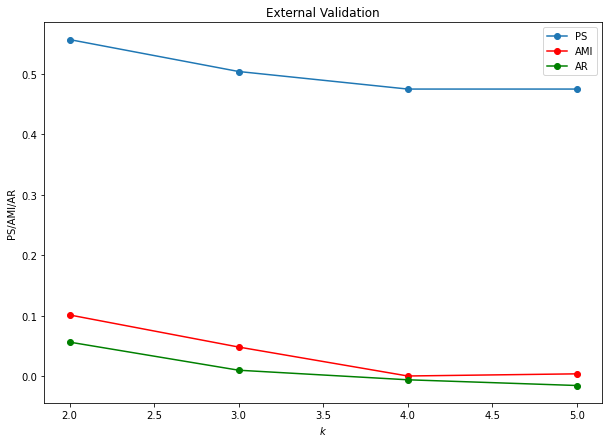

In [100]:
fig, ax = plt.subplots(figsize=(10, 7))
res = agglo_cluster_range(feature, 'ward',
                          t_start=20, t_stop=55, actual=target)
plot_external(res['ps'], res['amis'], res['ars'], ax)
ax.set_title('External Validation')
plt.show()

Comparing different hierarchical clustering methods, we conclude that using Ward's method is the most suitable. Ward's method outperforms single, complete, and average linkage methods. Plotting the dendrogram of each method shows that Ward's method separated the dataset into 3 groups with the highest distance for every cluster, whereas other methods failed to do so.  Even though the complete linkage method's dendrogram is almost as good as Ward's method, Ward's method overtakes the complete linkage in terms of purity. Validating the clusters with each player's position, we can infer that 3 clusters are the ideal number of groups since it has the highest adjusted mutual information and adjusted rand index. Even though increasing the clusters also increases adjusted mutual and rand index, we prioritize a higher purity.

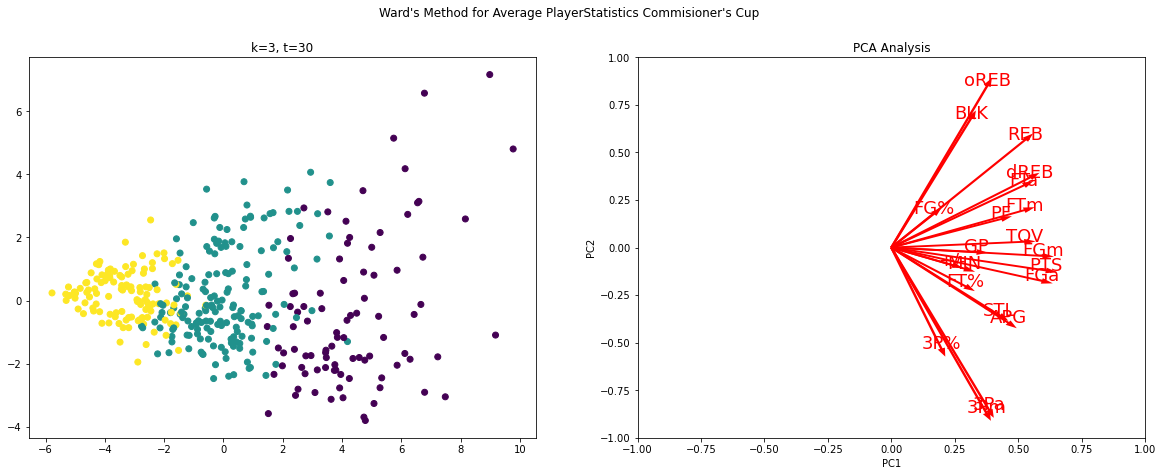

In [67]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
ax1 = plot_cluster(feature_new, Z_ward, 30, ax1)
ax2= plot_svd(feature_raw.columns, pca_avg.components_.T, ax2)
ax2.set_title('PCA Analysis')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')

plt.suptitle("Ward's Method for Average Player"
             "Statistics Commisioner's Cup");

Observing the PC1 and PC2 of the decomposed dataset, we can find that the most dominant feature in PC2 is three points percentage, attempted and made, rebounds amd blocks. While the most dominant feature in PC1 is the average points, minutes per game, turover and field goals. Upon further examination of the data, we can see that three points vectors also have no correlation to blocks and rebounds since they are orthogonal to each other. Thus inferring that most three point shooters are smaller than people who excel in rebounds and blocks but compensates in shooting.

In [120]:
y_cluster = fcluster(Z_ward, t=30, criterion='distance')
df_avg_player_ph['cluster'] = y_cluster

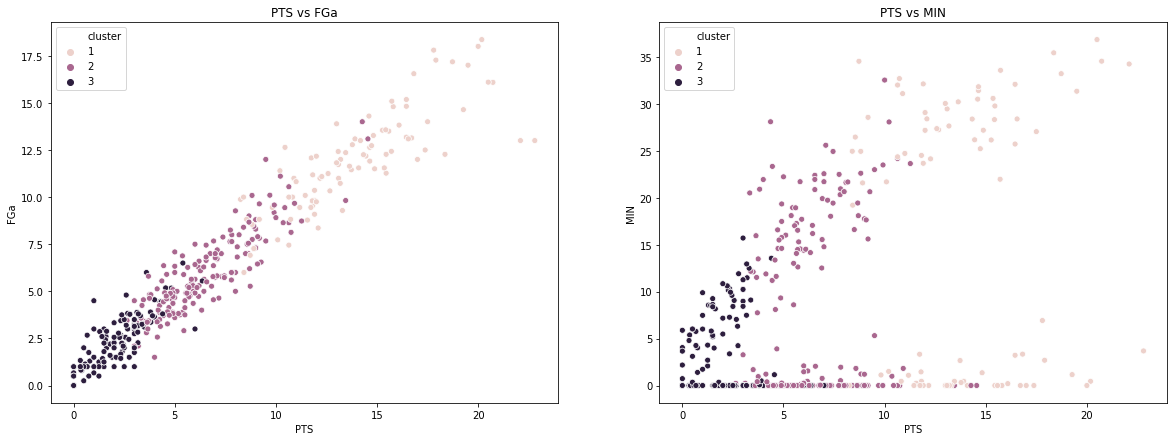

In [121]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

ax1.set_title('PTS vs FGa')
sns.scatterplot(x='PTS', y='FGa', hue='cluster', legend='full',
                data=df_avg_player_ph, ax=ax1)

ax2.set_title('PTS vs MIN')
sns.scatterplot(x='PTS', y='MIN', hue='cluster', legend='full',
                data=df_avg_player_ph, ax=ax2);

From the plot above, as the average of points and FGa attempted increases, the predicted group of the cluster change as well. Most of the players who have been clustered in group 3 have minimal attempts to make a score and earn points. We can infer that players that have been clustered in this group are benchwarmers or defensive players. While players who belong in group 1 have high field goal attempts and points made are a imports and offensive players.  Upon further investigation, we can see that the identified imports in cluster 1 have the longest playing time in the court. In contrast, players who are identified benchwarmers have the shortest time in the court.

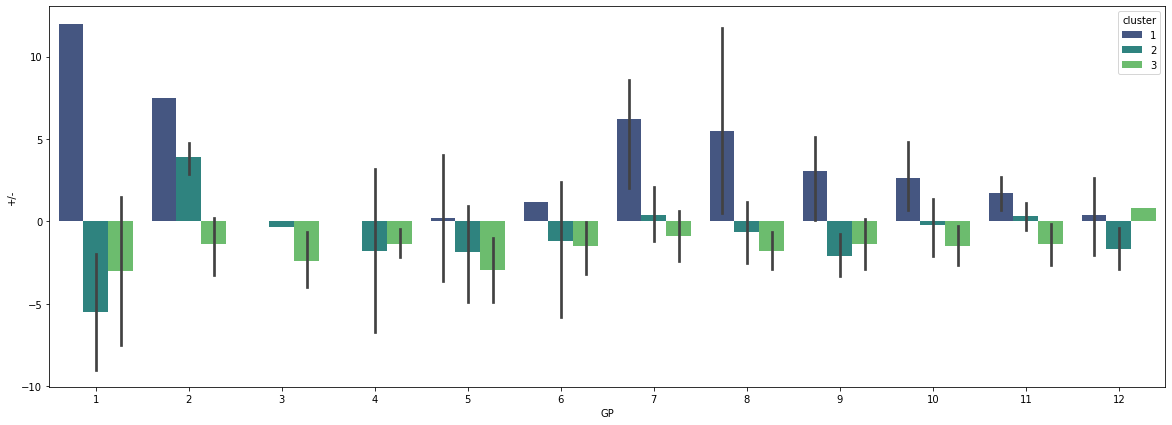

In [122]:
plt.subplots(figsize=(20, 7))
sns.barplot(x='GP', y='+/-', hue='cluster',
            estimator=np.mean, palette='viridis',
            data=df_avg_player_ph)
plt.show()

Based on the plot above, we can see that players who have a few numbers of games played have low-performance efficiency. Although the number of games played by the player increases, we can see an improvement in player efficiency. Based on these results, we can infer that teams with great players having high offensive and defensive attributes have the highest number of games. Teams with such players are not eliminated in the early round, thus a higher chance of becoming champions. In contrast, teams with players with negative player efficiency (High number of missed field goals and free throws, and turnover) tend to be eliminated at the start of the season. We can also see that players with the highest player efficiency belong in group 1 identified as starters.

##### Radar plot

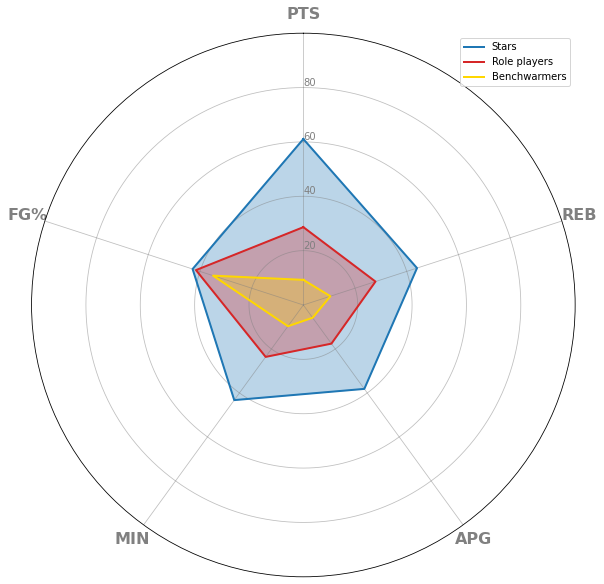

In [132]:
fig = plt.figure(figsize=(20,10))
ax = plt.gca(polar=True)
df_radar = df_avg_player_ph[['cluster','PTS',
                                  'REB', 'APG', 'MIN',
                                  'FG%']].copy()
plot_radar(df_radar, ax, ['tab:blue', 'tab:red', 'gold'])
plt.legend(['Stars', 'Role players', 'Benchwarmers']);

The radar plot above exhibits the clustered groups' average statistics for points, rebounds, assist per game, minutes player, and field goal percentage of each player. Players that have been identified as benchwarmers can bee seen with the lowest attributes. Benchwarmer players' highest attributes are FG%, almost 40% field goals, and other clusters, which are still quite small. The second clustered group we have identified are role players. These players have a higher skill set than benchwarmers, thus having a longer time is spent in the court. Although imports have the highest skillset over all the other groups, the change in the field goal percentage of role and star players is not significant. Furthermore, we have observed that besides field goal percentage and average points per game, there is less than a 20% increase for each attribute in each cluster.

## Conclusion

With the PBA garnering a lot of controversies over the years, the team was able to check the fairness of roster trades based on the generated clustering algorithms. The clustering provides insights on the teams and managers on whether a particular trade is beneficial to the team or not.<br>
An ideal example would be on balancing out the roster distribution of any particular team. For example, the Star Players identified on the clustering done should only be comprised of 5 members on each team for the Philippine Cup, while on the other leagues 6 members can be an acceptable number.<br><br>
As for drafting and trades, teams identified in the clusters as "needs improvement" should be prioritized when trades are being made in order for them to gain an advantage and balance out the competition. One such example for prioritization of teams under this cluster is to increase their salary caps. In this manner, star players have the motivation to accept the offers, while the League Commissioners ensure that no single team overpowers any other team during the duration of the league.

## Recommendation

The team recommends the following activities to be done in order to supplement the clustering algorithm generated from the study:<br>

1. For PBA to improve their website on data management, as well as layout of the site.<br>
2. Historical data should be included. Suspended players such as Calvin Abueva also brings significant weight in some of the team's history during his active period in the league.<br>
3. Majority of the roster trades also take into account salaries. PBA can take this feature into consideration when improving their website so as to also determine if there are significant differences between players and imports alike.<br>
4. In addition to the salaries, players should also be categorized as imports or not to be able to determine how big of an impact imports are in the overall performance of the team.<br>

## References